## Linear denoiser

In [1]:
USE_TOEPLITZ = True
CHANNELS = list(range(49))
MAX_PTP_FOR_COVARIANCE_ESTIMATION = 100000
SAVE_RESULTS = True
DTYPE = 'float32'

# must be odd number
FILTER_LENGTH = 11
LOAD_INDEX_FROM_DISK = True

# all means denoise and return main + 6 neighboring channels patch,
# main means denoise and only return main channel patch
denoise_mode = 'main'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import lib_denoiser as lib

from collections import namedtuple
SpikeIndexes = namedtuple('SpikeIndexes', ['clean', 'all'])

from pathlib import Path
from collections import defaultdict

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot
from sklearn.covariance import EmpiricalCovariance, LedoitWolf

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.templates import util as templates_utl
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader
from yass.augment.util import amplitudes
from yass.detect import nnet, nnet_experimental
from yass import preprocess

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model
import seaborn as sns

Using TensorFlow backend.


In [4]:
plt.rcParams['figure.figsize'] = (10, 10)

In [5]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

path_to_detector = '/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/detect_nn2.ckpt'

In [6]:
yass.set_config("../config/gcloud/49/default.yaml", 'noisy')
CONFIG = read_config()

In [7]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)

rec_all = RecordingsReader(path_to_standarized, loader='array').data

# add one extra channel with zeros for channels with incomplete number neighbors
rec_all = np.concatenate([rec_all, np.zeros((rec_all.shape[0], 1))], axis=1).astype(DTYPE)

# (spatial_sig,
#  temporal_sig) = noise_utils.noise_cov(rec, 61, 61)

rec_all.shape, rec_all.dtype

((6000000, 50), dtype('float32'))

## Running detector in raw 49 channel data

In [79]:
detector = NeuralNetDetector.load(path_to_detector, 0.5, ch_idx)

(standarized_path,
 standarized_params,
 whiten_filter) = (preprocess
                   .run(if_file_exists='skip'))
    

if LOAD_INDEX_FROM_DISK:
    print('Loading locally...')
    idx = np.load('../../data/cat/spike-train/spike_index.npy')
    index_clean_arr = idx.copy()
    index_all_arr = idx.copy()
else:
    print('Running detector...')
    (index_clean_arr,
     index_all_arr) = nnet.run(standarized_path, standarized_params, whiten_filter,
                       'overwrite', False,
                        path_to_detector,
                        autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt',
                        triage=None)

Loading locally...


In [9]:
# remove spikes at the beginning and end to avoid shifting and incomplete waveform issues
index_clean_arr = index_clean_arr[index_clean_arr[:, 0] > 150]
index_all_arr = index_all_arr[index_all_arr[:, 0] > 150]

In [10]:
_, c = np.unique(index_all_arr[:, 1], return_counts=True)
c.min(), c.max()

(42, 22621)

In [11]:
all_ = lib.SpikeIndex(index_all_arr, ch_idx, CONFIG.geom, CONFIG.neigh_channels)
clean = lib.SpikeIndex(index_clean_arr, ch_idx, CONFIG.geom, CONFIG.neigh_channels)

indexes_raw = SpikeIndexes(clean=clean, all=all_)

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


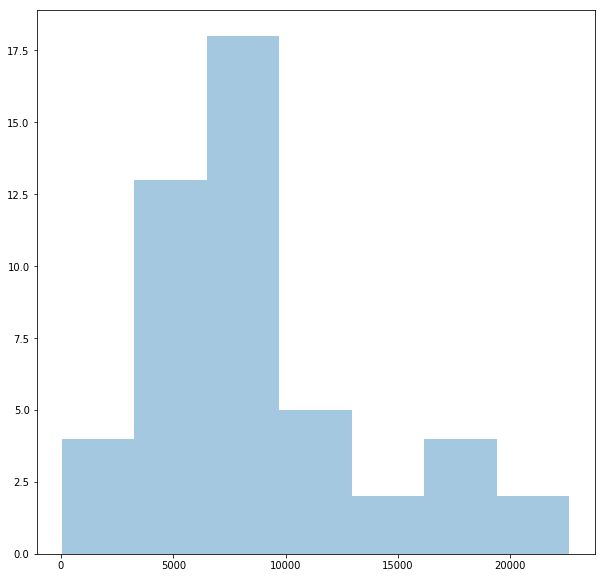

In [12]:
_ = indexes_raw.clean.count_spikes_per_channel()
sns.distplot(list(_.values()), kde=False, norm_hist=False)

## Load noise snippets from raw data for noise covariance estimation

In [13]:
def kill_signal_from_index(recordings, spike_index, window_size):
    """
    Similar to kill_signal, but uses a spike_index and kills the signal
    around the times on it
    """
    recordings = np.copy(recordings)

    T, C = recordings.shape
    R = int((window_size-1)/2)

    # this will hold a flag 1 (noise), 0 (signal) for every obseration in the
    # recordings
    is_noise_idx = np.zeros((T, C))

    # go through every neighboring channel
    for c in range(C):

        # get indexes whose main channel is c
        idx_temp = spike_index[spike_index[:, 1] == c]

        # shift every index found
        for j in range(-R, R+1):

            # shift
            idx_temp2 = idx_temp + j

            # remove indexes outside range [0, T]
            idx_temp2 = idx_temp2[np.logical_and(idx_temp2 >= 0,
                                                 idx_temp2 < T)]

            # set surviving indexes to nan
            recordings[idx_temp2, c] = np.nan

        is_signal_idx_temp = np.isnan(recordings[:, c])

        # set non noise indexes to 0 in the recordings
        recordings[is_signal_idx_temp, c] = 0

        # save noise indexes
        is_noise_idx[~is_signal_idx_temp, c] = 1

    return recordings, is_noise_idx

In [14]:
# rec_with_nas, is_noise_idx = kill_signal_from_index(rec_all, indexes_raw.all.arr,
#                                                     window_size=100)

rec_with_nas, is_noise_idx = noise_utils.kill_signal(rec_all.copy(), threshold=4, window_size=300)

/home/Edu/yass/src/yass/augment/noise.py:55: RuntimeWarning: invalid value encountered in true_divide
  recordings[:, c] = recordings[:, c]/np.nanstd(recordings[:, c])


In [15]:
# plt.imshow(is_noise_idx.T, aspect='auto')

In [16]:
noise_samples = noise_utils.search_noise_snippets(rec_with_nas, is_noise_idx, sample_size=20000,
                                                  temporal_size=FILTER_LENGTH,
                                                  channel_choices=CONFIG.channel_index[[0], :7].tolist(),
                                                  max_trials_per_sample=1000,
                                                  allow_smaller_sample_size=False)
noise_samples.shape

(20000, 11, 7)

/home/Edu/dstools/src/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


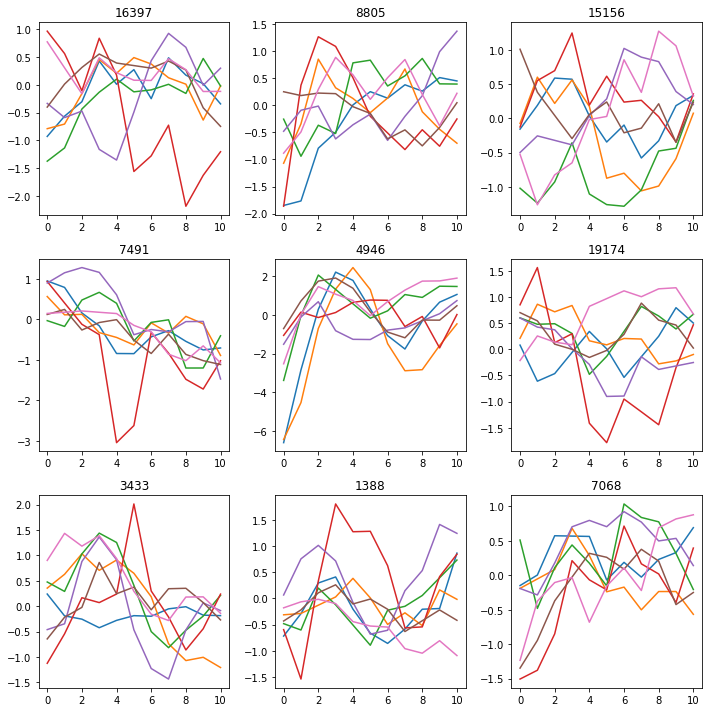

In [17]:
plot.grid_from_array(noise_samples, axis=0, elements=9)

In [18]:
def sample(rec, waveform_length, n):
    """Sample n waveforms of length waveform_length from recordings
    """
    min_idx = 0
    max_idx = rec.shape[0] - waveform_length

    idxs = np.random.randint(min_idx, max_idx, n)

    samples = np.empty((n, waveform_length, rec.shape[1]))

    for i, idx in enumerate(idxs):
        samples[i] = rec[i:i+waveform_length, :]
    
    return samples


def sample_noise(rec, waveform_length, n, detector, max_amplitude):
    """
    Sample n noise snippets of length waveform_length from recordings, pass them through a detector
    and remove the ones with > amplitude than max_amplitude
    """
    noise = np.empty((n, waveform_length, rec.shape[1]))
    remaining = n
    
    while remaining > 0:
        wfs = sample(rec, waveform_length, n)

        noise_amplitude_idx = augment_util.amplitudes(wfs) <= max_amplitude
        
        if detector:
            noise_detector_idx = ~ detector.predict(wfs).astype(bool)
            noise_idx = noise_detector_idx & noise_amplitude_idx
        else:
            noise_idx = noise_amplitude_idx

        noise_found = noise_idx.sum()

        idx_start = n - remaining
        idx_end = idx_start + noise_found
                
        if idx_end > n:
            idx_end = n

        noise[idx_start:idx_end] = wfs[noise_idx][:idx_end-idx_start, :]
        
        remaining -= noise_found
    
    return noise

In [19]:
# get noise samples from first channel neighbors,
# TODO: compute noise covariance per channel + neighbors
# rec = rec_all[:, ch_idx[0]]

# detector=detector
# noise_samples = sample_noise(rec, 51, 100000, detector=None, max_amplitude=4)

tp = TemplatesProcessor(noise_samples)
noise_samples = tp.crop_temporally(int((FILTER_LENGTH - 1)/2)).values

/home/Edu/dstools/src/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


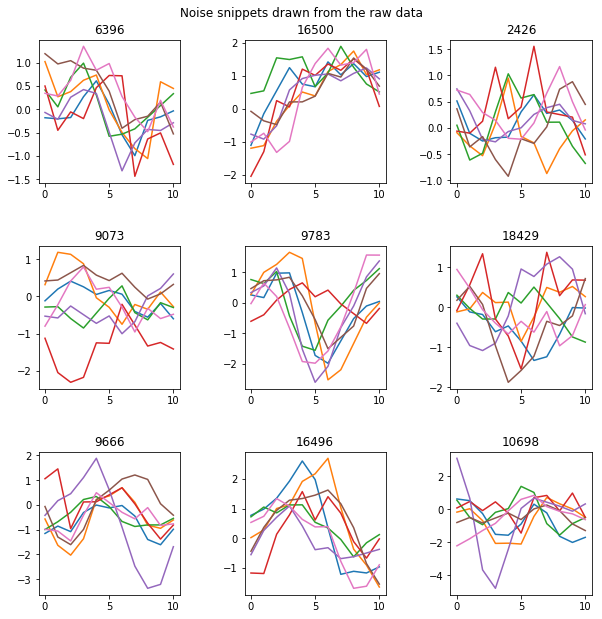

In [20]:
plot.grid_from_array(noise_samples, axis=0, elements=9, auto_figsize=3, auto_tight_layout=False)
_ = plt.suptitle('Noise snippets drawn from the raw data')
plt.tight_layout(pad=3)

## Compute the noise sample covariance using the noise snippets

In [21]:
def compute_covariance(waveforms):
    n, _, _ = waveforms.shape
    
    # reshape data, input is (n_observations, waveform_length, n_channels)
    # output is (n_observations, waveform_length * n_channels)
    # the second dimension is: observations from channel 0, then channel 1, and so on...
    waveforms = waveforms.transpose((0, 2, 1))
    waveforms = waveforms.reshape(n, -1)

    return EmpiricalCovariance(store_precision=False, assume_centered=False).fit(waveforms).covariance_

In [22]:
# should we compute this for every channel?
noise_cov = compute_covariance(noise_samples)

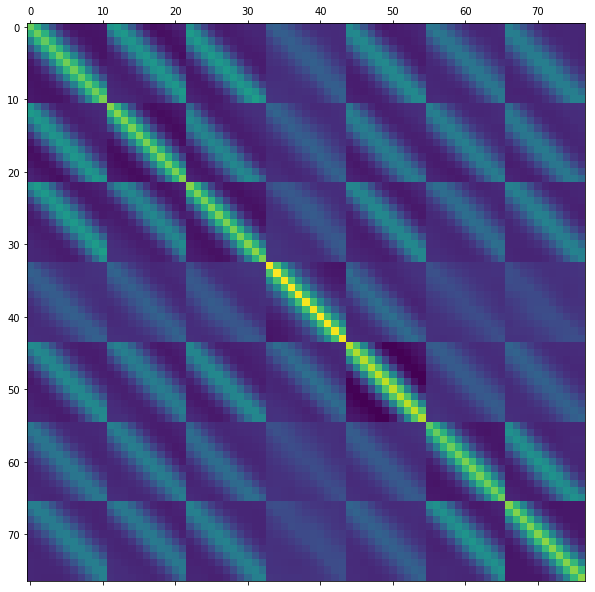

In [23]:
plt.matshow(noise_cov)

## Load spikes from the detector output but just the ones in the selected CHANNELS

In [24]:
def sample_from_times_and_channels(rec, waveform_length, size, channels):
    times = np.random.randint(rec.shape[0] - waveform_length, size=size)
    
    out = np.empty((size, waveform_length, len(channels)))
    
    for i, t in enumerate(times):
        out[i, :, :] = rec[t:t+waveform_length, channels]
    
    return out

In [25]:
# spikes = (indexes_raw.all.read_waveforms_from_channel(rec_all,
#                                                              channel=35,
#                                                              random_shift=True,
#                                                              only_neighbors=True))

In [26]:
# load waveforms for all spikes in the selected channels
# spikes_all_dict = {}
# spikes_times_dict = {}

# for channel in CHANNELS:
#     print(f'Getting spikes from channel {channel}...')
#     spikes = (indexes_raw.all.read_waveforms_from_channel(rec_all,
#                                                              channel=channel,
#                                                              random_shift=True,
#                                                              only_neighbors=True))
#     spikes = TemplatesProcessor(spikes).crop_temporally(int((FILTER_LENGTH - 1) / 2)).values
#     spikes_all_dict[channel] = spikes
#     spikes_times_dict[channel] = indexes_raw.all.get_times_from_channel(channel)

In [27]:
# for channel in CHANNELS:
#     spikes_for_channel = spikes_all_dict[channel]
#     times_for_channel = ['t={:,}'.format(t) for t in spikes_times_dict[channel]]
#     plot.grid_from_array(spikes_for_channel, axis=0, elements=4, auto_figsize=3, labels=times_for_channel)
#     _ = plt.suptitle('Spikes drawn from the raw data (results from detector) in channel {}'.format(channel))
#     plt.tight_layout(pad=3)

In [28]:
# load waveforms for all spikes in the selected channels
spikes_all_dict = {}

for channel in CHANNELS:
    print(f'Getting spikes from channel {channel}...')
    spikes = sample_from_times_and_channels(rec_all, waveform_length=FILTER_LENGTH, size=100000,
                                            channels=ch_idx[channel])
    spikes_all_dict[channel] = spikes

Getting spikes from channel 0...
Getting spikes from channel 1...
Getting spikes from channel 2...
Getting spikes from channel 3...
Getting spikes from channel 4...
Getting spikes from channel 5...
Getting spikes from channel 6...
Getting spikes from channel 7...
Getting spikes from channel 8...
Getting spikes from channel 9...
Getting spikes from channel 10...
Getting spikes from channel 11...
Getting spikes from channel 12...
Getting spikes from channel 13...
Getting spikes from channel 14...
Getting spikes from channel 15...
Getting spikes from channel 16...
Getting spikes from channel 17...
Getting spikes from channel 18...
Getting spikes from channel 19...
Getting spikes from channel 20...
Getting spikes from channel 21...
Getting spikes from channel 22...
Getting spikes from channel 23...
Getting spikes from channel 24...
Getting spikes from channel 25...
Getting spikes from channel 26...
Getting spikes from channel 27...
Getting spikes from channel 28...
Getting spikes from chan

/home/Edu/dstools/src/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


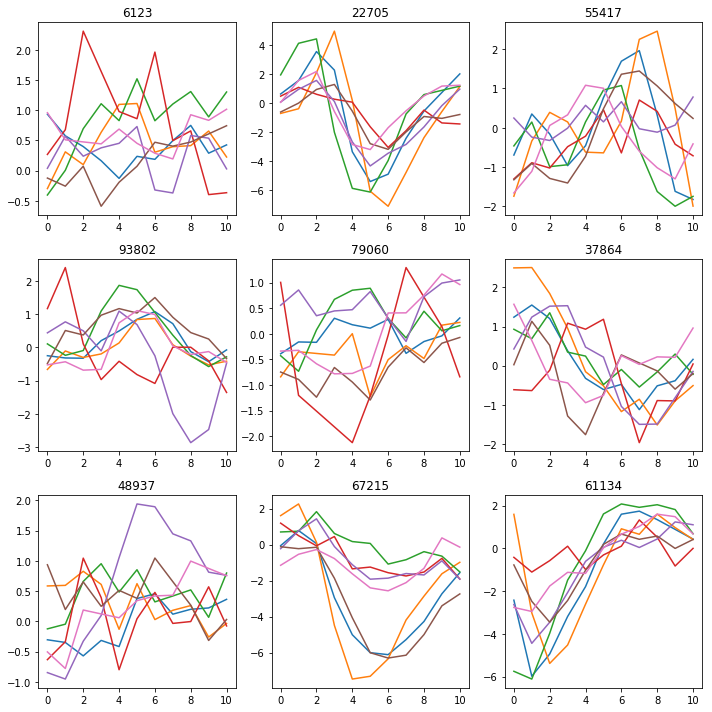

In [29]:
plot.grid_from_array(spikes_all_dict[0], axis=0, elements=9)

In [30]:
# for channel in CHANNELS:
#     _ = spikes_all_dict[channel]
#     ptps = templates_utl.ptps(_)
#     plt.figure()
#     sns.distplot(ptps)
#     _ = plt.title('PTPs of all spikes found in channel(s) {}'.format(channel))

In [31]:
if MAX_PTP_FOR_COVARIANCE_ESTIMATION:
    spikes = dict()
    for channel in CHANNELS:
        current_spikes = spikes_all_dict[channel]
        ptps = templates_utl.ptps(current_spikes)
        spikes[channel] = current_spikes[ptps < MAX_PTP_FOR_COVARIANCE_ESTIMATION]
else:
    spikes = spikes_all_dict


# for ch, sp in spikes.items():
#     plt.figure()
#     sns.distplot(templates_utl.ptps(sp), norm_hist=False, kde=False)
#     _ = plt.title('PTPs of spikes found in channel(s) {} that will be used for covariance estimation'.format(ch))

## Compute the data sample covariance using the spikes snippets

In [32]:
spikes_cov = {}

for ch, sp in spikes.items():
    print('Computing covariance for channel {}'.format(ch))
    spikes_cov[ch] = compute_covariance(sp)

Computing covariance for channel 0
Computing covariance for channel 1
Computing covariance for channel 2
Computing covariance for channel 3
Computing covariance for channel 4
Computing covariance for channel 5
Computing covariance for channel 6
Computing covariance for channel 7
Computing covariance for channel 8
Computing covariance for channel 9
Computing covariance for channel 10
Computing covariance for channel 11
Computing covariance for channel 12
Computing covariance for channel 13
Computing covariance for channel 14
Computing covariance for channel 15
Computing covariance for channel 16
Computing covariance for channel 17
Computing covariance for channel 18
Computing covariance for channel 19
Computing covariance for channel 20
Computing covariance for channel 21
Computing covariance for channel 22
Computing covariance for channel 23
Computing covariance for channel 24
Computing covariance for channel 25
Computing covariance for channel 26
Computing covariance for channel 27
Co

In [33]:
# for ch, cov in spikes_cov.items():
#     plt.matshow(cov)
#     plt.suptitle('Covariance for channel {}'.format(ch))

## Signal covariance estimation

$$\Sigma_{signal} = \Sigma_{data} - \Sigma_{noise}$$

In [34]:
from itertools import product

def make_toeplitz(m):
    """Takes the average of diagonals
    """
    n_diagonals = m.shape[0] - 1

    for i in range(n_diagonals):
        diag = m.diagonal(i)
        val = diag.mean()
        np.fill_diagonal(m[:, i:], val)

    for i in range(1, n_diagonals):
        diag = m.diagonal(-i)
        val = diag.mean()
        np.fill_diagonal(m[i:], val)


def slice_transformation(matrix, fn, offset=51):
    """Slices a matrix in non overlapping offset * offset windows and applies a function
    """
    matrix = matrix.copy()
    
    n_windows = int(matrix.shape[0] / offset)

    slices = [slice(i * offset, (i+1) * offset)  for i in range(n_windows)]
    p = product(slices, slices)

    for i, j in p:
        m = matrix[i, j]
        make_toeplitz(m)
    
    return matrix


# cx = {ch: cov - noise_cov for ch, cov in spikes_cov.items()}

cx = {}

for ch, cov in spikes_cov.items():
    cx[ch] = slice_transformation(cov - noise_cov, make_toeplitz, offset=FILTER_LENGTH)

In [35]:
# for ch, cov_sig in cx.items():
#     plt.matshow(cov_sig)
#     plt.suptitle('Data (raw - noise) covariance for channel {}'.format(ch))

## Compute optimal mapping

$$M = \Sigma_{data}^{-1}  \Sigma_{signal}$$

In [36]:
def compute_mapping(spikes_cov, cx):
    mapping = np.matmul(np.linalg.pinv(spikes_cov), cx)
    return mapping

mapping = {}

for ch in spikes_cov.keys():
    mapping[ch] = compute_mapping(spikes_cov[ch], cx[ch])

In [37]:
# for ch, a_mapping in list(mapping.items())[:1]:
#     plt.matshow(a_mapping)
#     plt.suptitle(f'Mapping for channel {ch}')

## Extract mapping for middle observation in main channel

In [38]:
mapping_all = mapping.copy()
mapping = []

middle = int((FILTER_LENGTH - 1) / 2)

# the first variable is
# first observations from channel 0, then
# first observation from channel 1, and so on...

# we need the filter for the middle observation in
# the main channel. 
for ch, a_mapping in mapping_all.items():
    a_mapping = a_mapping[middle, :][:, np.newaxis]
#     a_mapping = a_mapping[int(ch * FILTER_LENGTH + middle), :][:, np.newaxis]
    mapping.append(a_mapping)

mapping = np.stack(mapping, axis=0)

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


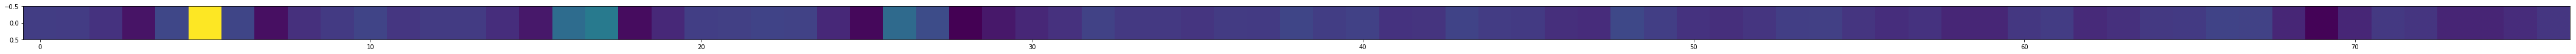

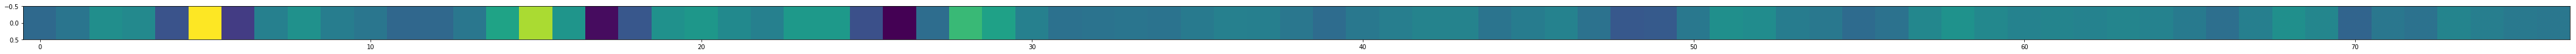

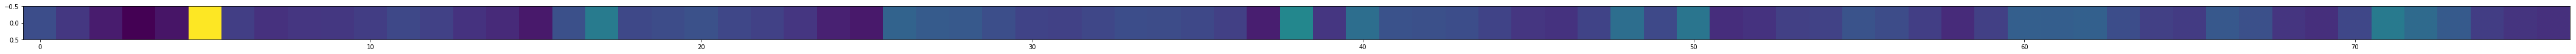

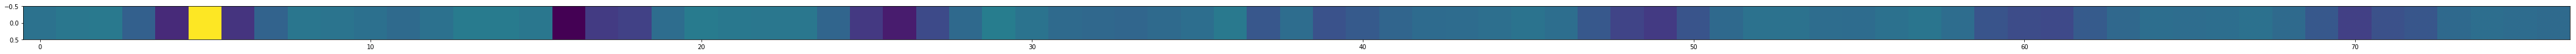

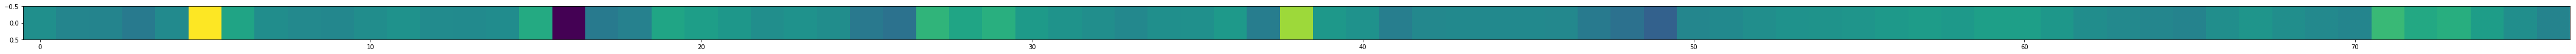

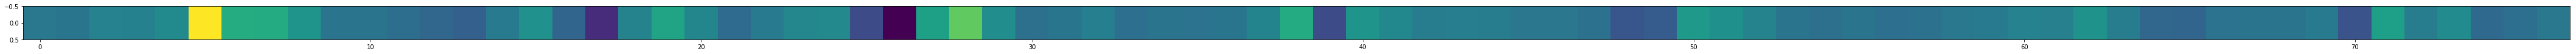

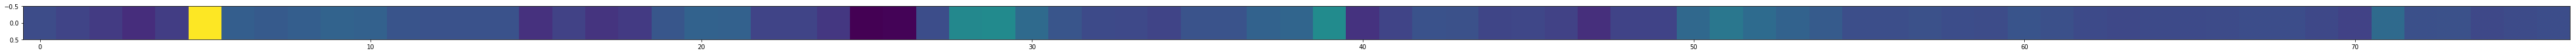

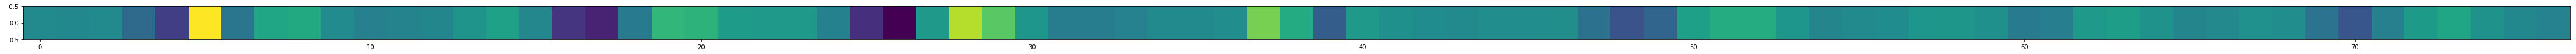

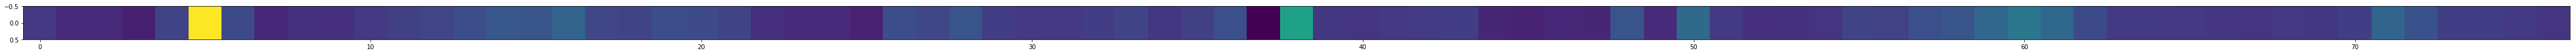

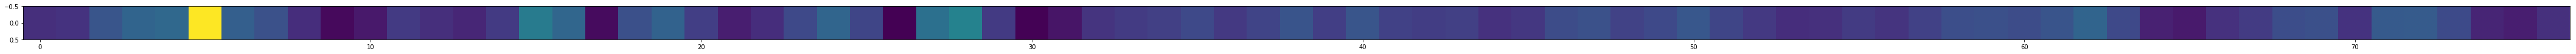

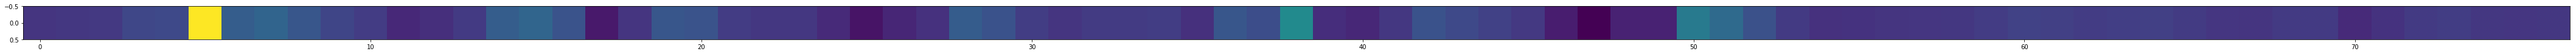

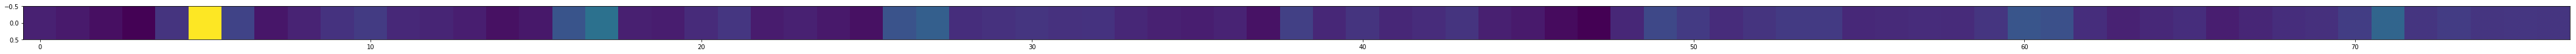

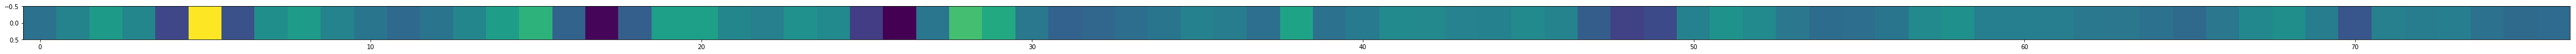

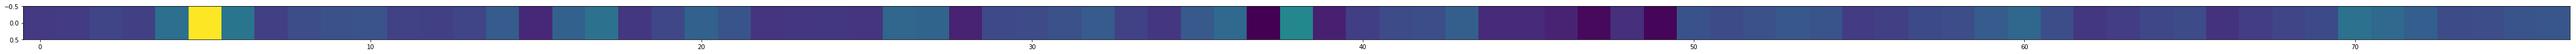

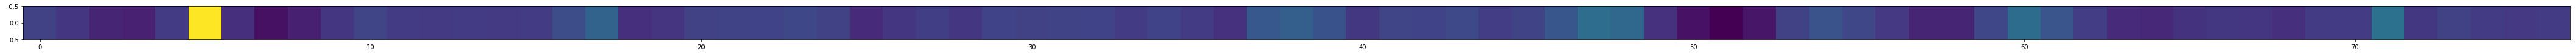

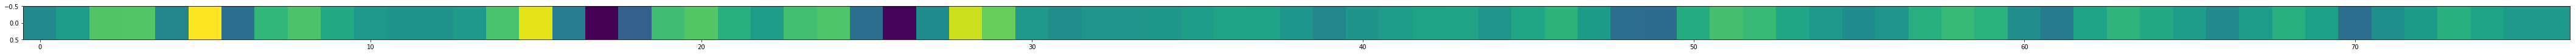

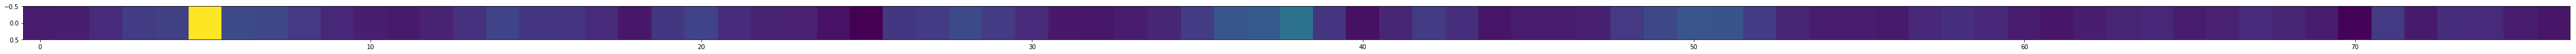

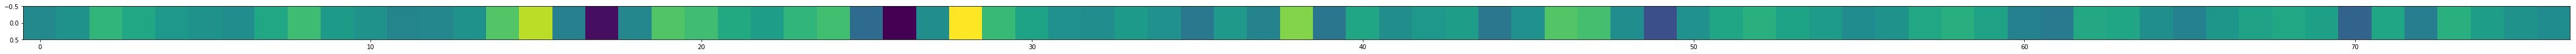

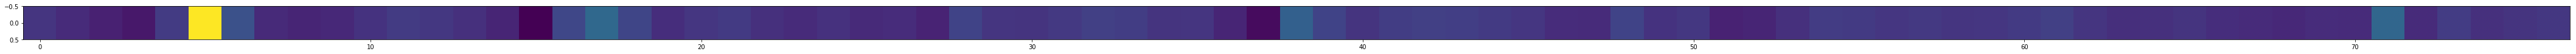

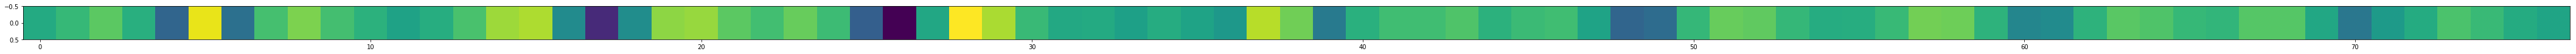

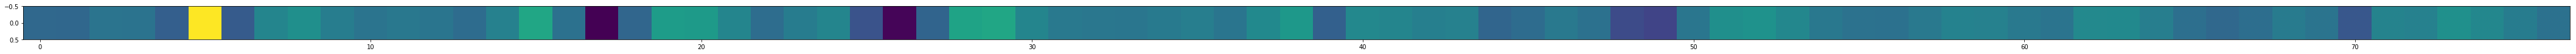

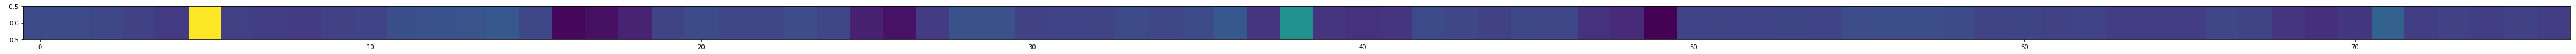

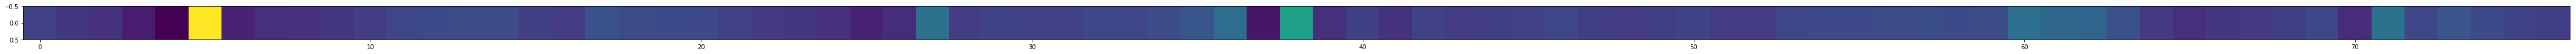

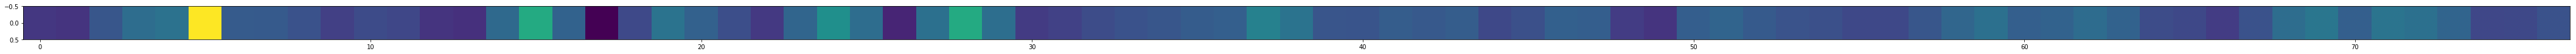

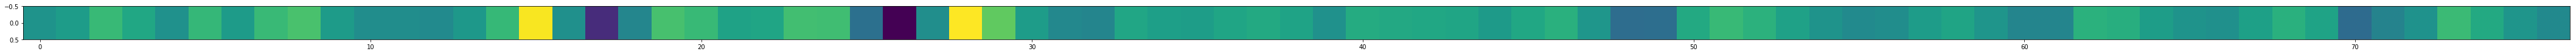

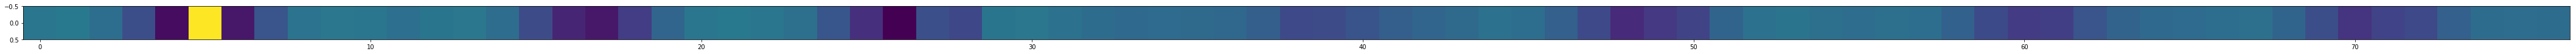

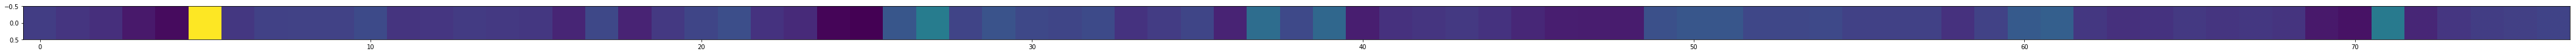

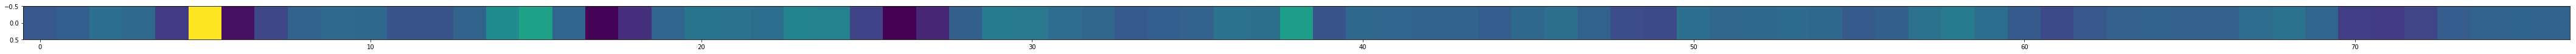

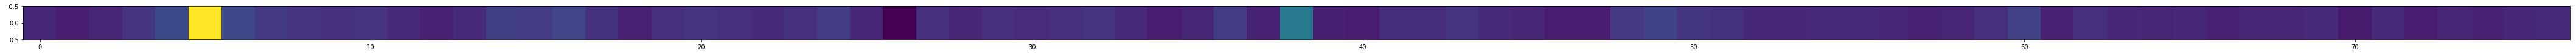

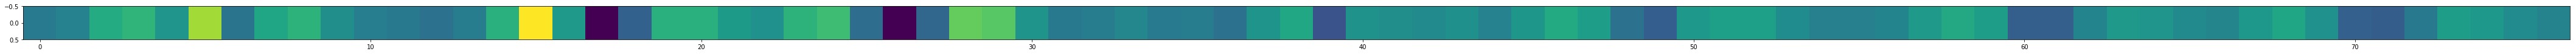

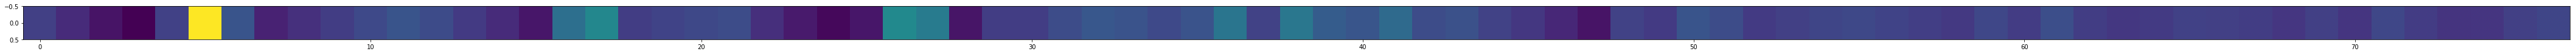

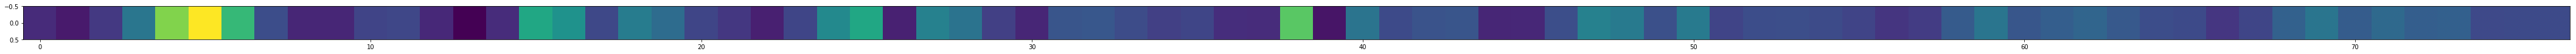

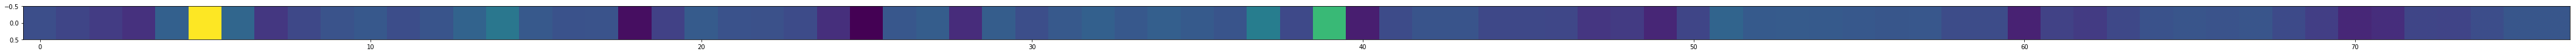

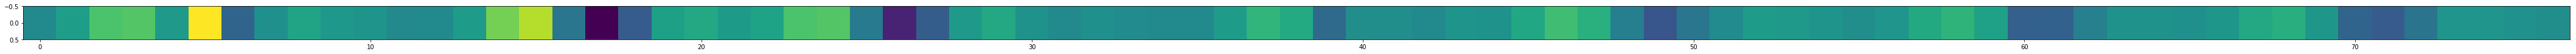

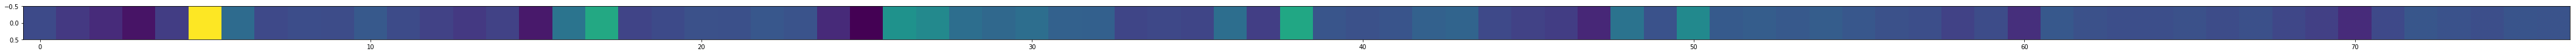

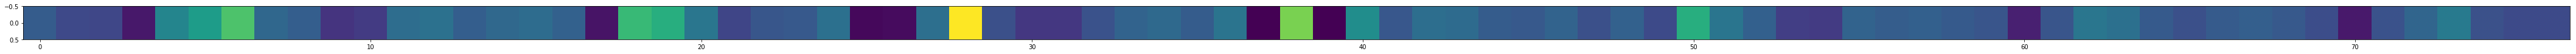

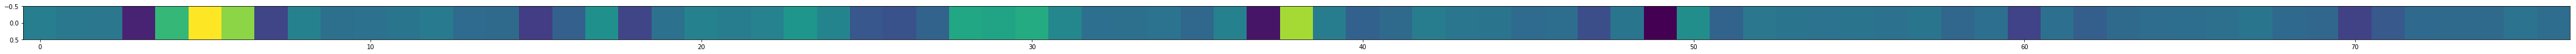

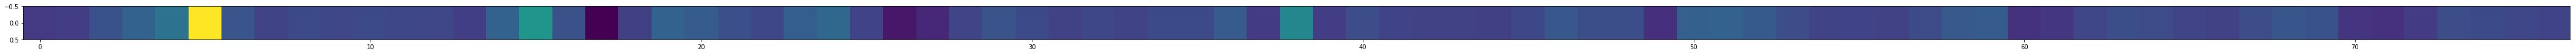

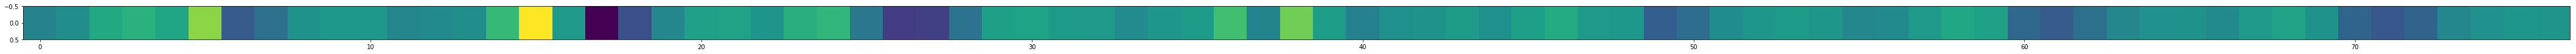

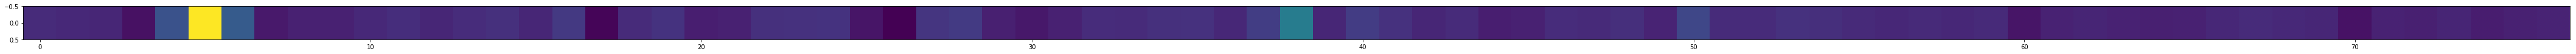

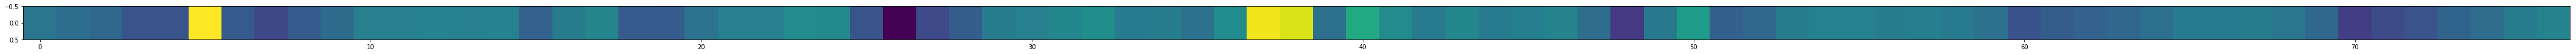

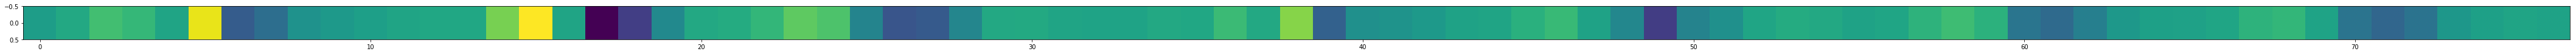

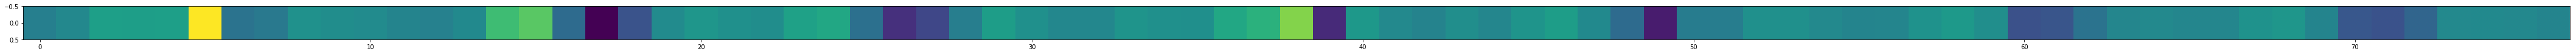

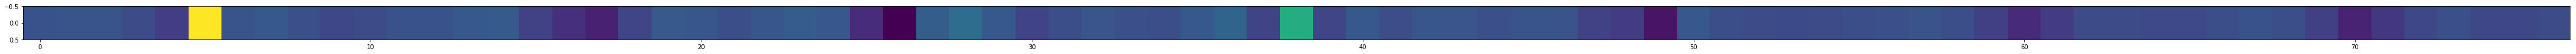

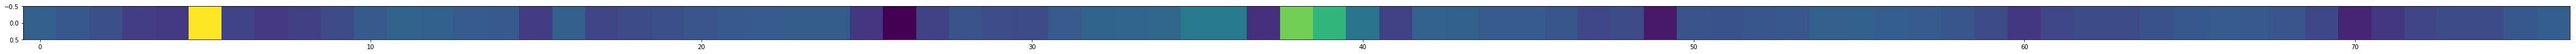

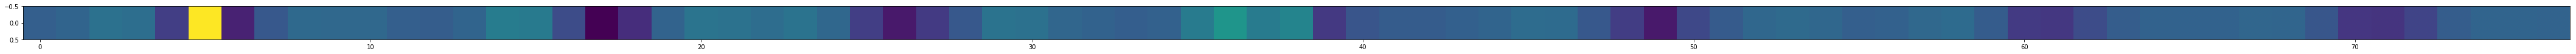

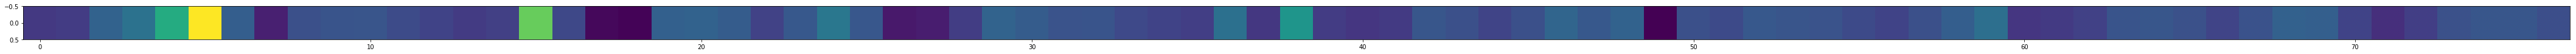

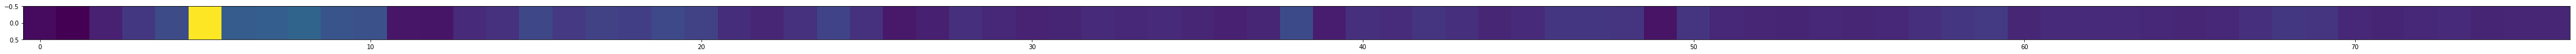

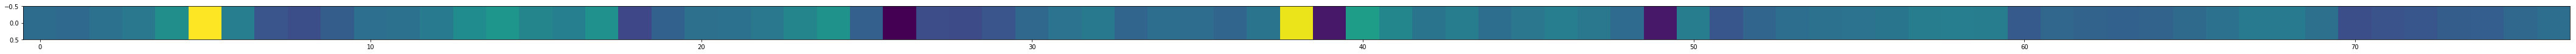

In [39]:
for m in mapping:
    plt.figure(figsize=(100, 1))
    plt.imshow(m.T)

## Enforce Toeplitz

Make the optimal mapping a toeplitz matrix, by going through every 51 x 51 (waveform length) non-overlapping window and taking the mean accross diagonals.

In [40]:
# mapping_toeplitz = {}

# for channel, a_mapping in mapping.items():
#     mapping_toeplitz[channel] = slice_transformation(a_mapping, make_toeplitz, offset=FILTER_LENGTH)

In [41]:
# for ch, a_mapping in mapping_toeplitz.items():
#     plt.matshow(a_mapping)
#     plt.suptitle(f'Toeplitz mapping for channel {ch}')

In [42]:
denoiser = mapping

In [43]:
# for ch, den in denoiser.items():
#     plt.matshow(den)
#     plt.suptitle(f'Mapping to use for channel {ch}. Toeplitz? {USE_TOEPLITZ}')

In [44]:
# denoised_full = denoiser.copy()

# middle = int((FILTER_LENGTH - 1) / 2)
# denoiser = {}

# # get only the filter for the middle observation
# # in the main channel
# for ch, den in denoised_full.items():
#     denoiser[ch] = den[[int(ch * FILTER_LENGTH + middle )], :].T

## Impulse response

In [45]:
def create_chunks(recordings, n_chunks, window_size, offset):
    chunks_all = []
    
    n_observations, n_channels = recordings.shape

    for i in range(n_chunks):
        start = i * offset
        end = i * offset + window_size
        
        if end > n_observations:
            end = n_observations

            if end - start == window_size:
                chunk = recordings[start:end, :]
                chunks_all.append(chunk)

            break
        else:
            chunk = recordings[start:end, :]
            chunks_all.append(chunk)
    
    return np.stack(chunks_all)

def denoise_chunks(chunks, mapping):
#     print('m',chunks.reshape(chunks.shape[0], -1).shape, mapping.shape)
    denoised = np.matmul(chunks.reshape(chunks.shape[0], -1), mapping).squeeze()
    return denoised

def unroll_chunks(chunks, mode='all'):
    unrolled =  chunks.reshape(-1, 7)
    
    if mode == 'all':
        return unrolled
    else:
        return unrolled[:, 0]

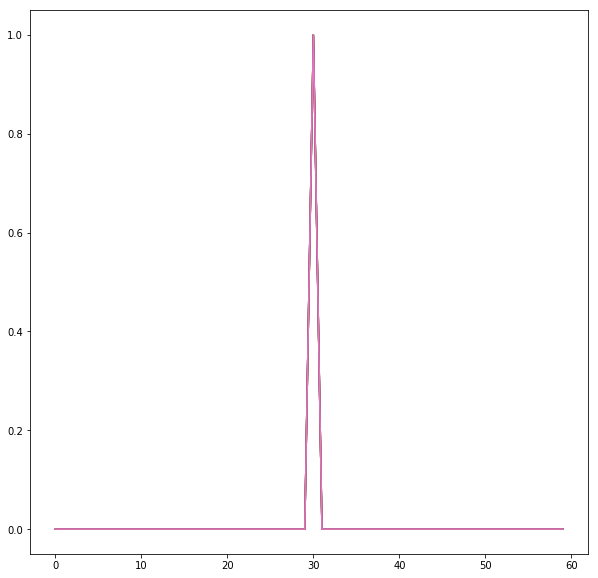

In [46]:
# impulse
impulse_length = 60
impulse = np.zeros((impulse_length, 7))
impulse[30, :] = 1
_ = plt.plot(impulse)

In [47]:
chunks = create_chunks(impulse, impulse_length, window_size=FILTER_LENGTH, offset=1)
# plot.grid_from_array(chunks, axis=0, auto_figsize=4)

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


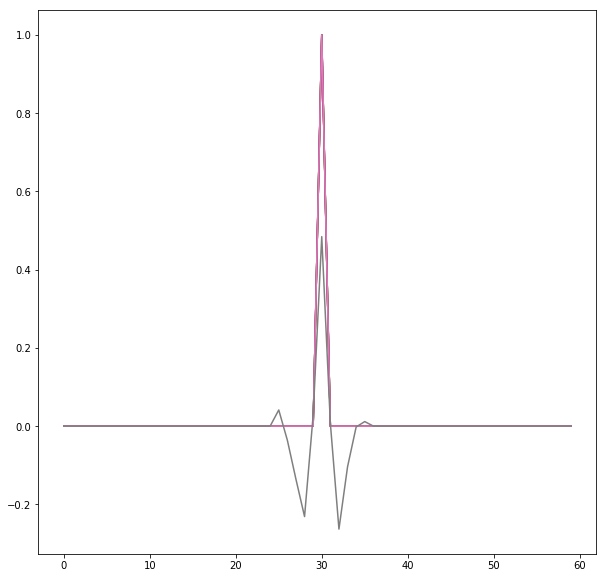

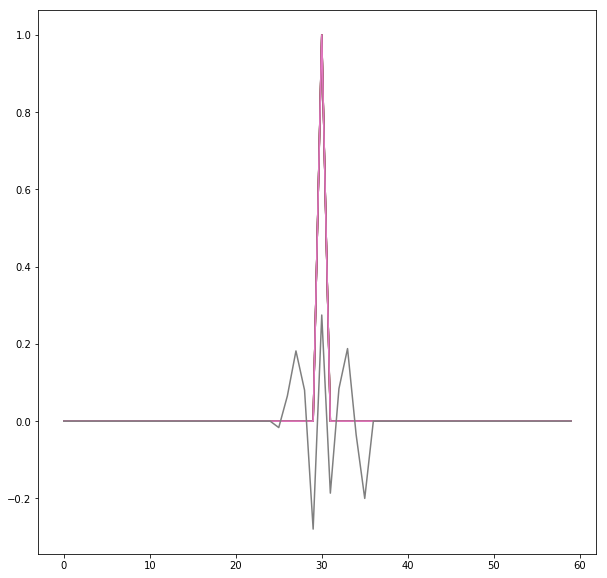

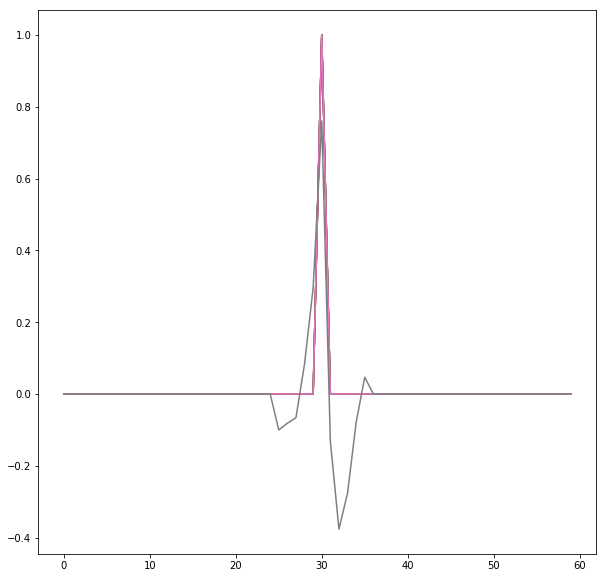

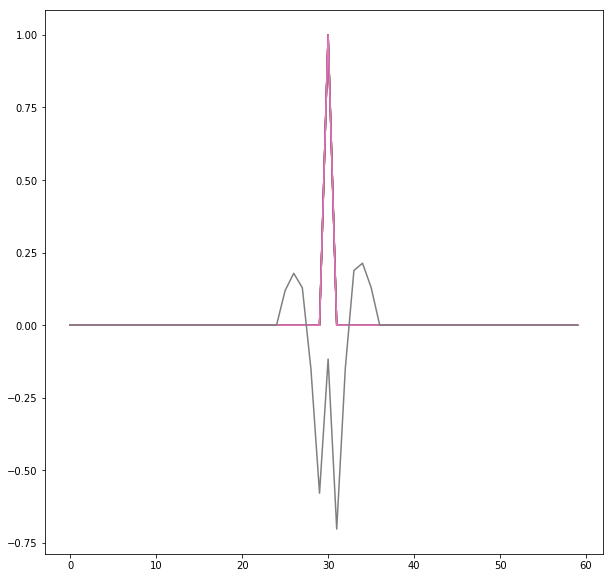

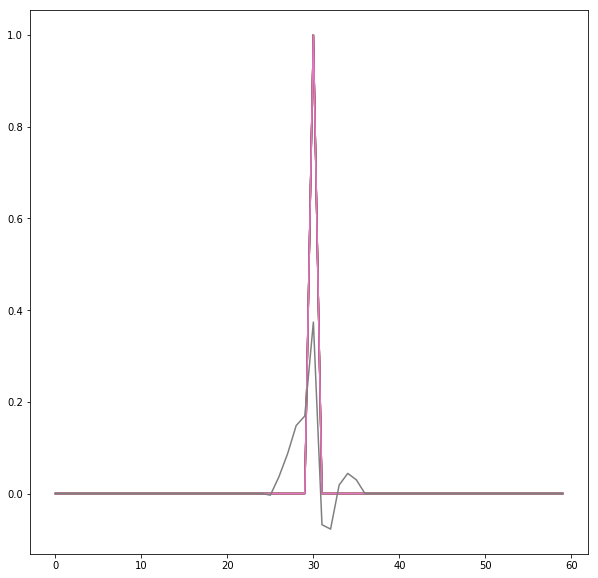

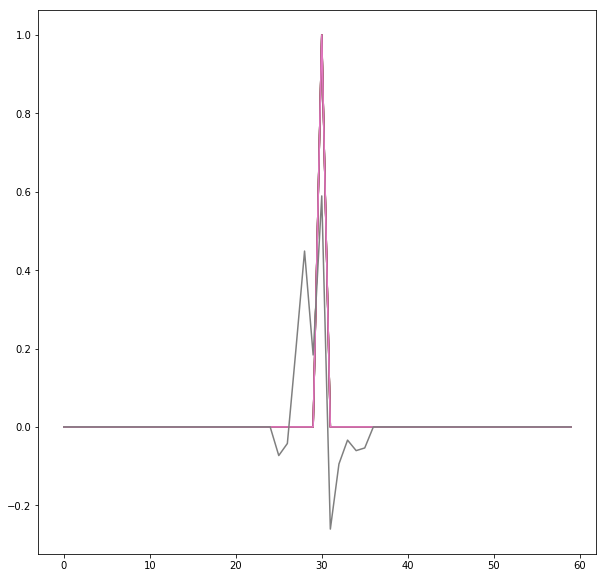

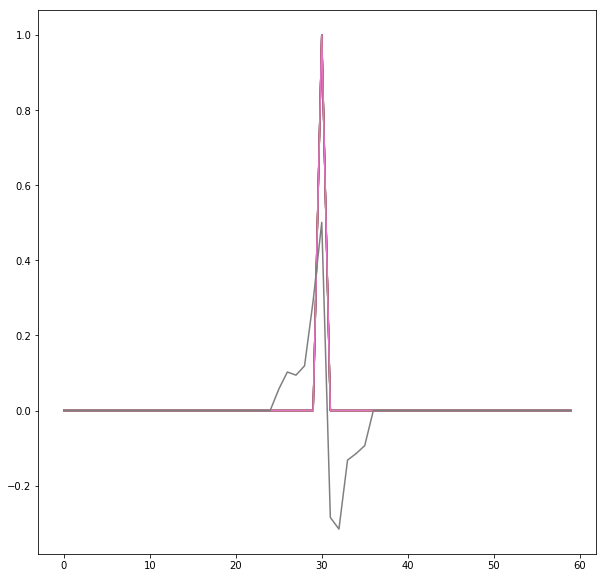

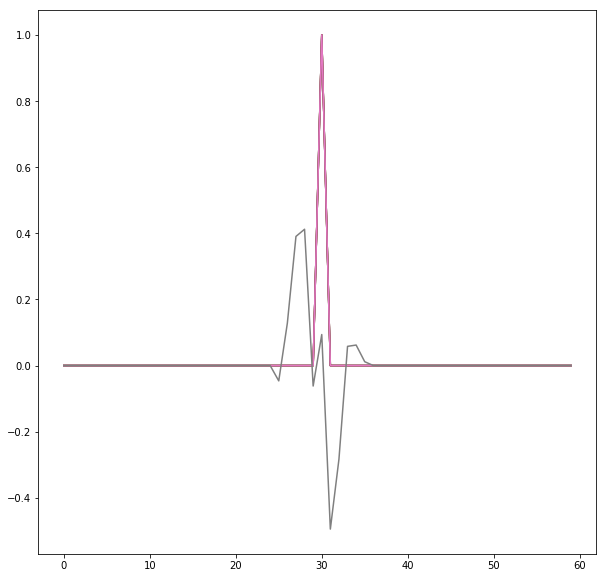

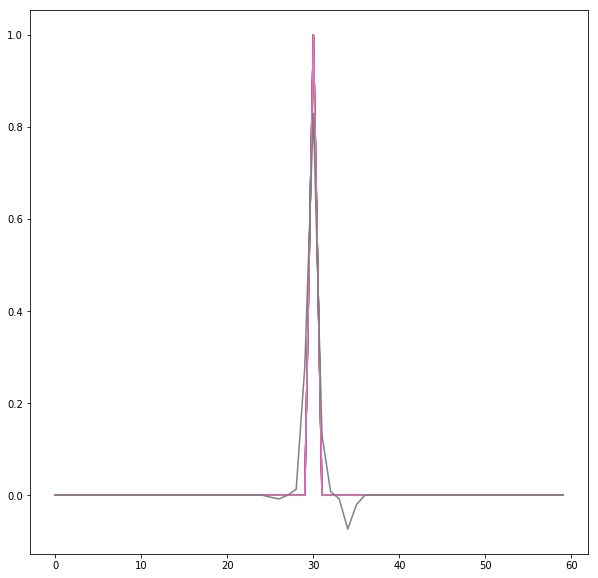

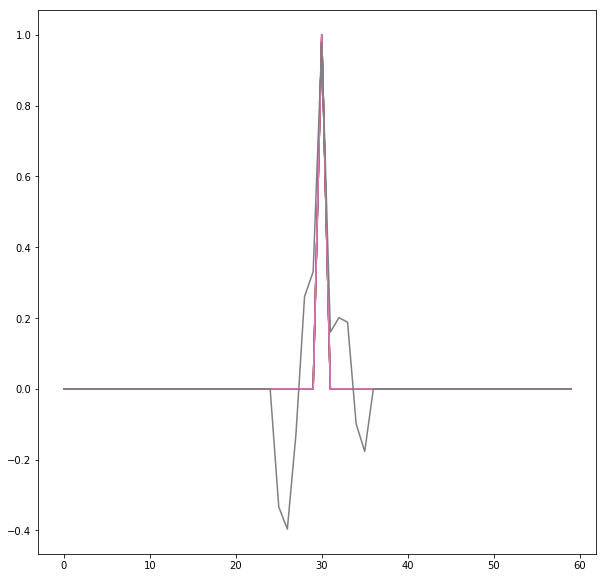

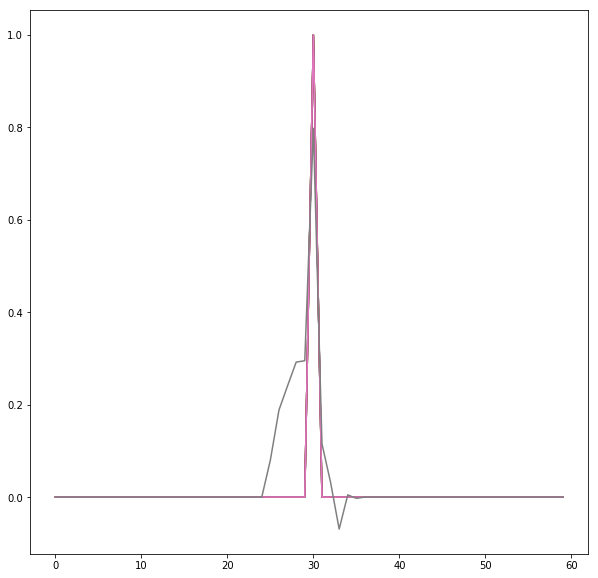

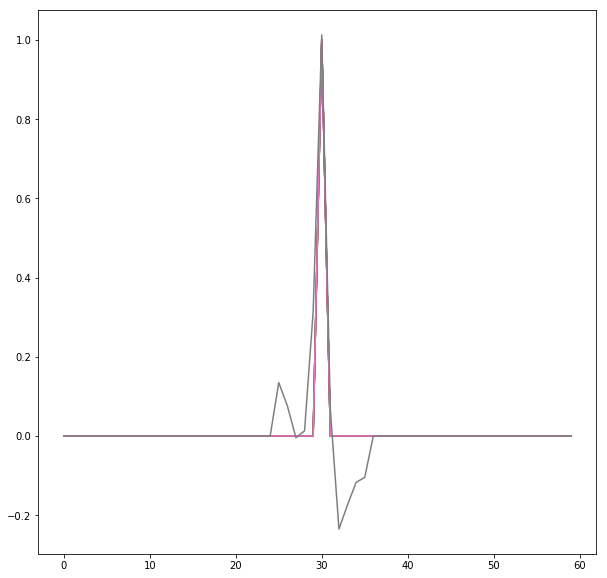

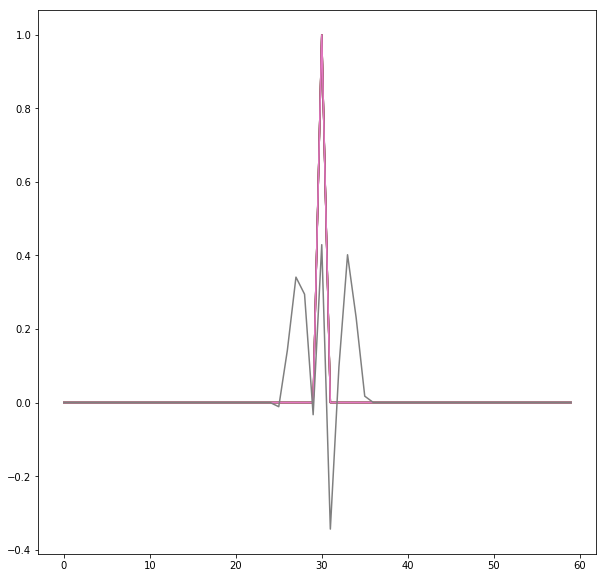

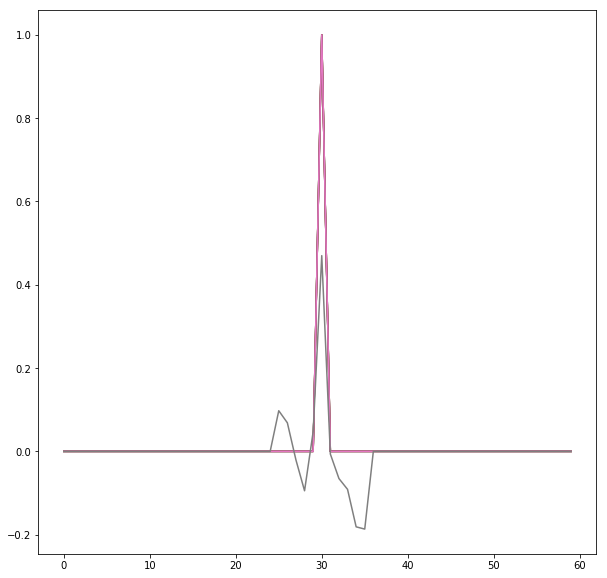

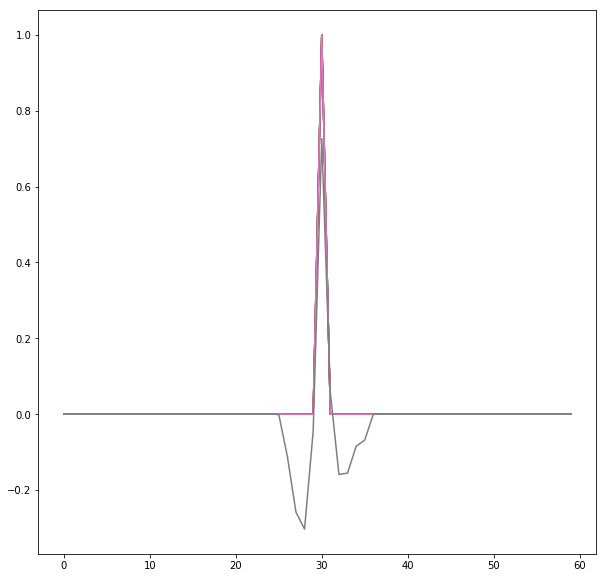

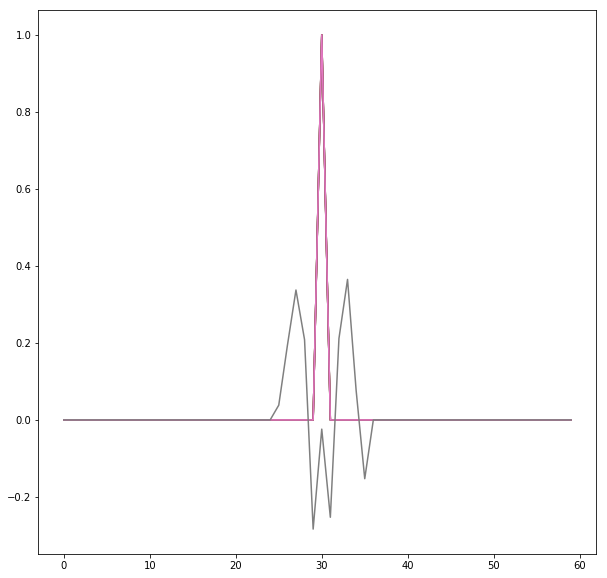

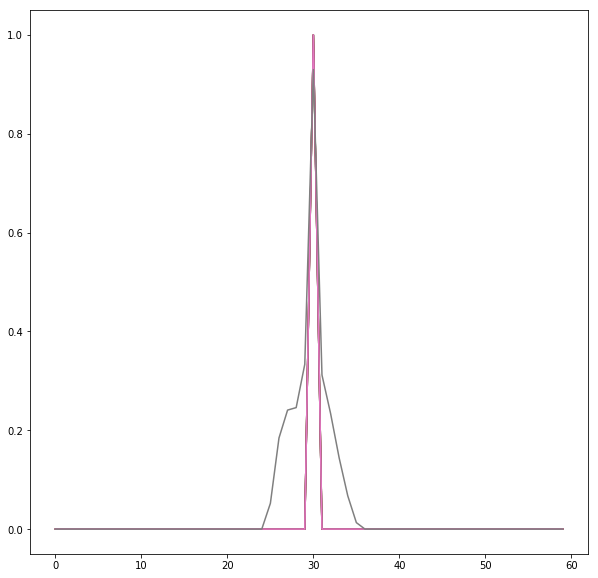

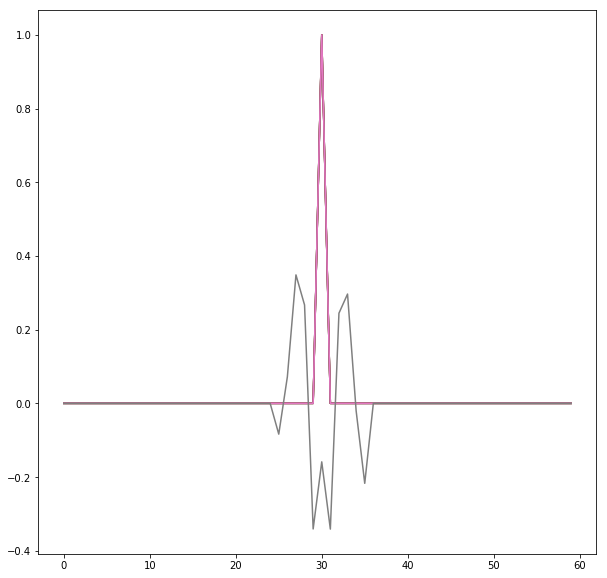

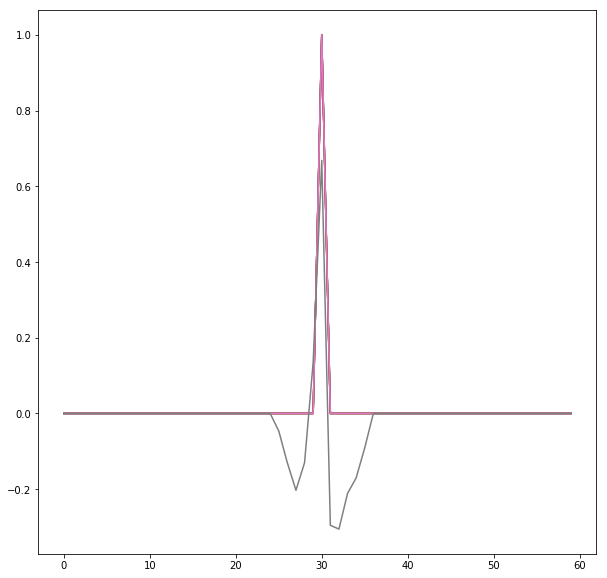

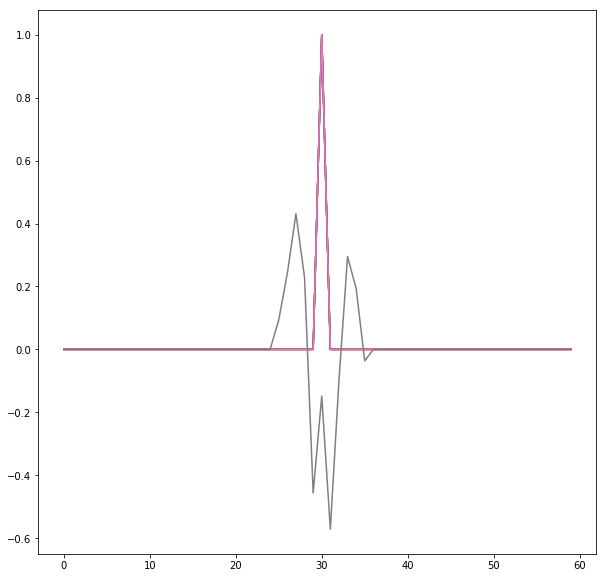

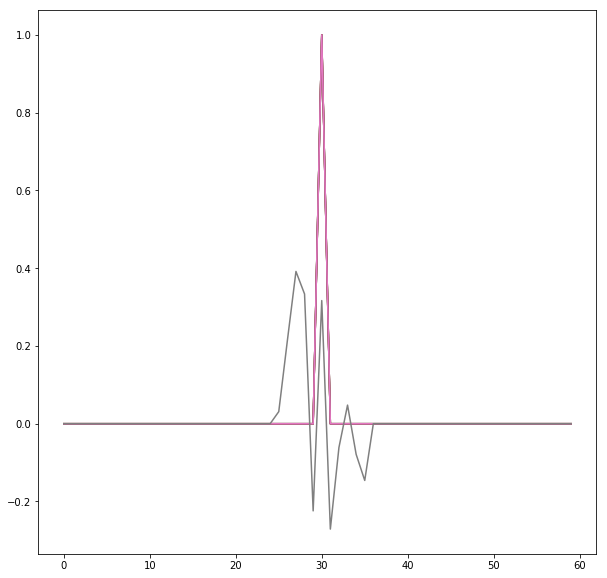

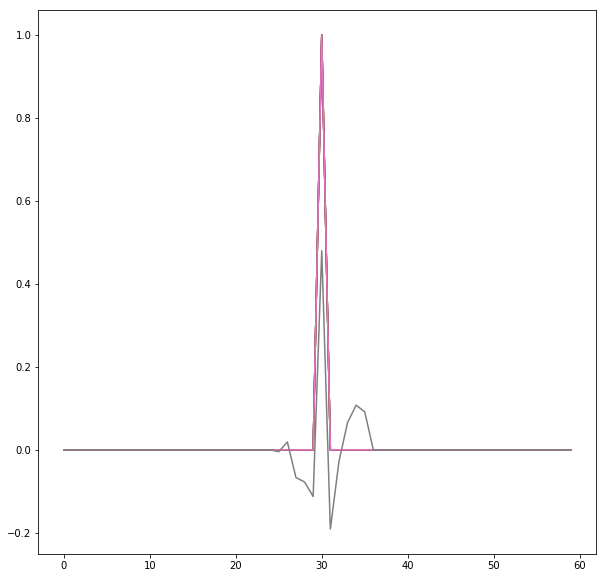

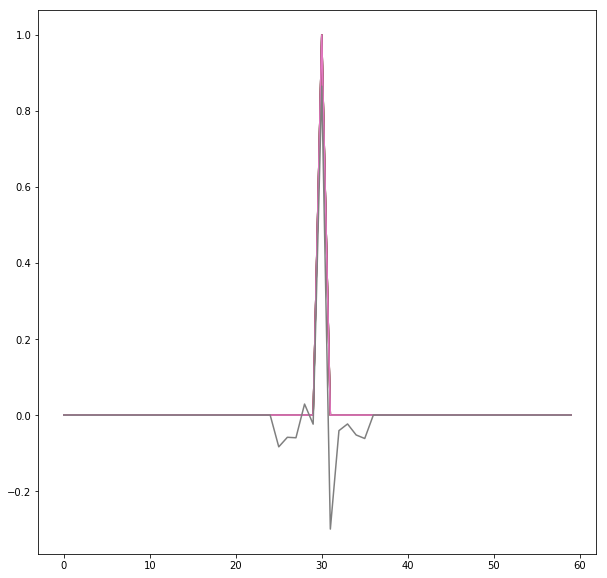

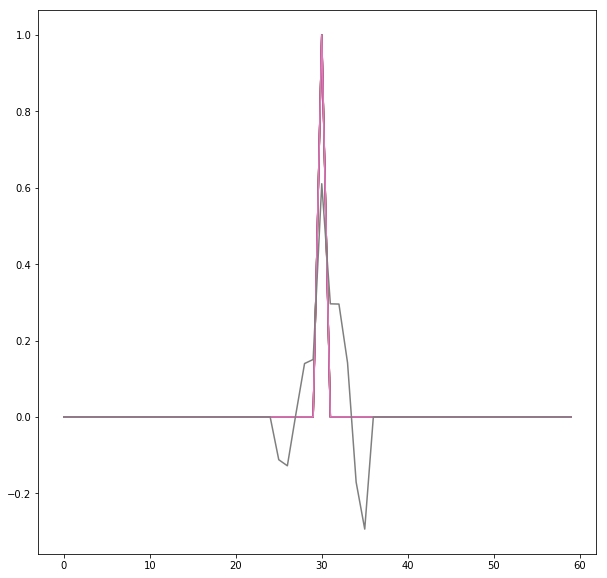

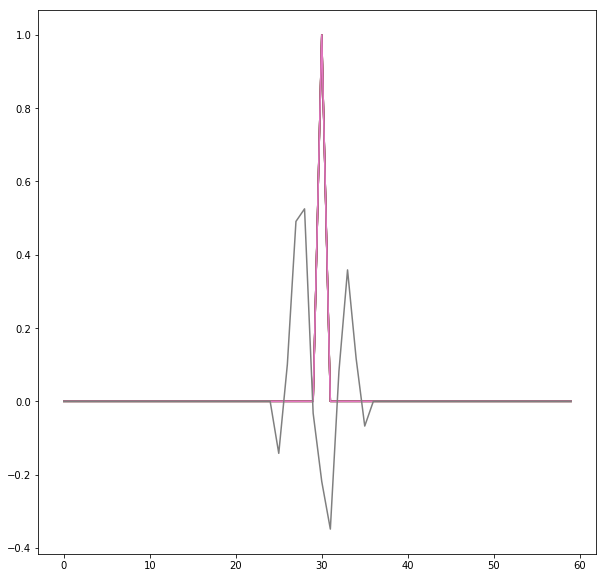

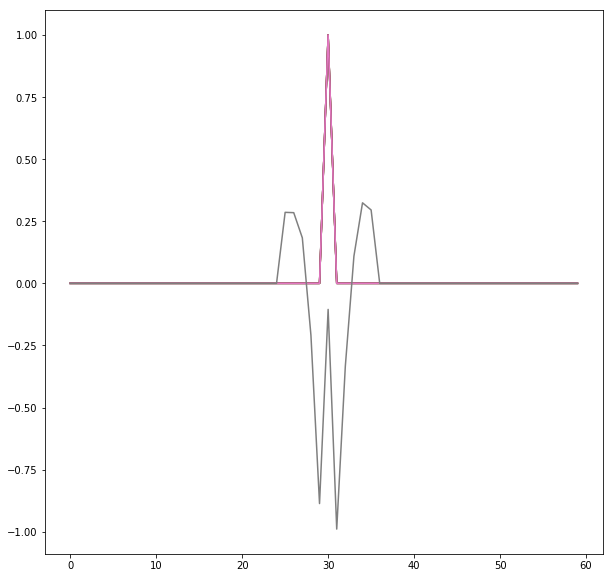

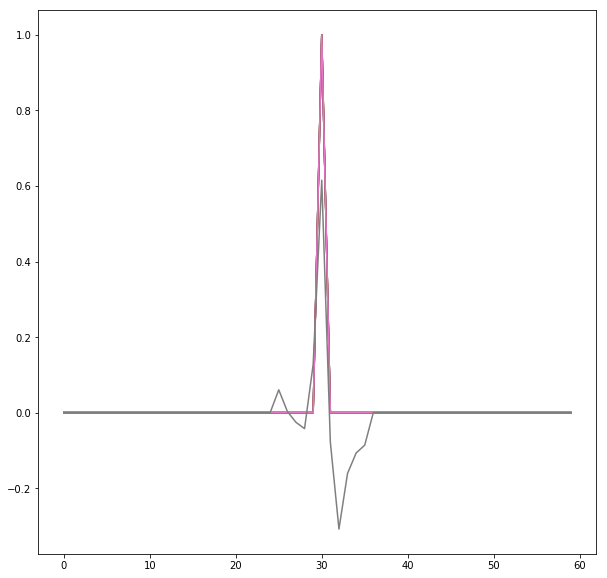

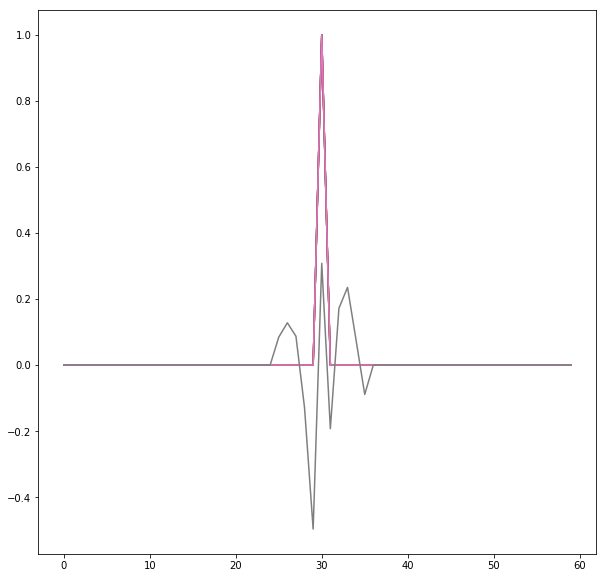

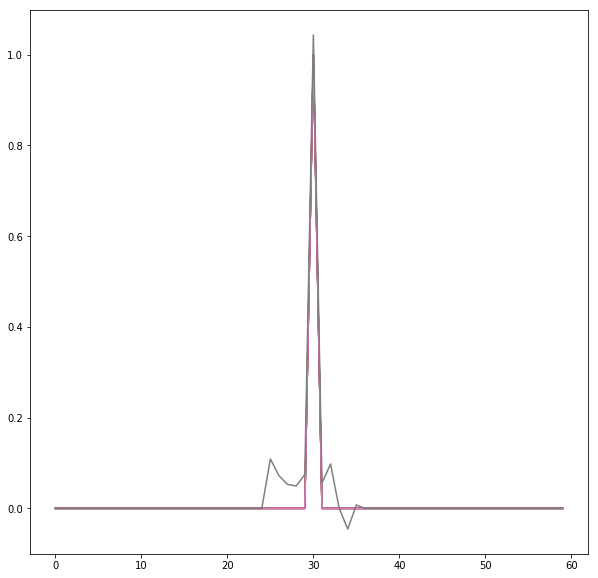

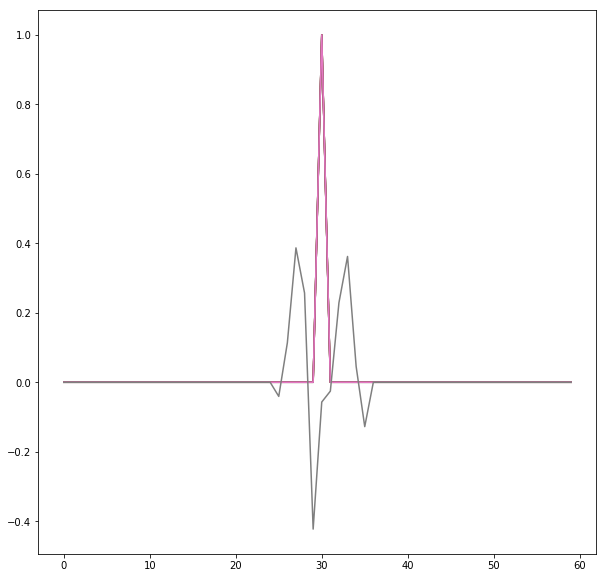

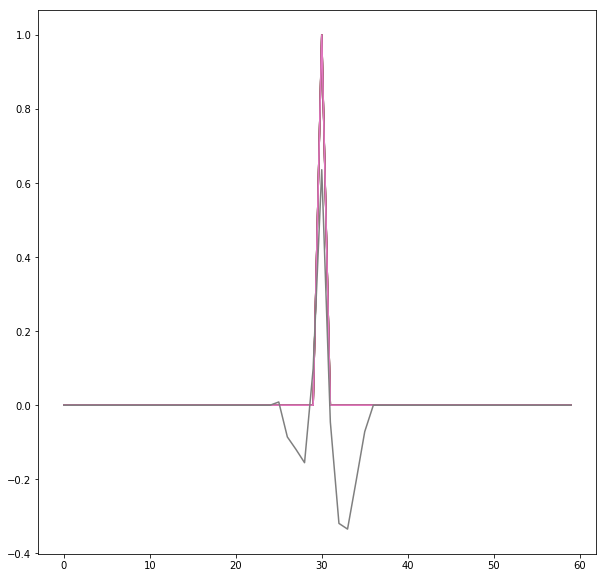

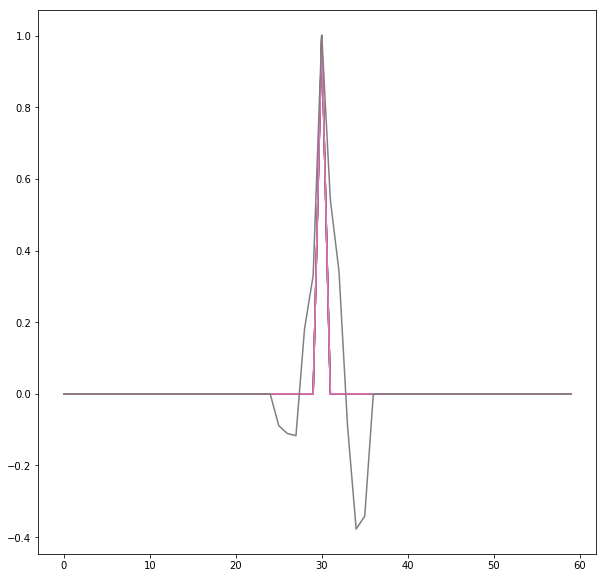

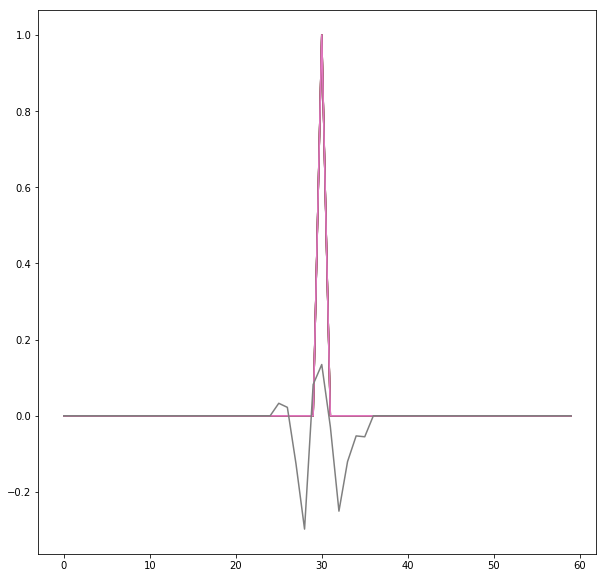

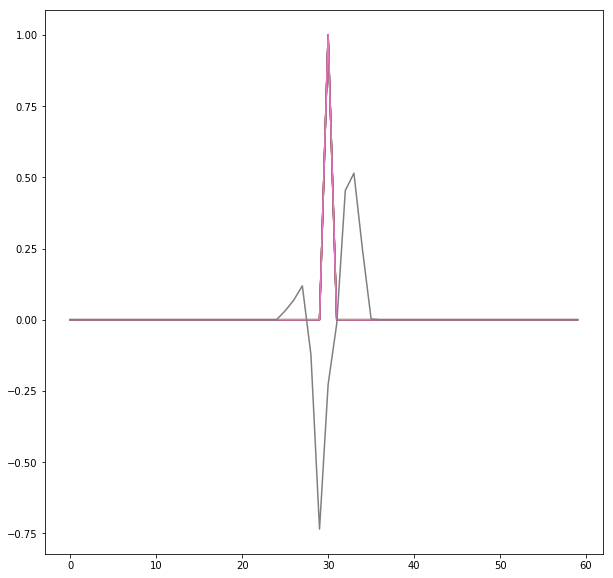

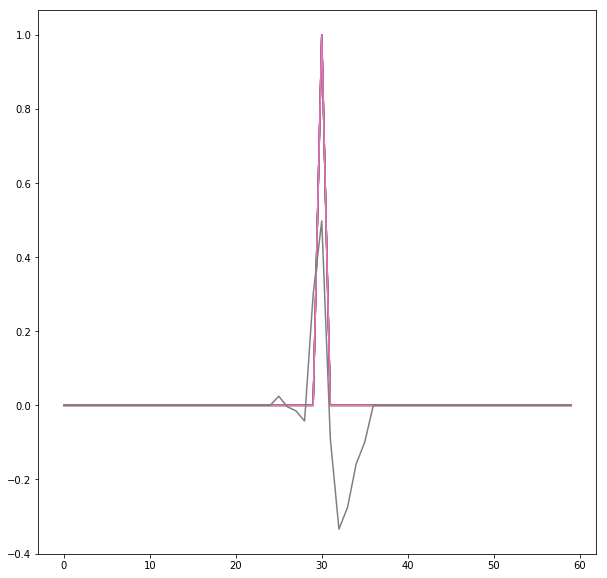

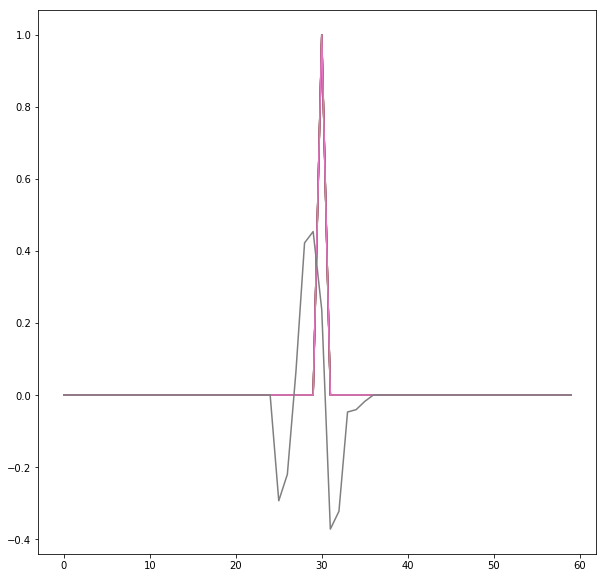

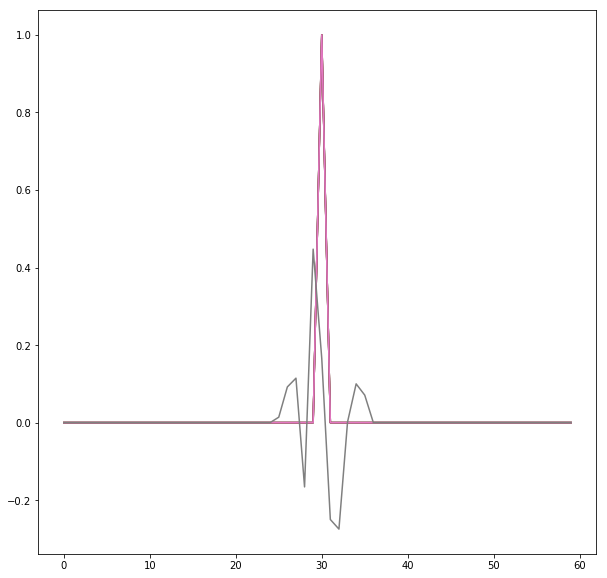

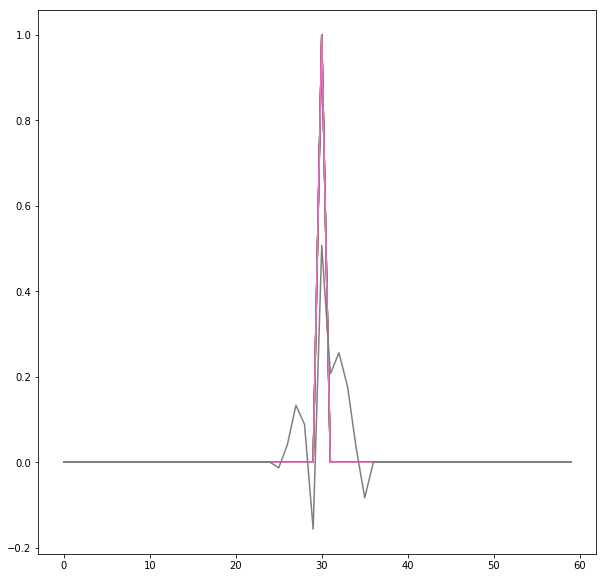

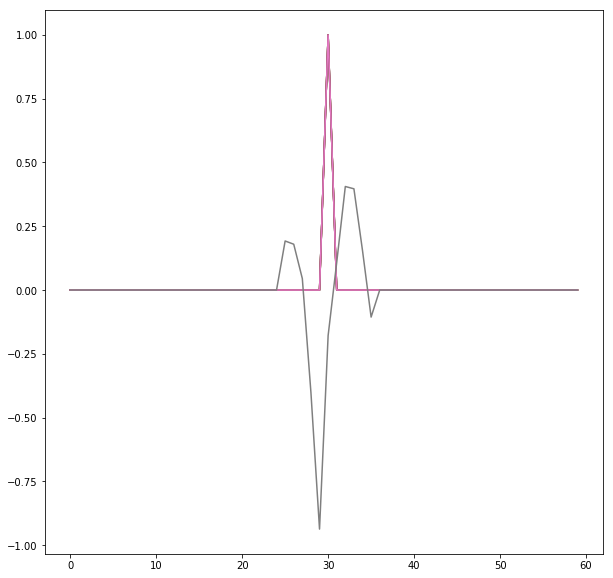

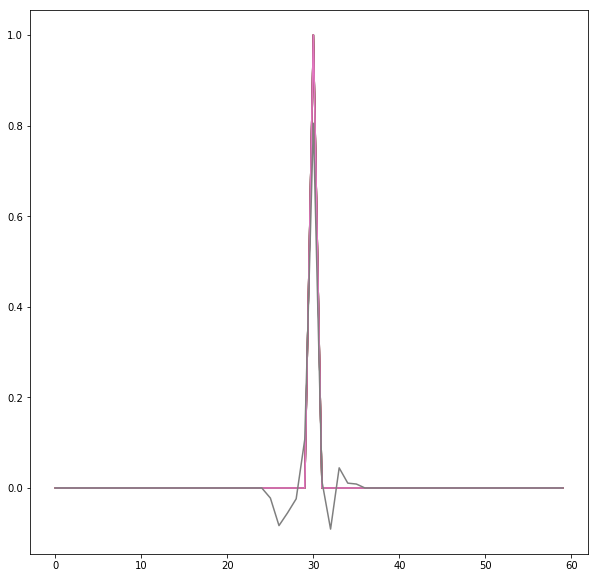

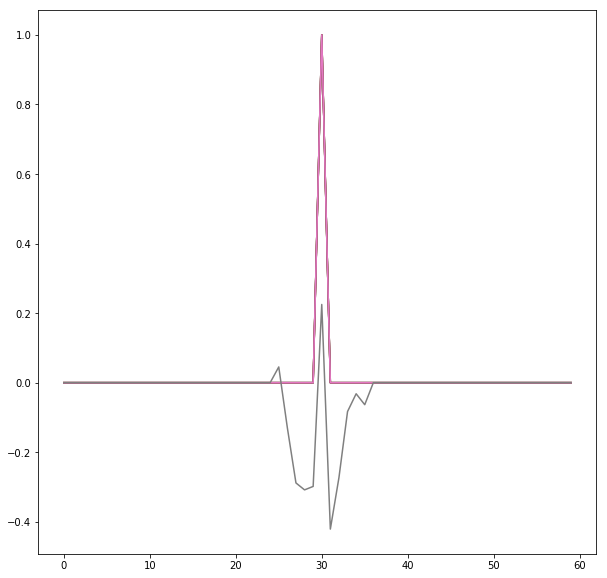

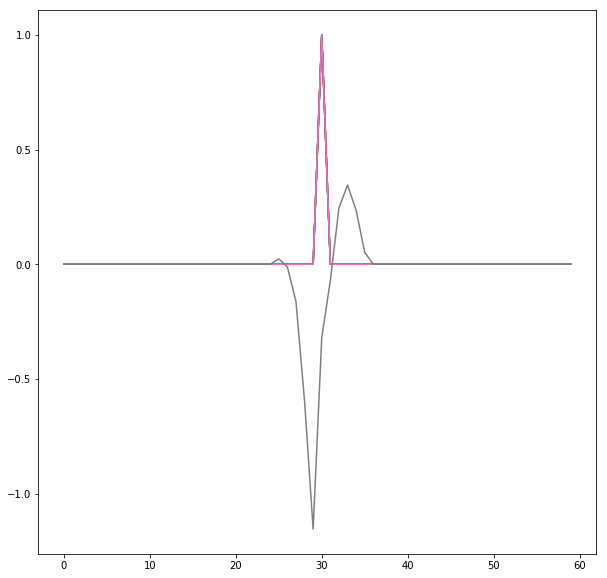

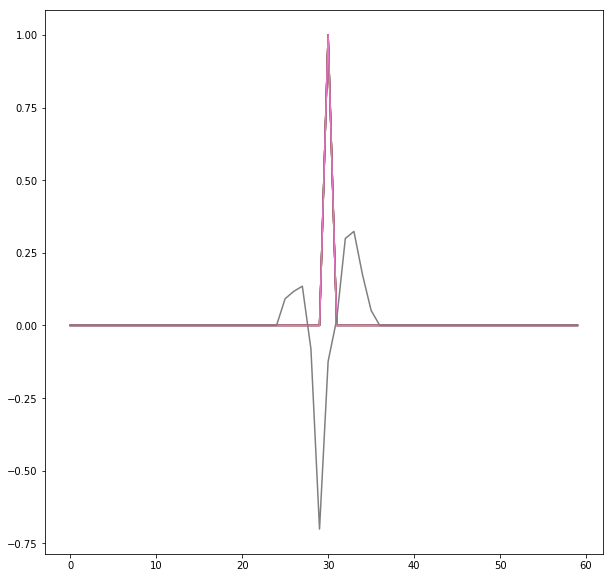

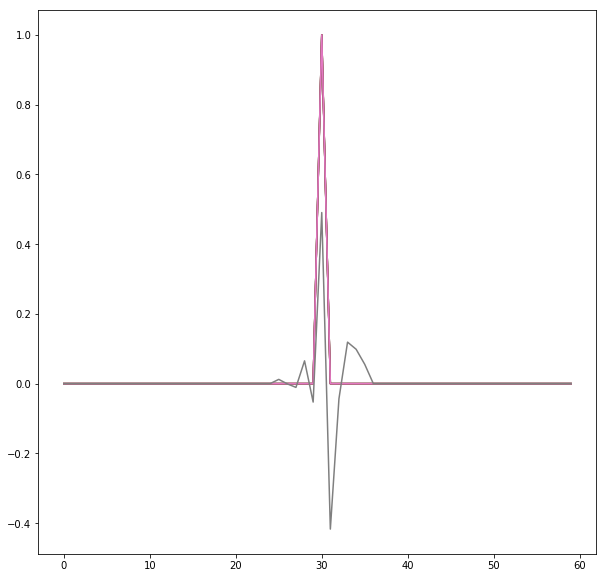

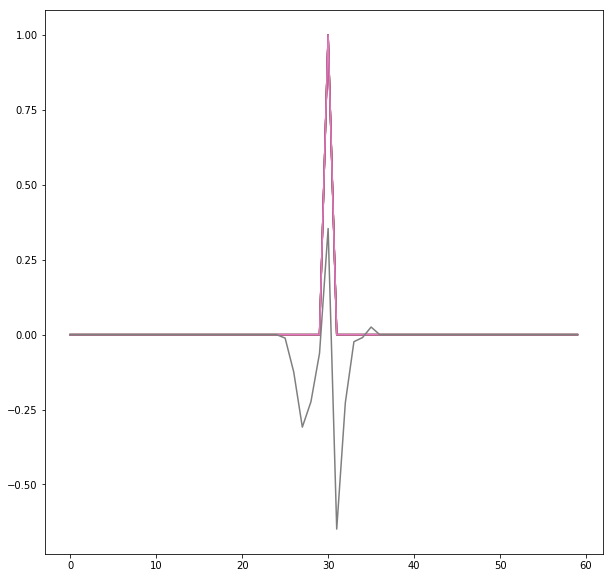

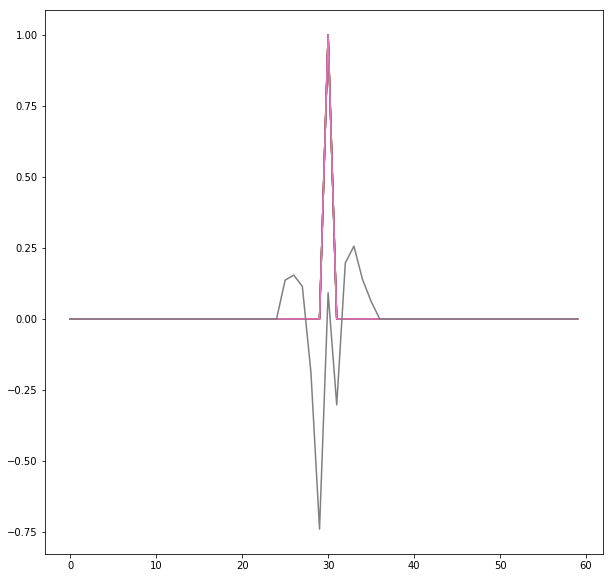

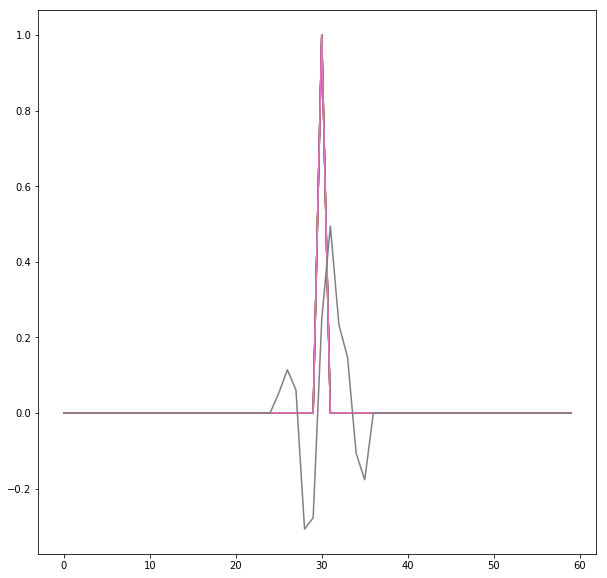

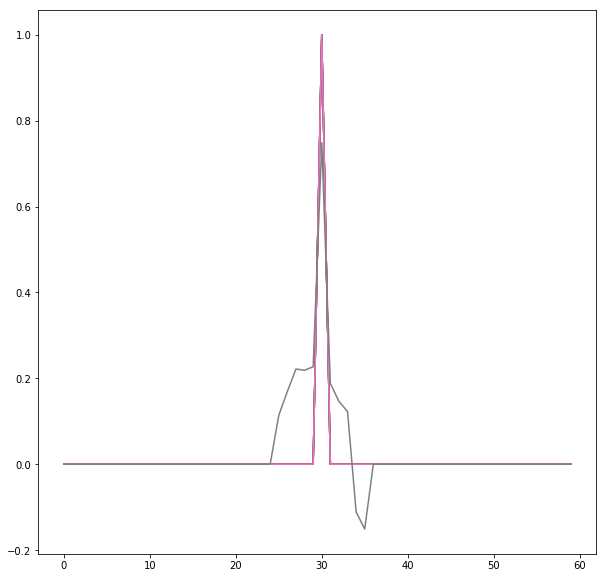

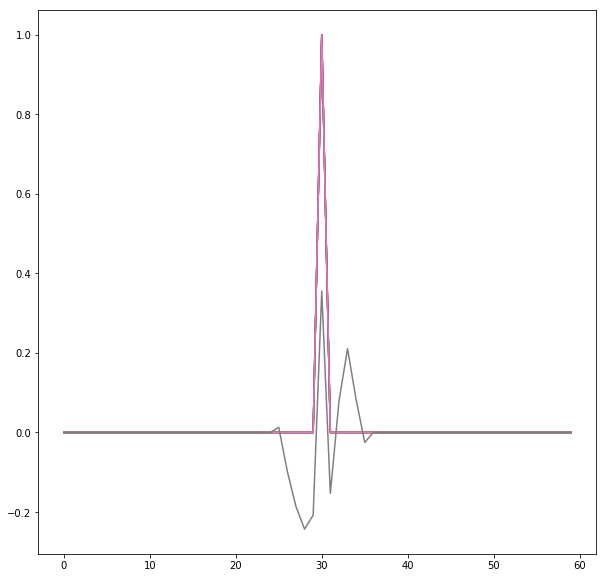

In [48]:
for a_denoiser in denoiser:
    impulse_denoised = denoise_chunks(chunks.transpose(0, 2, 1).reshape(chunks.shape[0], -1), a_denoiser).squeeze()
    # print(impulse.shape, chunks.shape, impulse_denoised.shape)

    padding = np.zeros(middle)
    
    plt.figure()
    plt.plot(impulse)
    _ = plt.plot(np.concatenate([padding, impulse_denoised, padding]))

In [49]:
# from os import path

# path_to_data = path.expanduser('~/data')
# raw_templates = np.load(Path(path_to_data, 'cat/templates-jul27-only-good.npy'))
# n_templates, waveform_length, _ = raw_templates.shape

# # crop spatially
# processor = TemplatesProcessor(raw_templates)
# templates = (processor
#             .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
#             .values)
# templates.shape

# ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
# selected_channels = ch_idx[0]
# selected_channels


# rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]

# from yass.augment.noise import noise_cov

# (spatial_sig,
#  temporal_sig) = noise_cov(rec, templates.shape[1], templates.shape[1])

In [50]:
# min_amplitude = 4
# max_amplitude = 10

# n_clean_per_template = 10

# n_positive_total = n_templates *  n_clean_per_template
# n_collided_per_spike = 0

# (X, y) = make.training_data_detect(templates=templates,
#                                     minimum_amplitude=min_amplitude,
#                                     maximum_amplitude=max_amplitude,
#                                     n_clean_per_template=n_clean_per_template,
#                                     n_collided_per_spike=n_collided_per_spike,
#                                     n_temporally_misaligned_per_spike=0,
#                                     n_noise=int(n_positive_total * 0.5),
#                                     n_spatially_misaliged_per_spike=0,
#                                     spatial_SIG=spatial_sig,
#                                     temporal_SIG=temporal_sig)

In [51]:
# noise = X[y == 0]
# noise_sample = noise[1000]
# _ = plt.plot(noise_sample)

# chunks = create_chunks(noise_sample, 1000, window_size=FILTER_LENGTH, offset=1)
# # plot.grid_from_array(chunks, axis=0, auto_figsize=4)

# noise_denoised = denoise_chunks(chunks.transpose(0, 2, 1).reshape(chunks.shape[0], -1), denoiser[0]).squeeze()

# padding = np.zeros(middle)

# plt.figure()
# plt.plot(noise_sample[:, 0])
# # plt.plot(noise_denoised)
# _ = plt.plot(np.concatenate([padding, noise_denoised, padding]))

## Denoise recordings

In [66]:
# FIXME: now that we are predicting just the observation in the middle we can make this way faster
from yass.preprocess.batch import standarize

n_chunks = rec_all.shape[0]
middle = int((FILTER_LENGTH - 1) / 2)
padding = np.zeros(middle)
# max_idx = rec.shape[0]

rec_denoised = []

# denoise recordings
for channel in CHANNELS:
    print(f'denoising channel {channel}...')
    chunks = create_chunks(rec_all[:, ch_idx[channel]], n_chunks, FILTER_LENGTH, offset=1)
    denoised = denoise_chunks(chunks, denoiser[channel]).astype(DTYPE)
    print(f're-scaling channel {channel}')
    stds = standarize._standard_deviation(denoised, CONFIG.recordings.sampling_rate)
    rescaled = np.divide(denoised, stds)
    padded = np.concatenate([padding, rescaled.squeeze(), padding])
    rec_denoised.append(denoised)

rec_denoised = np.stack(rec_denoised, axis=1)

denoising channel 0...
re-scaling channel 0
denoising channel 1...
re-scaling channel 1
denoising channel 2...
re-scaling channel 2
denoising channel 3...
re-scaling channel 3
denoising channel 4...
re-scaling channel 4
denoising channel 5...
re-scaling channel 5
denoising channel 6...
re-scaling channel 6
denoising channel 7...
re-scaling channel 7
denoising channel 8...
re-scaling channel 8
denoising channel 9...
re-scaling channel 9
denoising channel 10...
re-scaling channel 10
denoising channel 11...
re-scaling channel 11
denoising channel 12...
re-scaling channel 12
denoising channel 13...
re-scaling channel 13
denoising channel 14...
re-scaling channel 14
denoising channel 15...
re-scaling channel 15
denoising channel 16...
re-scaling channel 16
denoising channel 17...
re-scaling channel 17
denoising channel 18...
re-scaling channel 18
denoising channel 19...
re-scaling channel 19
denoising channel 20...
re-scaling channel 20
denoising channel 21...
re-scaling channel 21
denoisin

## Visualize recordings

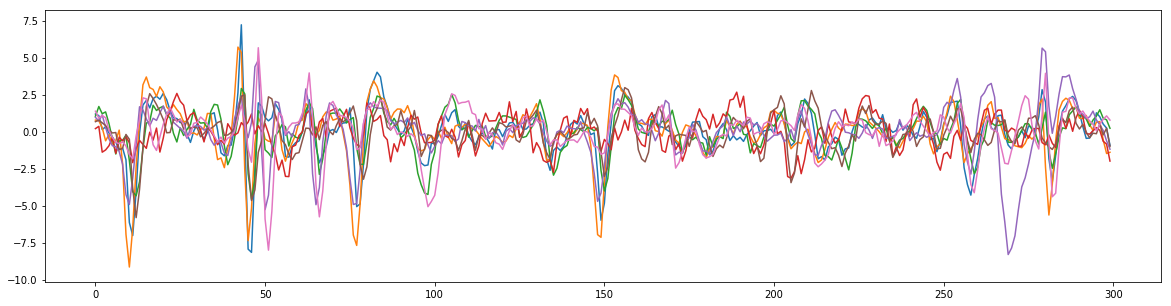

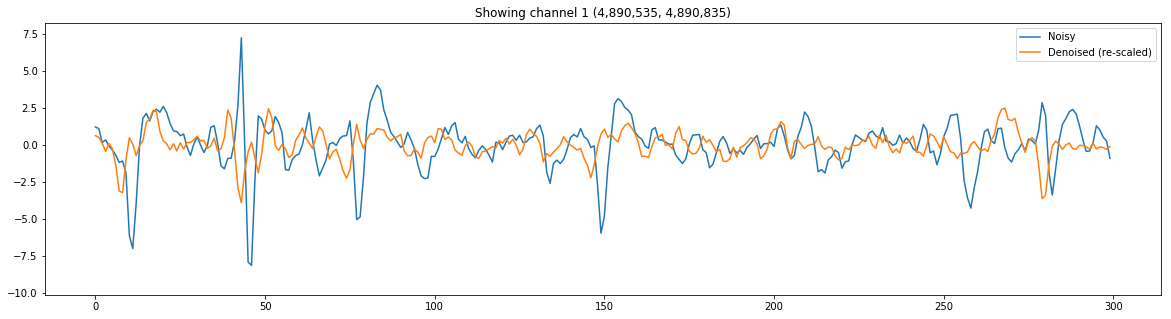

In [73]:
channel = np.random.choice(CHANNELS)
t = np.random.randint(rec_all.shape[0])

# channel = 4
# t = 10
size = 300

s = slice(t, t+size)

plt.rcParams['figure.figsize'] = (20, 5)

# if denoise_mode == 'all':
#     plt.plot(rec_denoised[channel][s, 0], label='Denoised (re-scaled)')
# elif denoise_mode == 'main':
#     plt.plot(rec_denoised[0][s, channel], label='Denoised (re-scaled)')

y_min = rec_all[s, ch_idx[channel]].min() - 1
y_max = rec_all[s, ch_idx[channel]].max() + 1

plt.ylim(y_min, y_max)
plt.plot(rec_all[s, ch_idx[channel]], label='Noisy')

plt.figure()
plt.ylim(y_min, y_max)
plt.plot(rec_all[s, channel], label='Noisy')
plt.plot(rec_denoised[s, channel], label='Denoised (re-scaled)')
plt.title(f'Showing channel {channel} ({t:,}, {t+size:,})')
plt.legend()

## Visualize spikes in raw vs denoised

In [74]:
n_snippets = 9
max_ptp = 40

# def make_random_slice(n_obs, length=200):
#     max_idx = n_obs - length
#     start = np.random.randint(max_idx)
#     s = slice(start, start + length)
#     return s

def make_slices(times, n_snippets=4, length=FILTER_LENGTH):
    length_half = int((length - 1)/2)
    times_selected = np.random.choice(times, size=4)
    s = [slice(t -  length_half, t + length_half) for t in times_selected]
    return s

# slices = [make_random_slice(rec_all.shape[0]) for _ in range(n_snippets)]

def load_slice(s, ch, rec_all, ch_idx, rec_denoised):
    if denoise_mode == 'all':
        # get denoised recs for the given channel        
        raw = rec_all[s, ch_idx[ch]]
        # get slice from raw recordings but only in selected channels
        denoised = rec_denoised[ch][s]
    else:
        raw = rec_all[s, [ch]]
        denoised = rec_denoised[0][s, [ch]]
    
    return raw, denoised

# for ch in CHANNELS:
#     snippets = [load_slice(s, ch, rec_all, ch_idx, rec_denoised) for s in slices]
#     raw, denoised = zip(*snippets)
#     raw = np.stack(raw, axis=0)
#     denoised = np.stack(denoised, axis=0)
    
#     plot.grid_from_array([raw, denoised], axis=0, group_names=['Raw', 'Denoised'],
#                      sharey='row')
#     _ = plt.suptitle(f'Raw vs Denoised snippet for main channel {ch}')
#     plt.tight_layout(pad=3)

for ch in [0]:#CHANNELS:
    times_all = indexes_raw.all.get_times_from_channel(ch, max_ptp=max_ptp,
                                                       rec=rec_all[:, ch_idx[ch]])

    slices = make_slices(times_all, n_snippets=n_snippets, length=51)

    snippets = [load_slice(s, ch, rec_all, ch_idx, rec_denoised) for s in slices]

    raw, denoised = zip(*snippets)

    raw = np.stack(raw, axis=0)

    denoised = np.stack(denoised, axis=0)
    
    plot.grid_from_array([raw, denoised], axis=0, group_names=['Raw', 'Denoised'],
                     sharey='row', auto_figsize=4)
    _ = plt.suptitle(f'Raw vs Denoised spike for main channel {ch} - times randomly sampled from spike index '
                     f'from raw data with max ptp {max_ptp}')
    plt.tight_layout(pad=4)

IndexError: too many indices for array

## Dump denoised data

In [81]:
path = f'/tmp/denoised.bin'
print(f'Dumping denoised data for channels {CHANNELS} in {path}')
rec_denoised.tofile(path)

Dumping denoised data for channels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48] in /tmp/denoised.bin


## Compare distribution of PTPs

In [82]:
params = {'data_order': 'samples', 'dtype': DTYPE, 'n_channels': 49}

(index_clean_arr_denoised,
 index_all_arr_denoised) = nnet.run('/tmp/denoised.bin', params, whiten_filter,
                       'overwrite', False,
                        path_to_detector,
                        autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt',
                        triage=None)

100%|██████████| 2298/2298 [00:20<00:00, 114.39it/s]


In [83]:
standarized_path_denoised = '/tmp/denoised.bin'
rec_denoised = RecordingsReader(standarized_path_denoised, params['dtype'],
                                params['n_channels'],
                                params['data_order'],
                                loader='array').data

rec_denoised = np.concatenate([rec_denoised, np.zeros((rec_denoised.shape[0], 1))], axis=1).astype(DTYPE)

In [84]:
# remove spikes at the beginning and end to avoid shifting and incomplete waveform issues
index_clean_arr_denoised = index_clean_arr_denoised[index_clean_arr_denoised[:, 0] > 150]
index_all_arr_denoised = index_all_arr_denoised[index_all_arr_denoised[:, 0] > 150]

all_denoised = lib.SpikeIndex(index_all_arr_denoised, ch_idx, CONFIG.geom, CONFIG.neigh_channels)
clean_denoised = lib.SpikeIndex(index_clean_arr_denoised, ch_idx, CONFIG.geom, CONFIG.neigh_channels)

indexes_denoised = SpikeIndexes(clean=clean_denoised, all=all_denoised)

In [85]:
indexes_denoised.all.arr.shape, indexes_raw.all.arr.shape

((204128, 2), (410082, 2))

In [87]:
for ch in CHANNELS:
    n_denoised = len(indexes_denoised.all.get_times_from_channel(ch))
    n_raw = len(indexes_raw.all.get_times_from_channel(ch))
    
    print(f'* Channel: {ch} - {n_denoised / (n_raw + 0.0001):.2f}x - {n_denoised:,} {n_raw:,} ')

* Channel: 0 - 0.26x - 1,430 5,501 
* Channel: 1 - 0.11x - 1,270 11,338 
* Channel: 2 - 0.68x - 2,699 3,950 
* Channel: 3 - 146.57x - 6,156 42 
* Channel: 4 - 0.23x - 936 4,144 
* Channel: 5 - 0.33x - 2,618 7,858 
* Channel: 6 - 4.28x - 8,518 1,989 
* Channel: 7 - 5.70x - 9,343 1,639 
* Channel: 8 - 2.55x - 9,427 3,699 
* Channel: 9 - 0.29x - 2,302 8,025 
* Channel: 10 - 2.05x - 15,326 7,477 
* Channel: 11 - 0.04x - 300 6,986 
* Channel: 12 - 0.78x - 4,332 5,584 
* Channel: 13 - 1.72x - 8,186 4,758 
* Channel: 14 - 1.09x - 2,976 2,727 
* Channel: 15 - 0.23x - 2,098 9,279 
* Channel: 16 - 4.28x - 23,881 5,581 
* Channel: 17 - 0.28x - 2,486 8,835 
* Channel: 18 - 2.29x - 8,224 3,594 
* Channel: 19 - 0.16x - 1,787 10,999 
* Channel: 20 - 0.24x - 1,843 7,532 
* Channel: 21 - 0.75x - 5,420 7,183 
* Channel: 22 - 0.57x - 2,300 4,043 
* Channel: 23 - 0.00x - 20 7,536 
* Channel: 24 - 0.51x - 6,674 12,960 
* Channel: 25 - 139130000.00x - 13,913 0 
* Channel: 26 - 0.77x - 2,780 3,597 
* Channel

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/Edu/miniconda3/envs

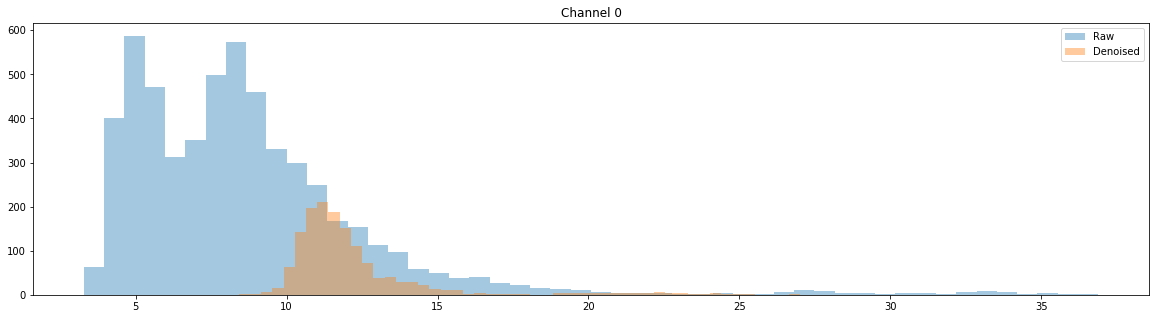

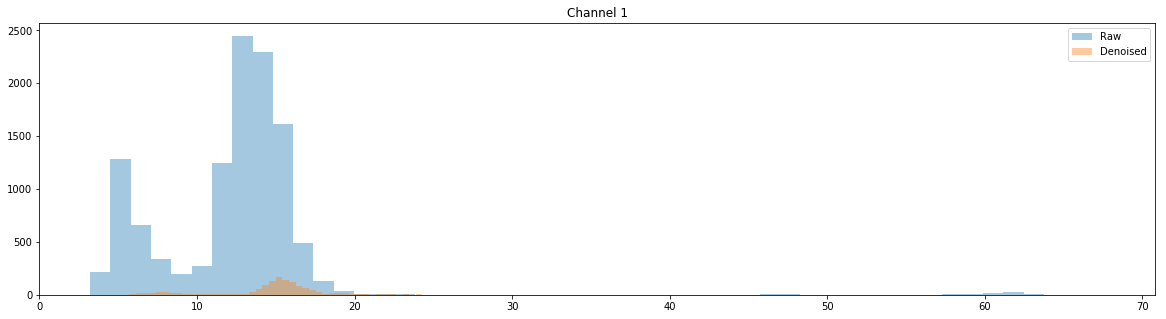

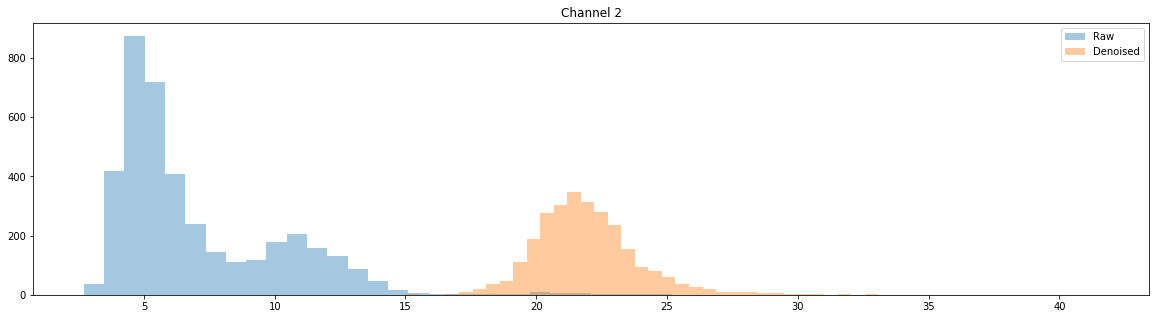

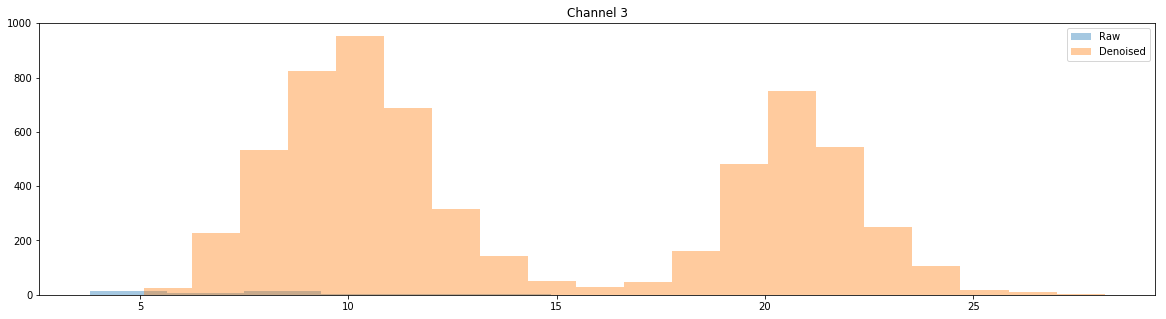

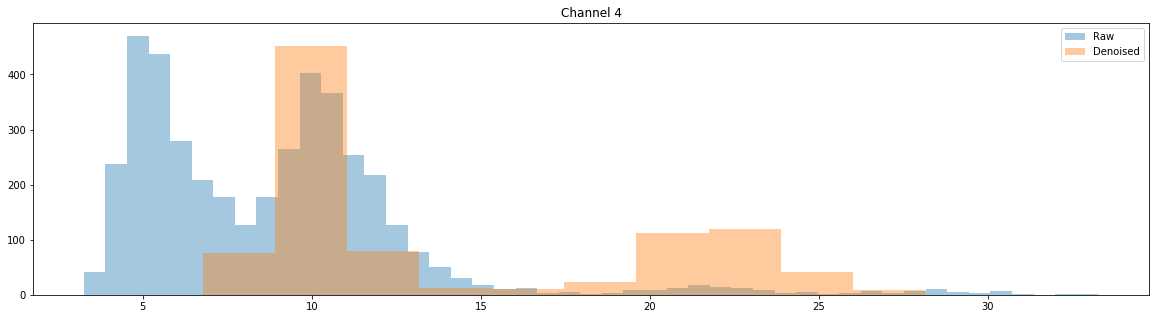

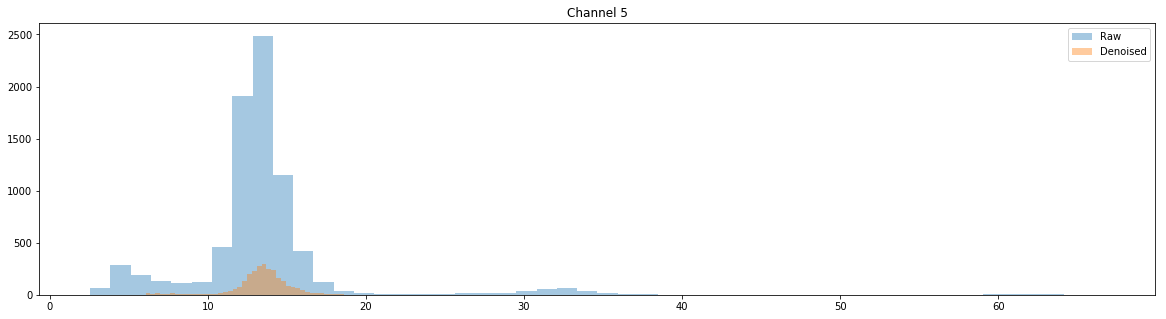

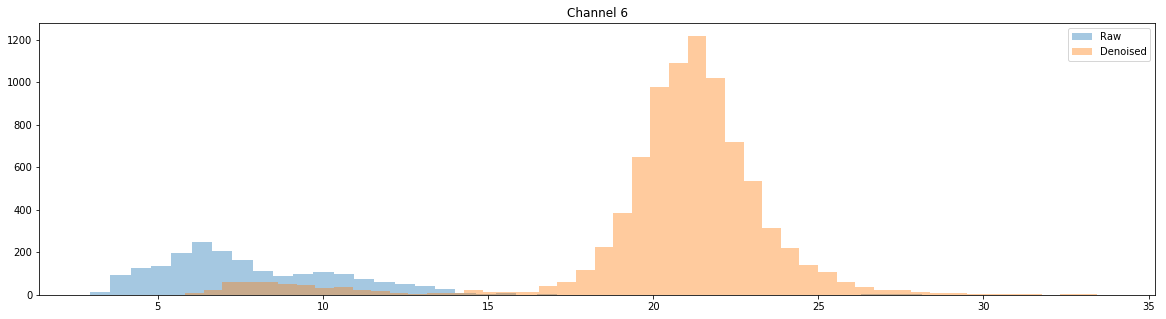

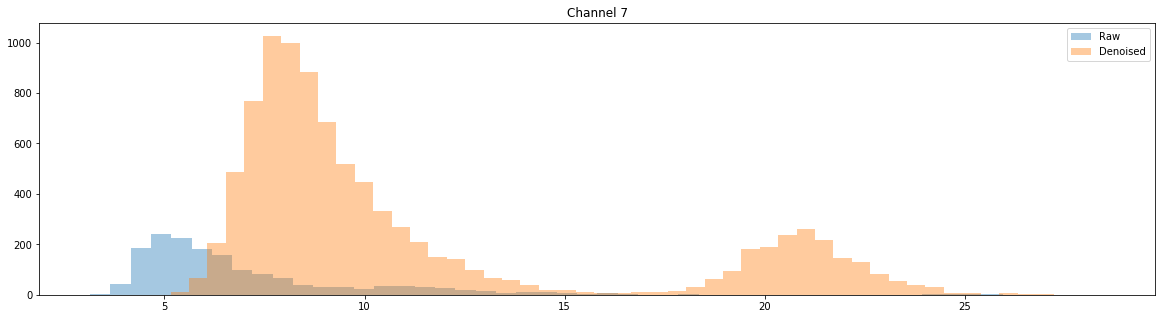

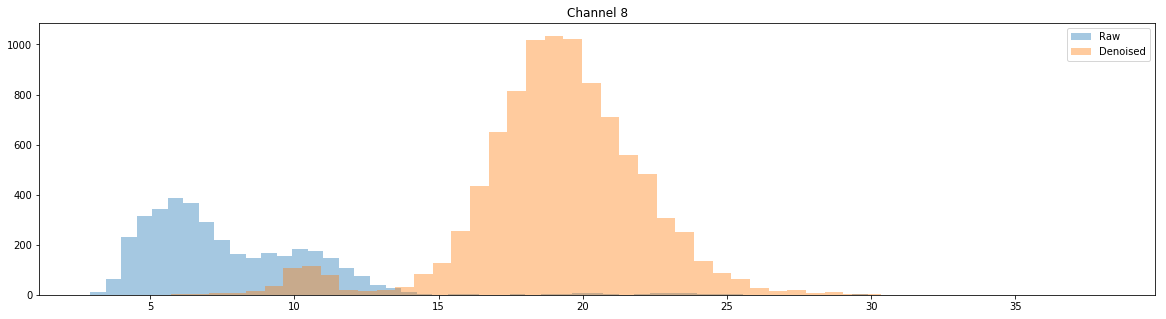

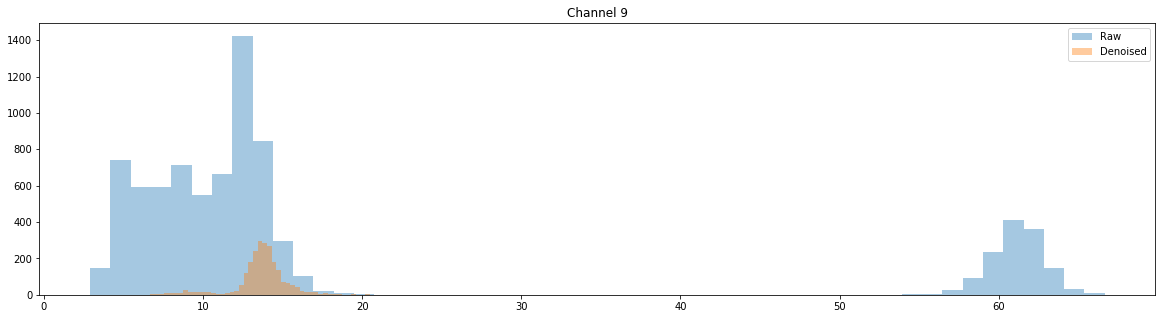

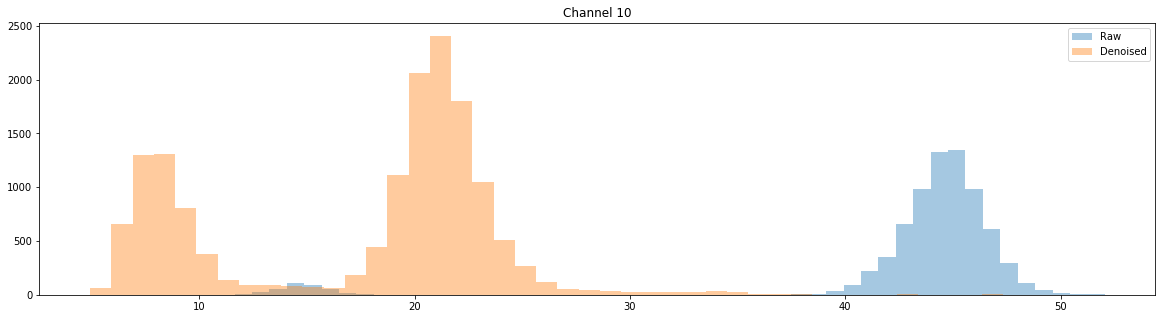

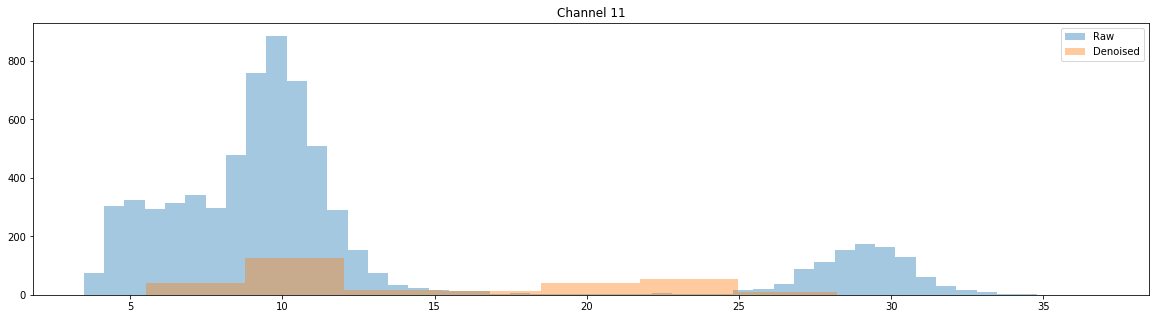

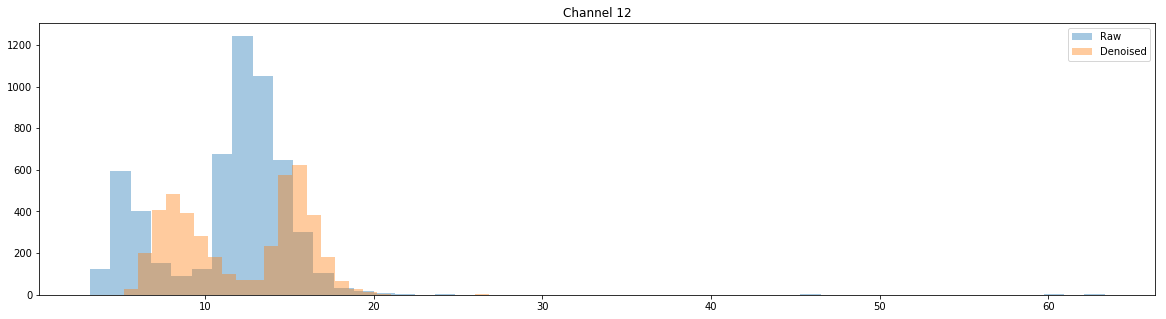

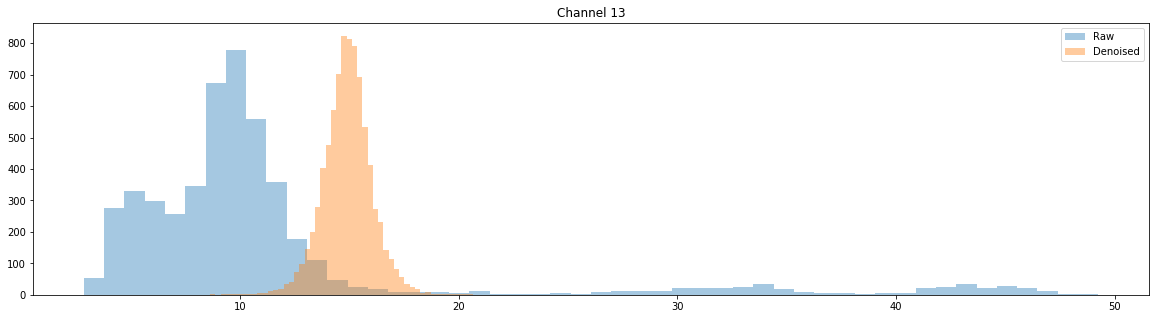

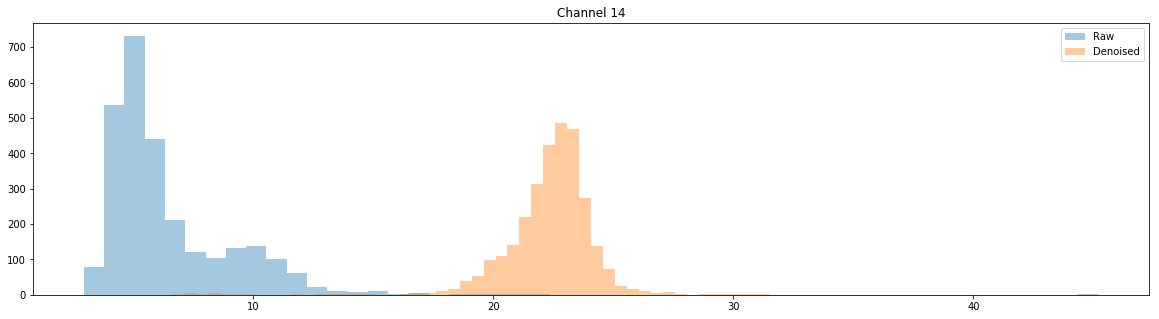

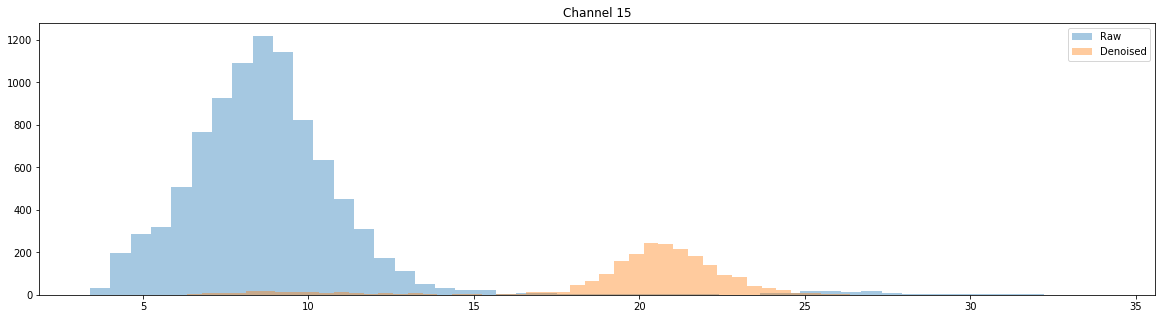

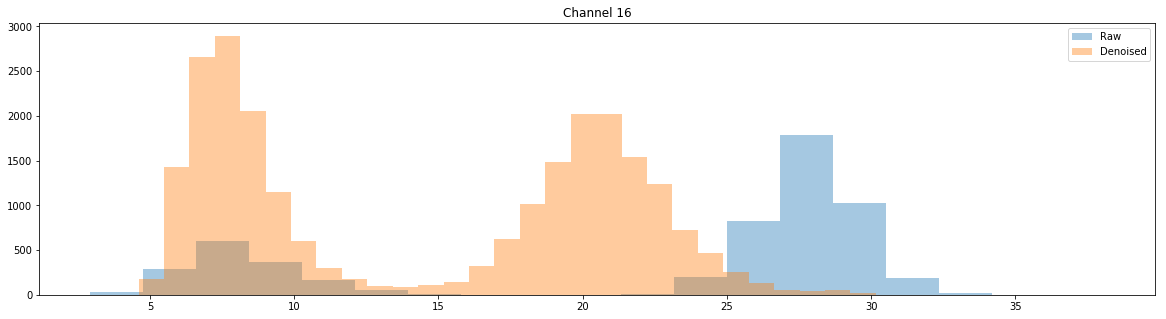

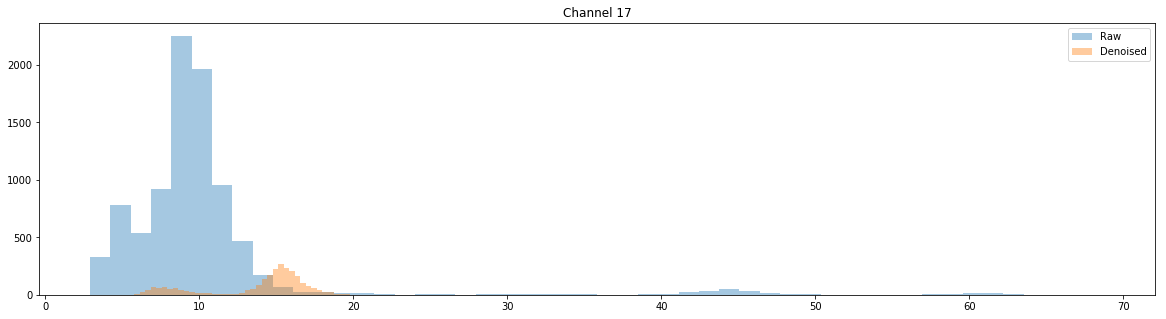

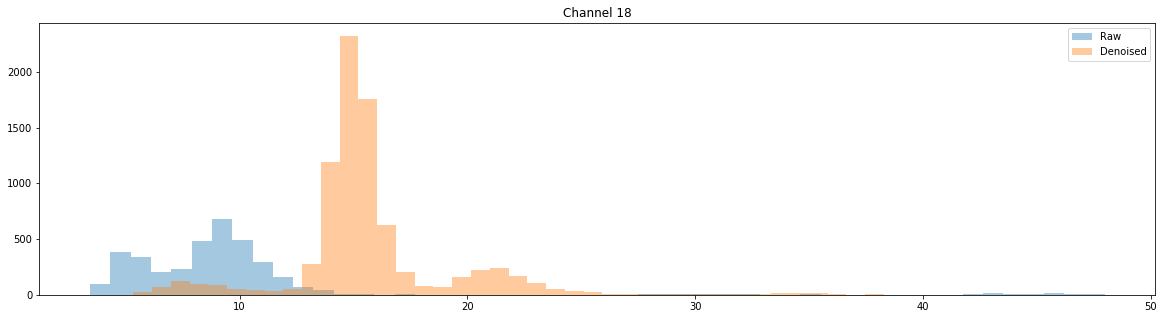

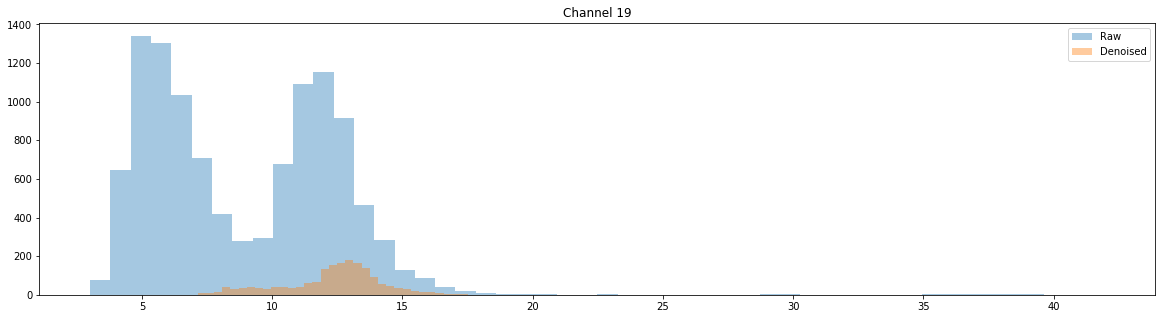

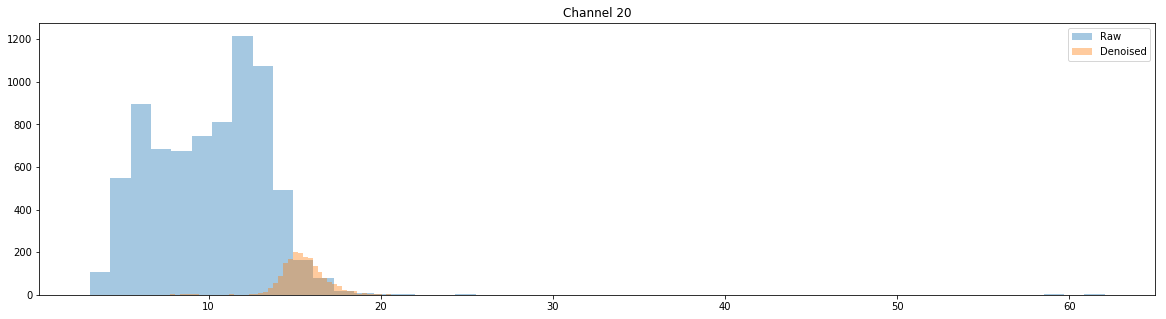

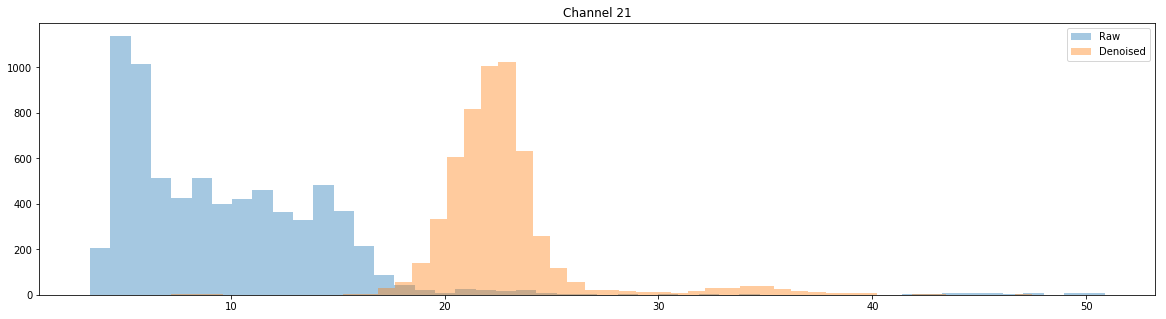

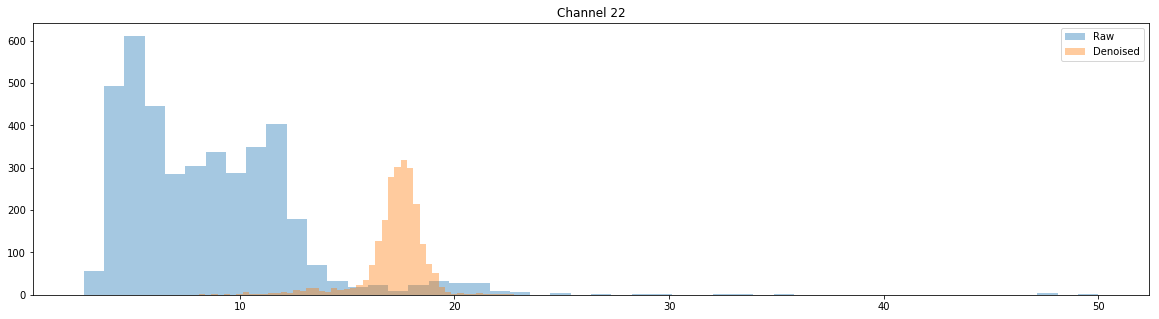

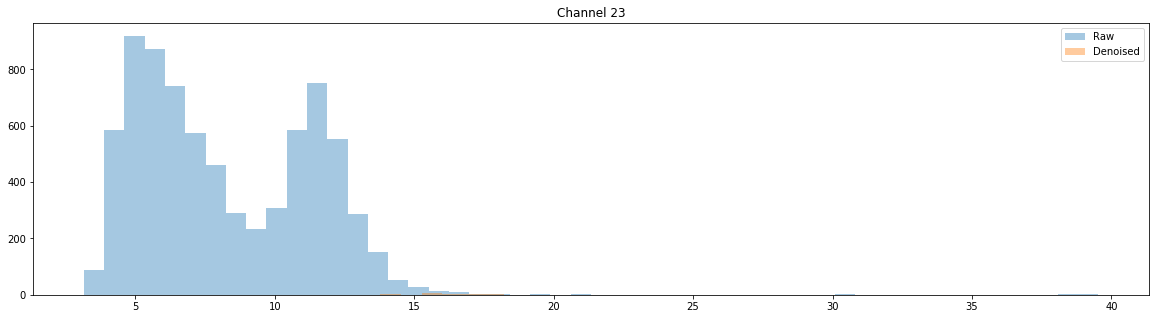

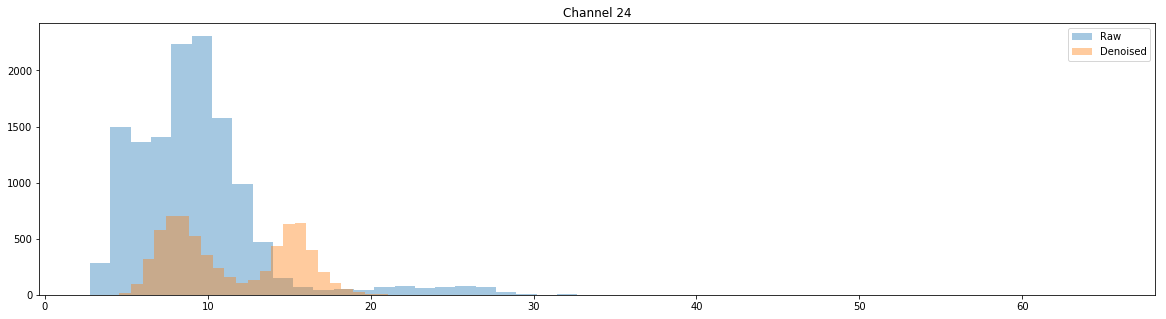

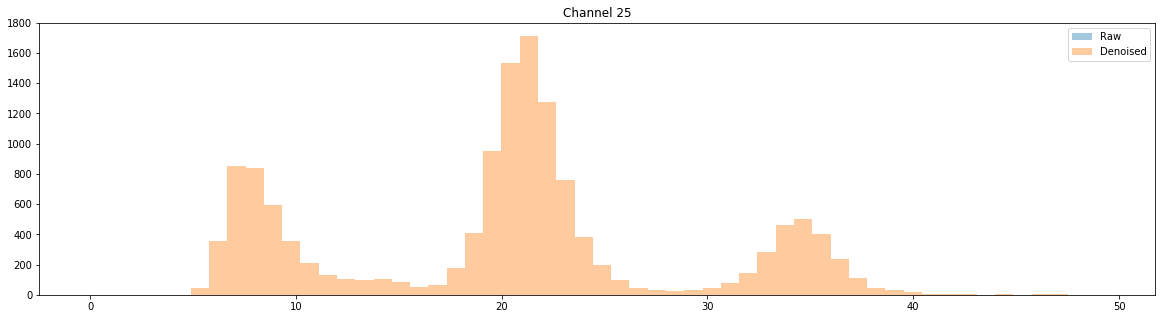

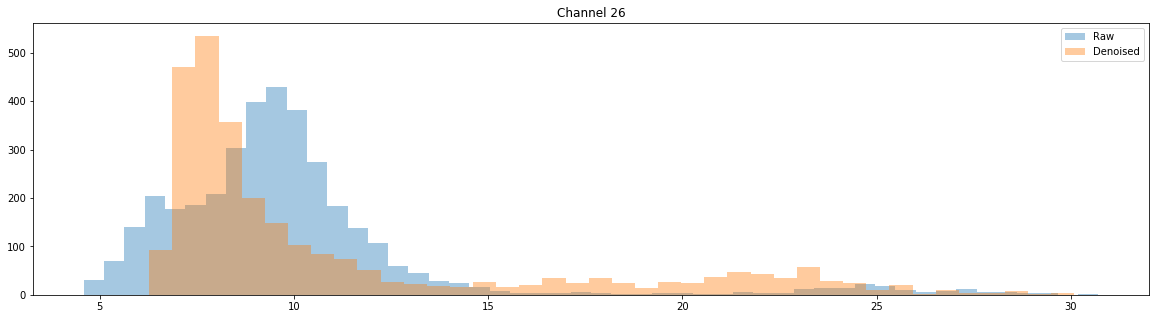

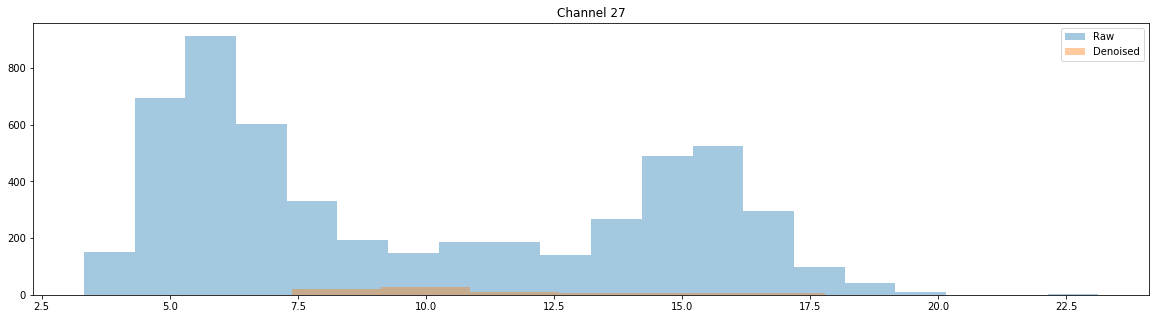

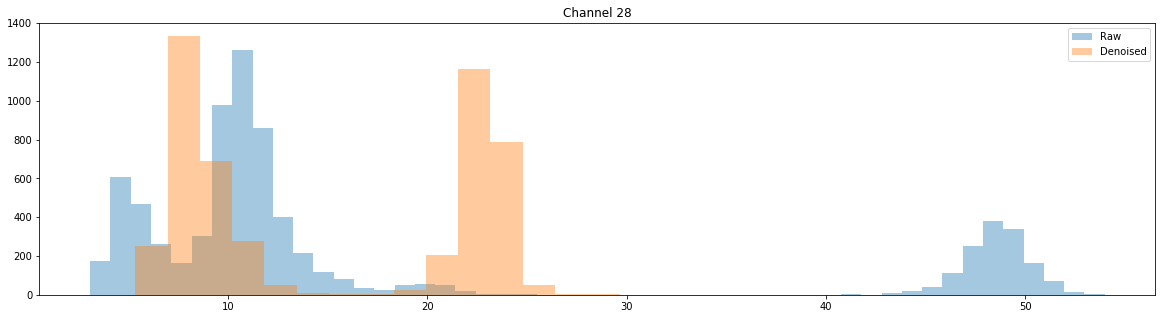

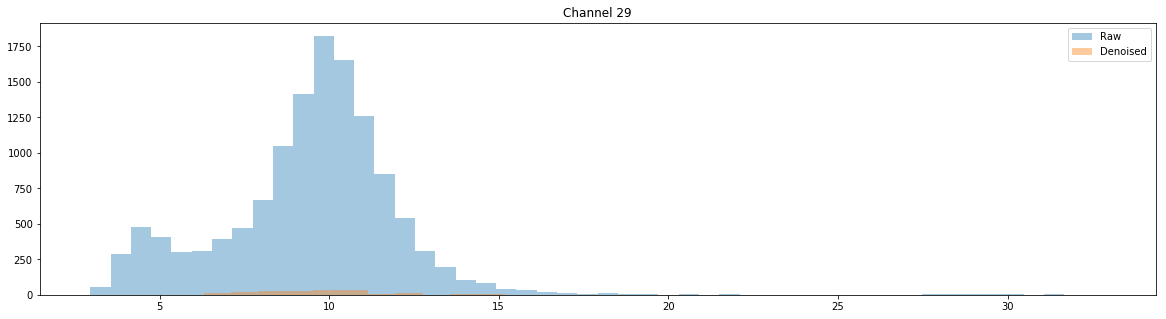

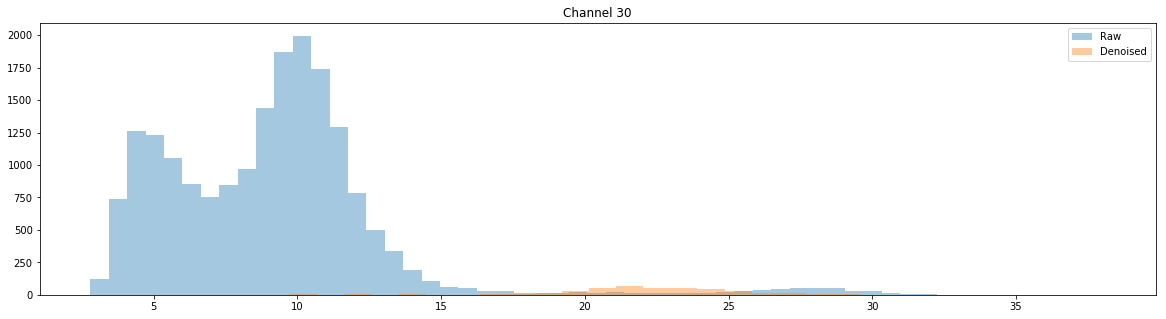

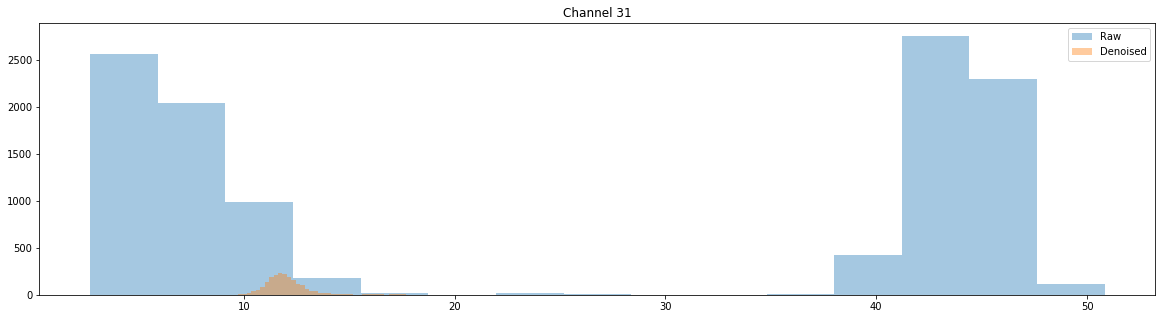

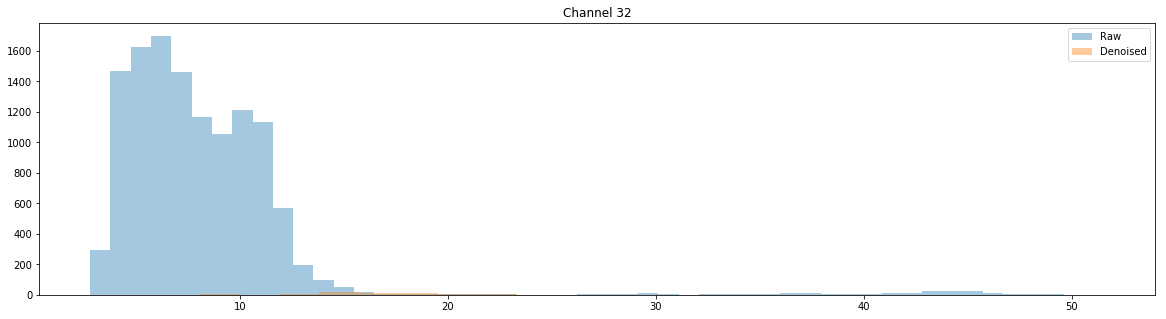

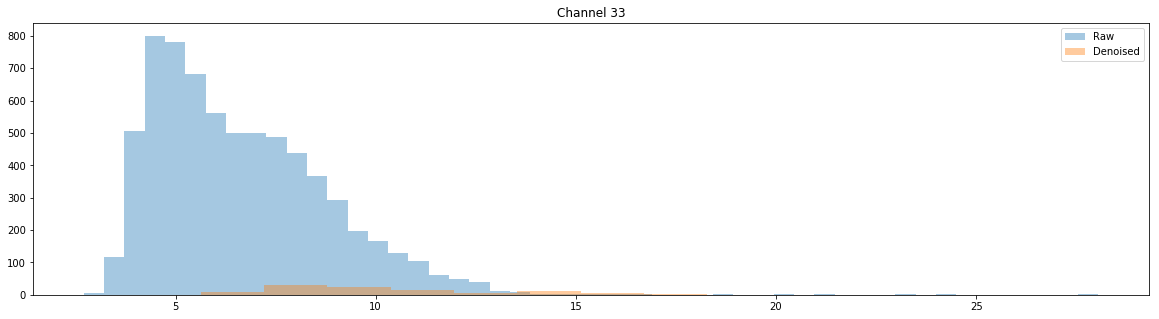

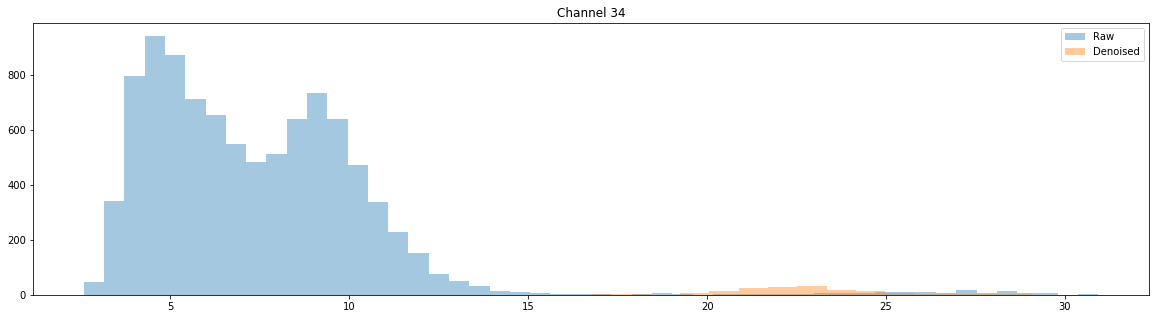

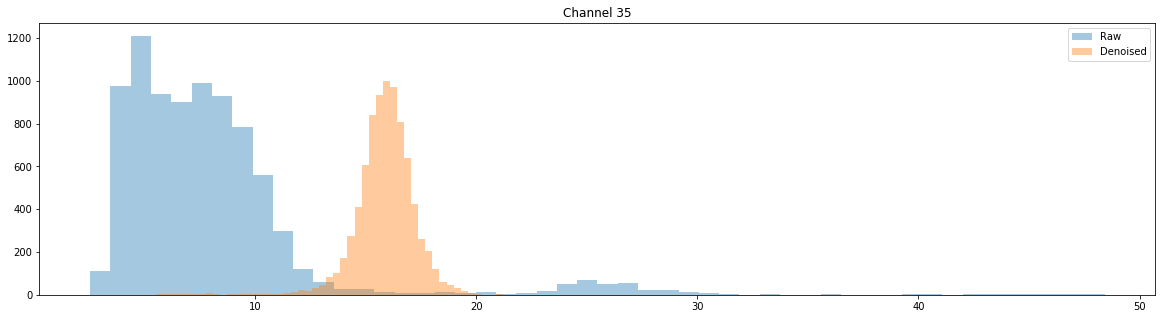

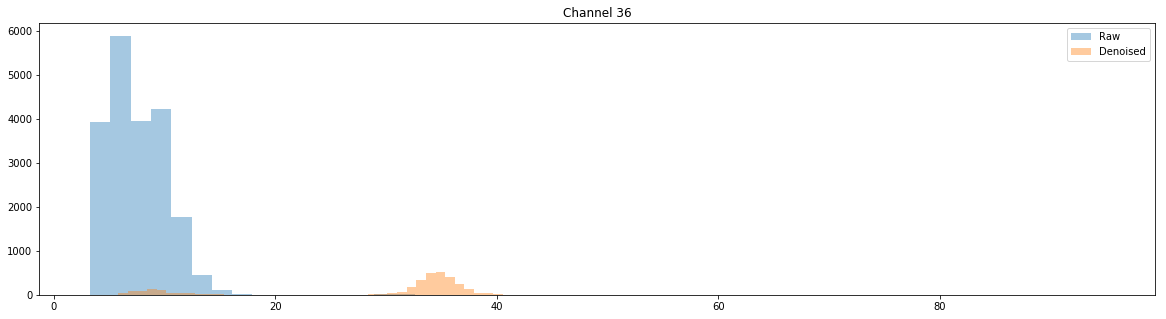

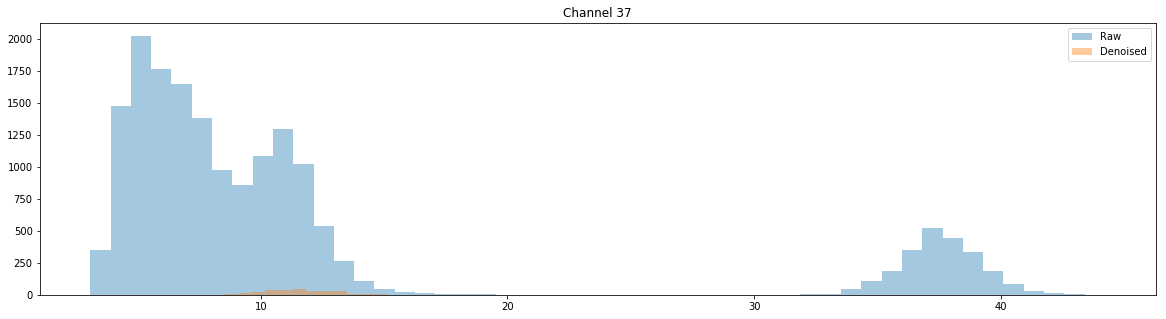

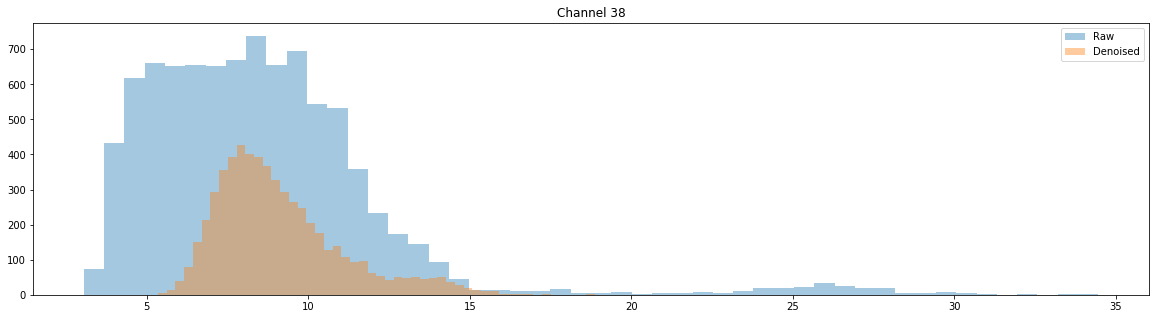

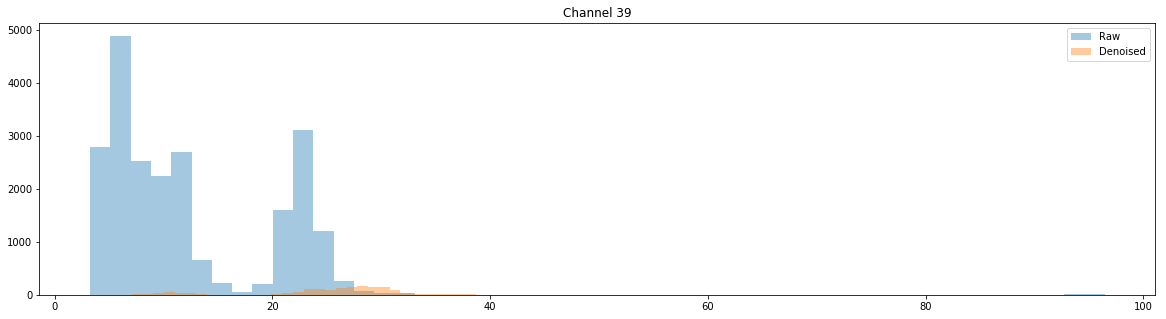

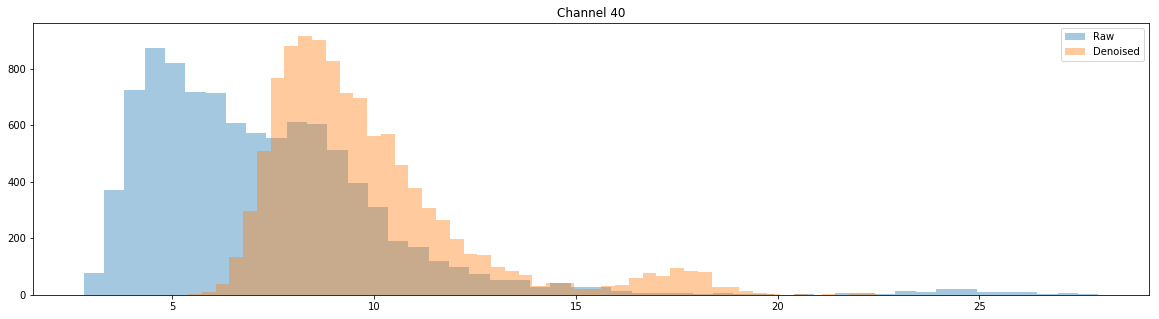

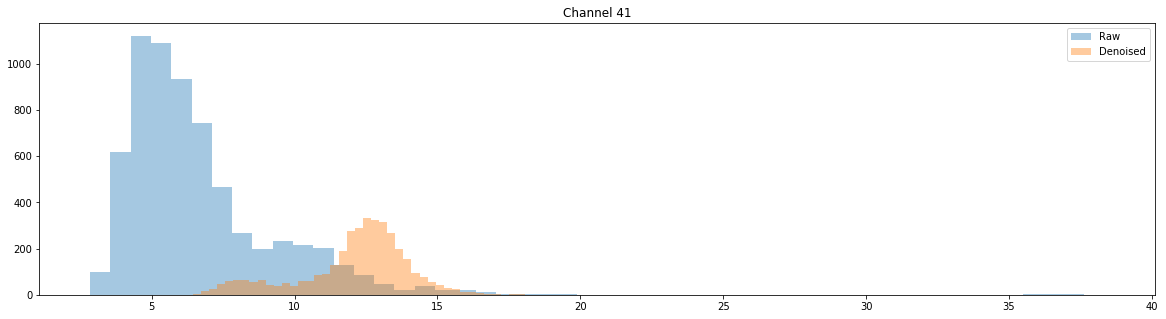

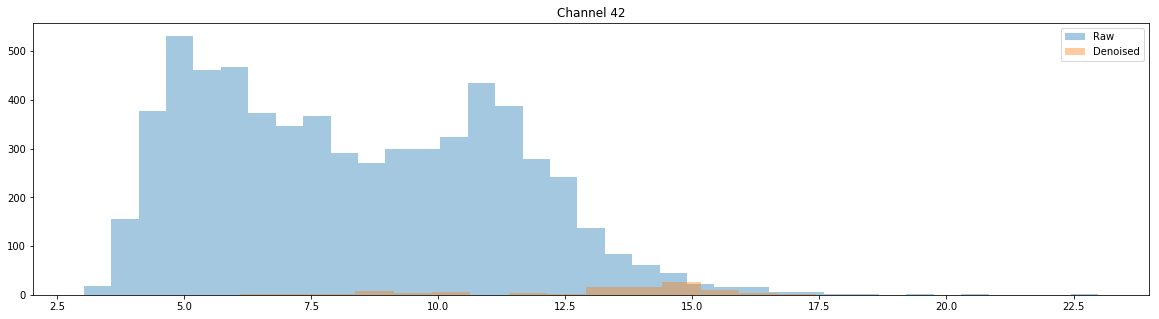

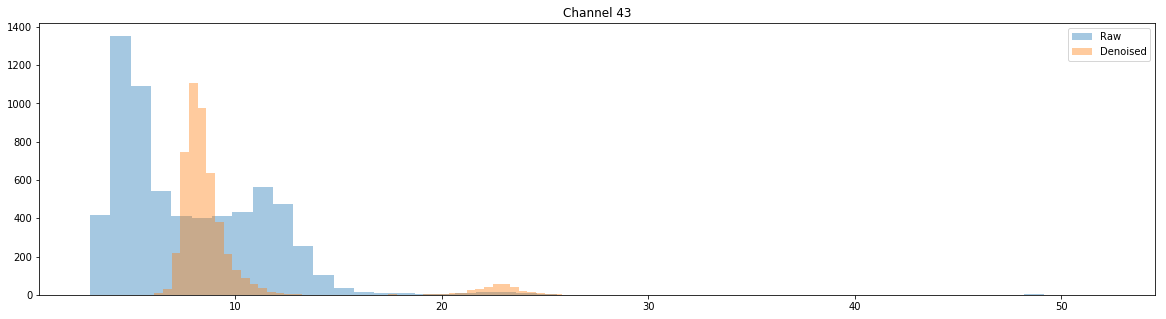

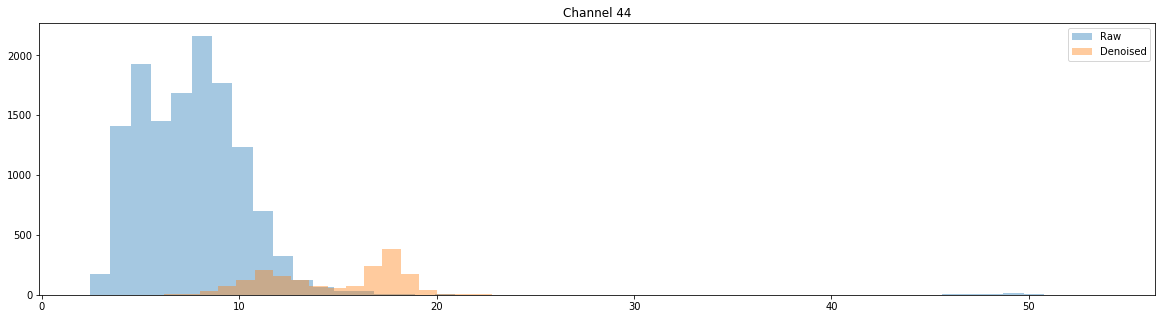

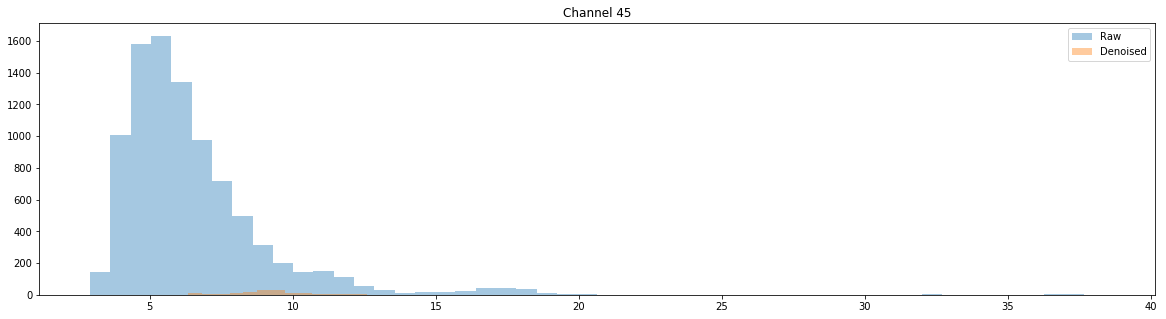

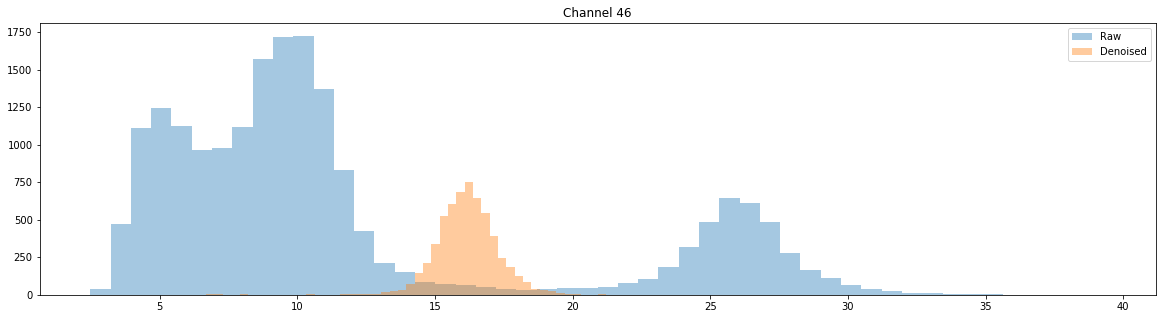

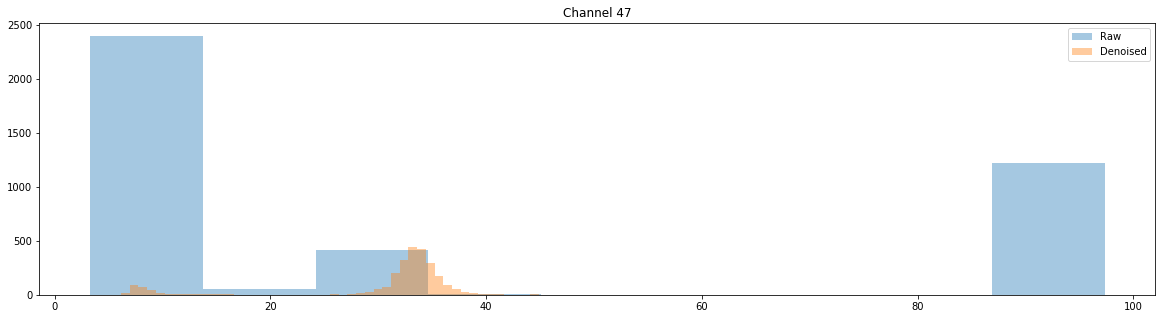

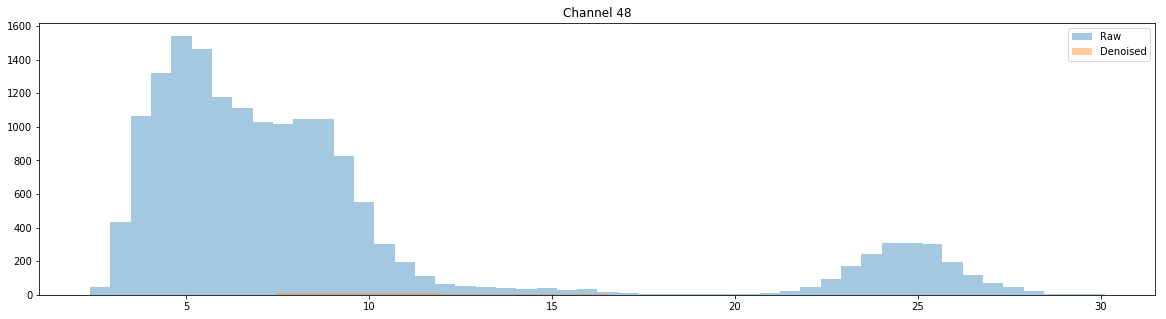

In [88]:
ptps_raw, ptps_denoised = [], []

for ch in CHANNELS:
    plt.figure()
    wfs = indexes_raw.all.read_waveforms_from_channel(rec_all, channel=ch, random_shift=False)
    ptps = templates_utl.ptps(wfs)
    ptps_raw.append(ptps)
    sns.distplot(ptps, ax=None, label='Raw', norm_hist=False, kde=False)

    
    # reac_all or rec_denoised?
    wfs = indexes_denoised.all.read_waveforms_from_channel(rec_denoised, channel=ch, random_shift=False)
    ptps = templates_utl.ptps(wfs)
    ptps_denoised.append(ptps)
    sns.distplot(ptps, ax=None, label='Denoised', norm_hist=False, kde=False)
    
    plt.title(f'Channel {ch}')
    plt.legend()

ptps_raw = np.concatenate(ptps_raw)
ptps_denoised = np.concatenate(ptps_denoised)

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


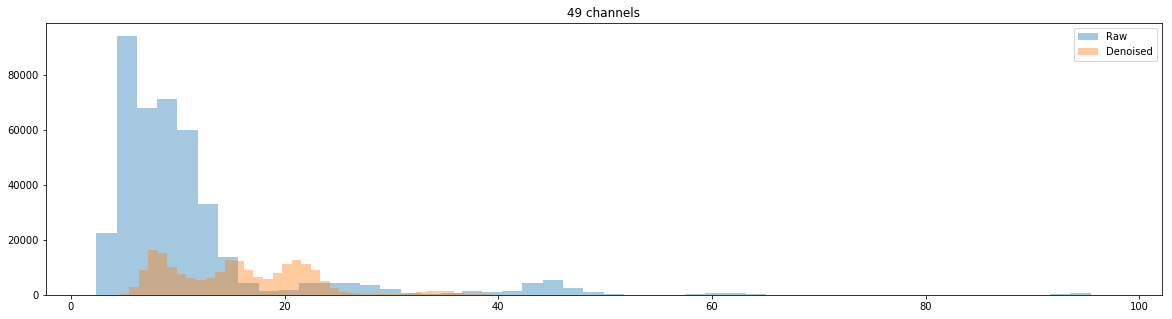

In [89]:
sns.distplot(ptps_raw, ax=None, label='Raw', norm_hist=False, kde=False)
sns.distplot(ptps_denoised, ax=None, label='Denoised', norm_hist=False, kde=False)
plt.title('49 channels')
plt.legend()

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/Edu/miniconda3/envs

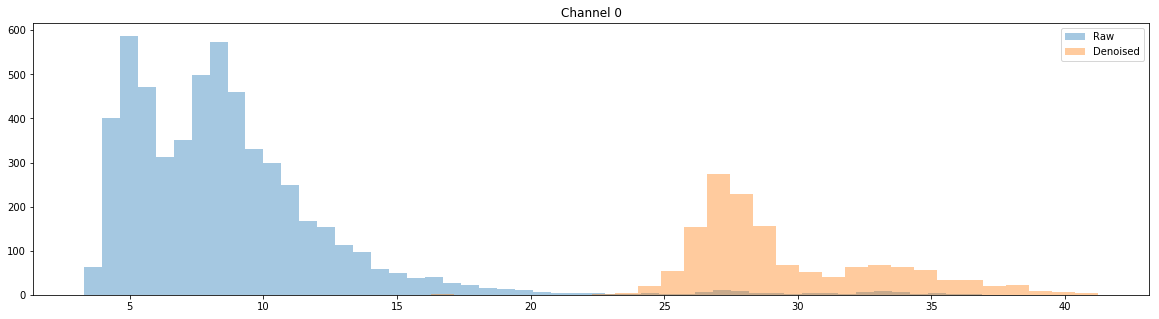

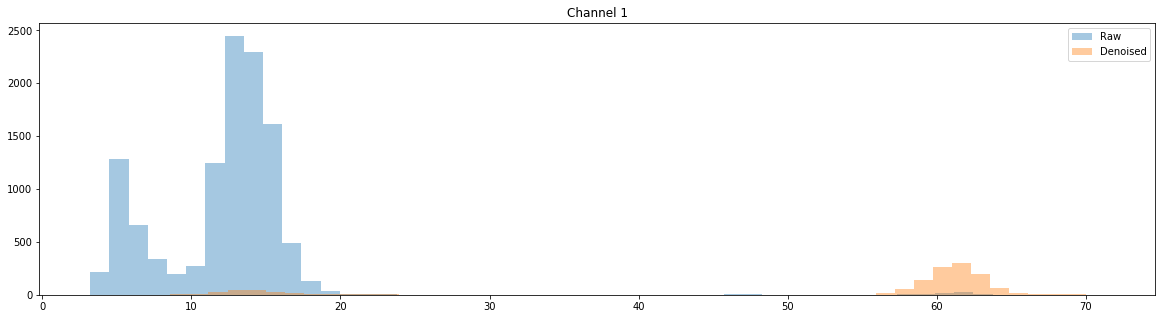

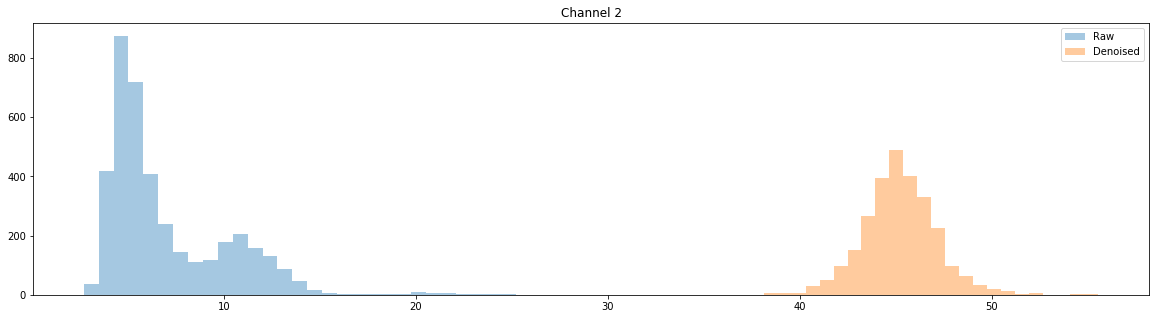

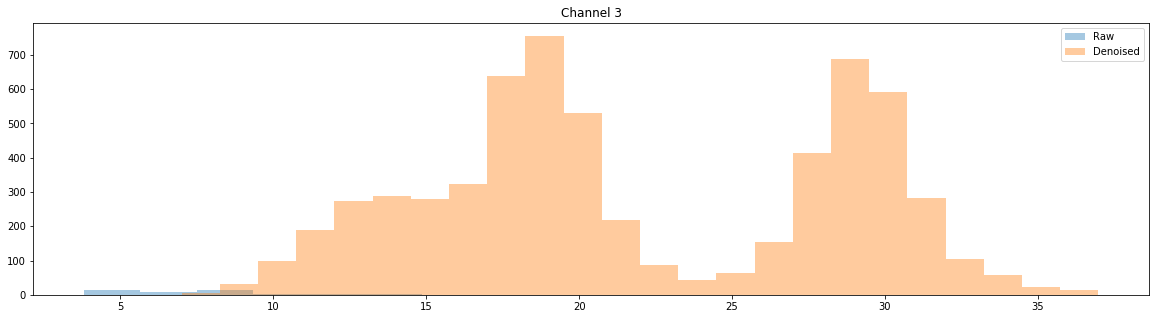

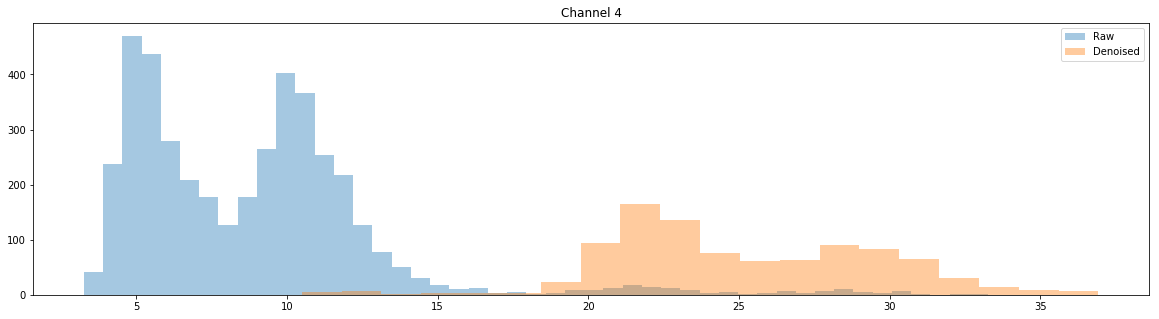

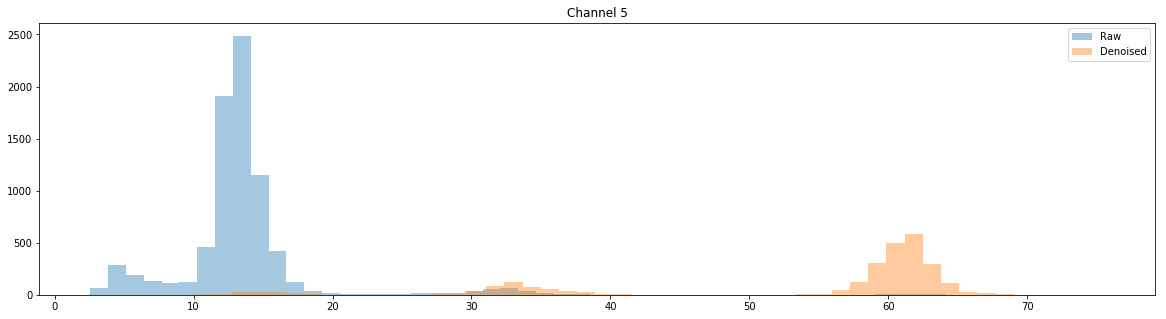

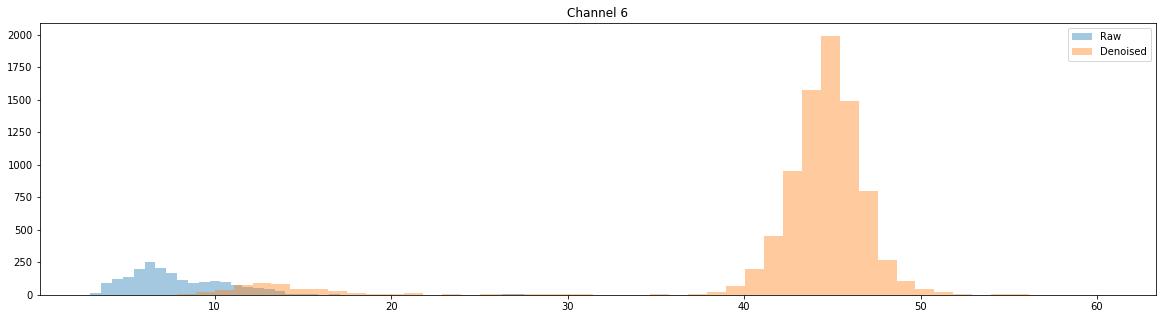

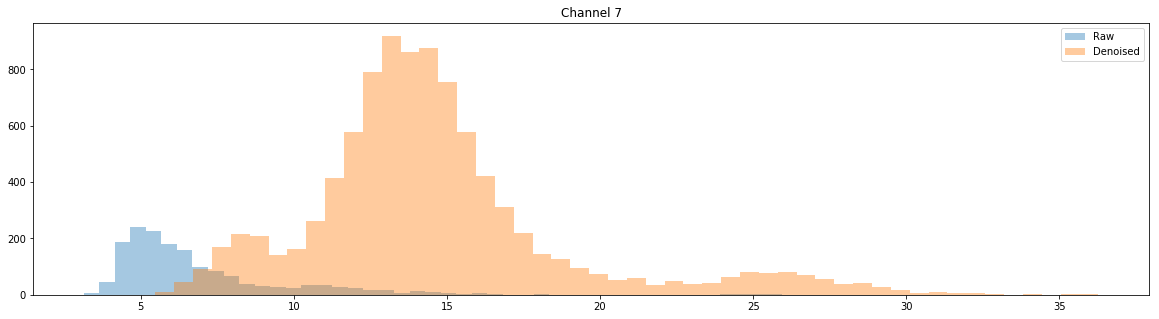

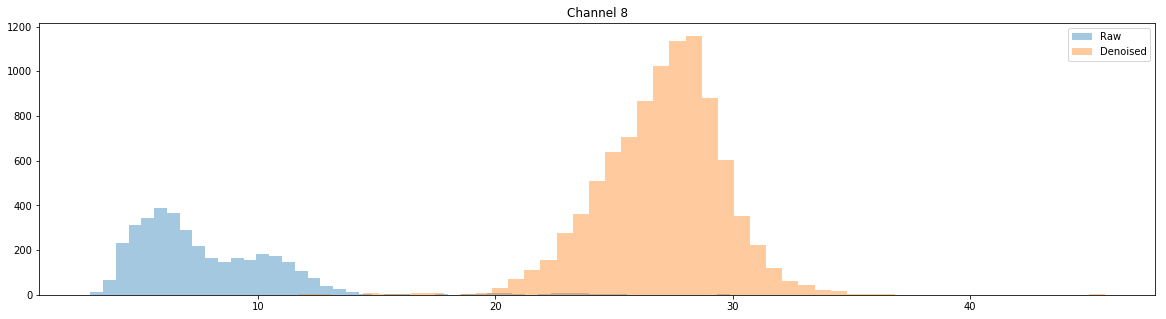

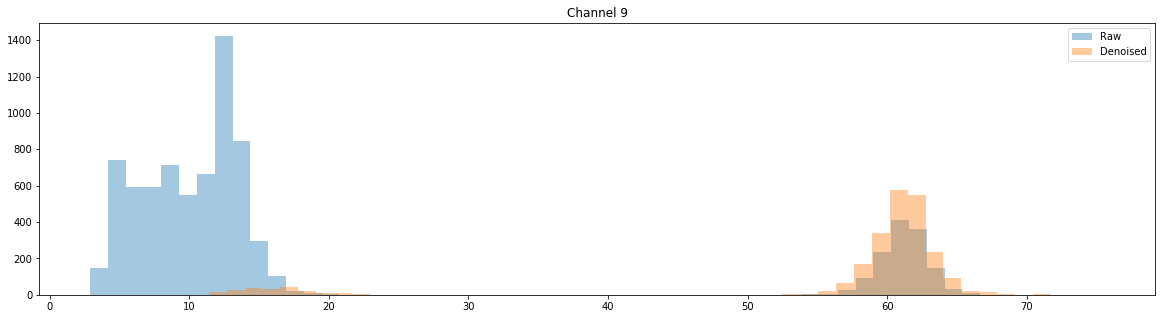

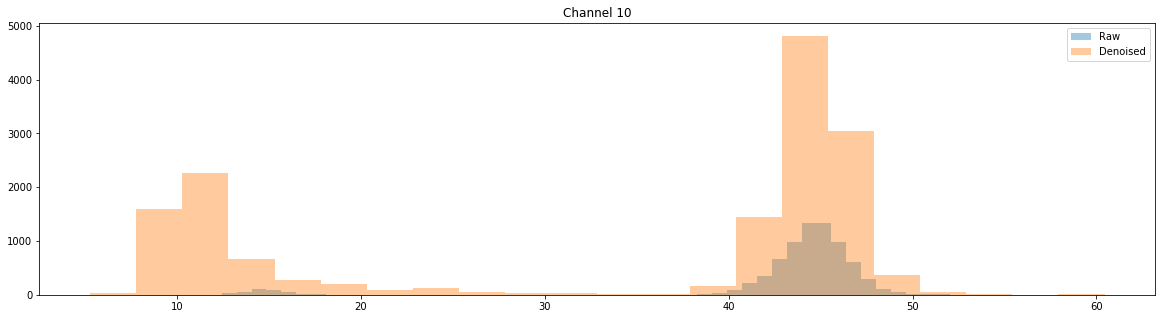

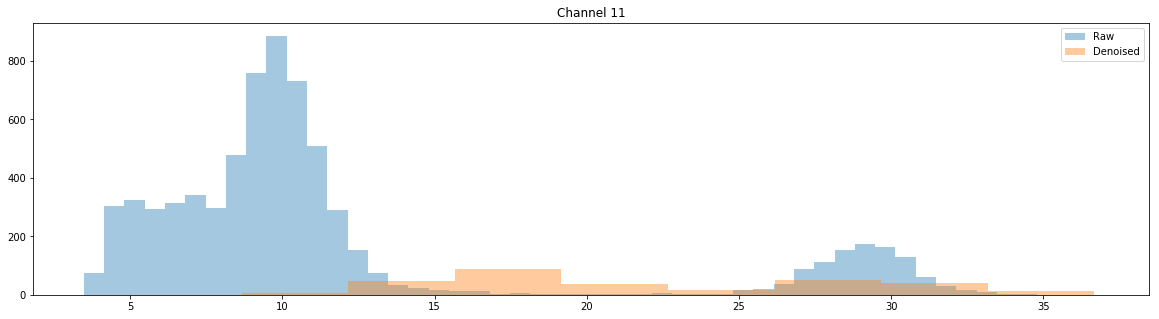

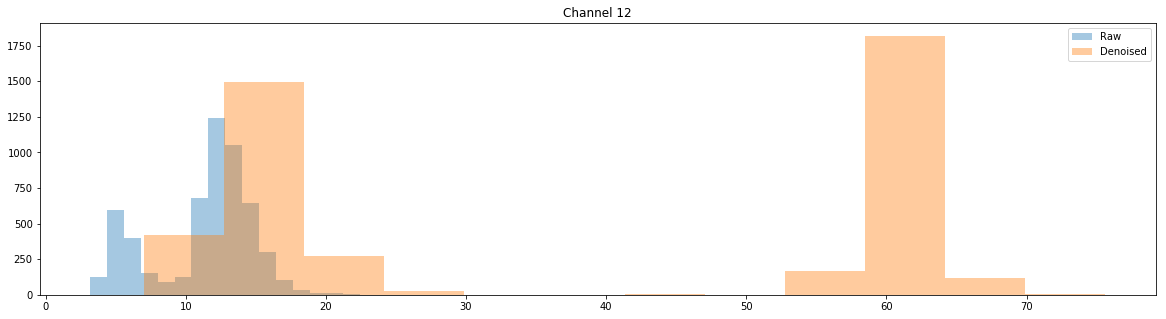

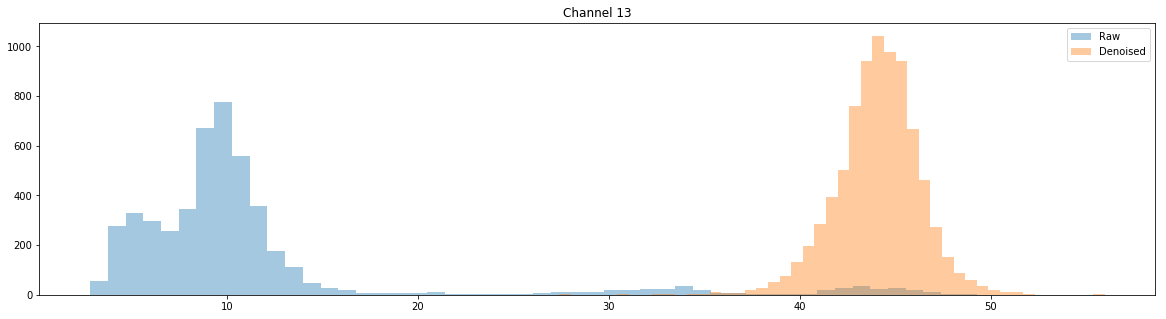

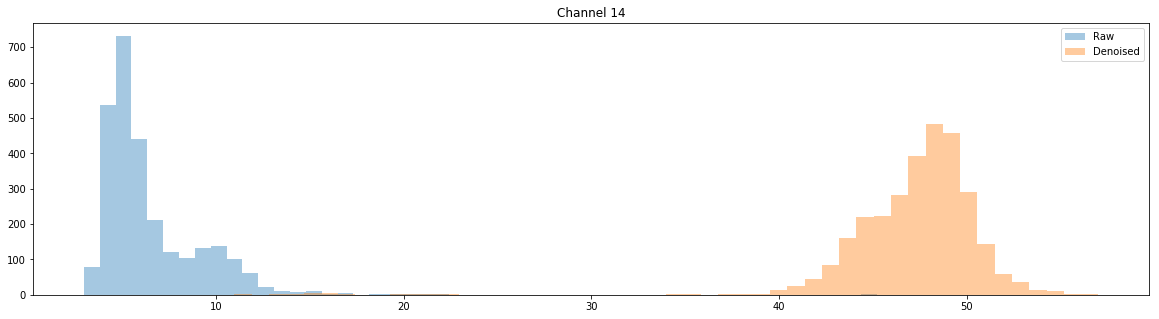

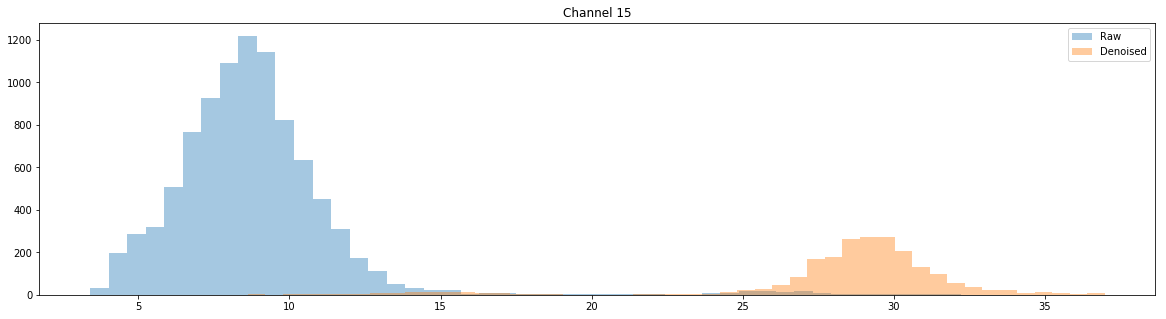

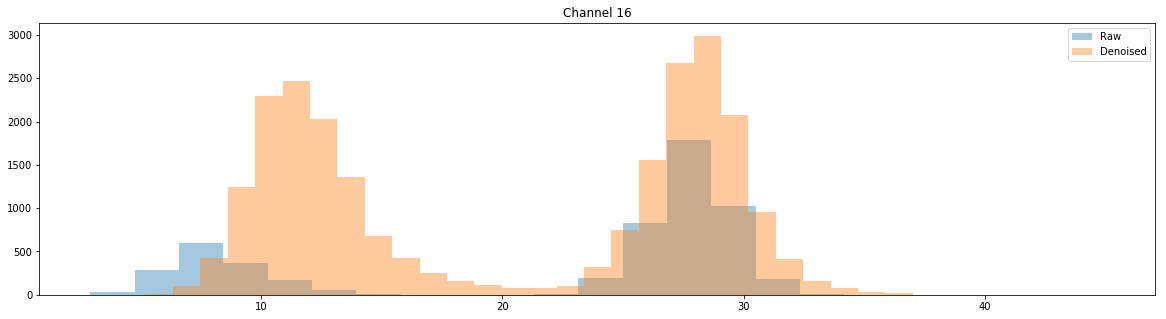

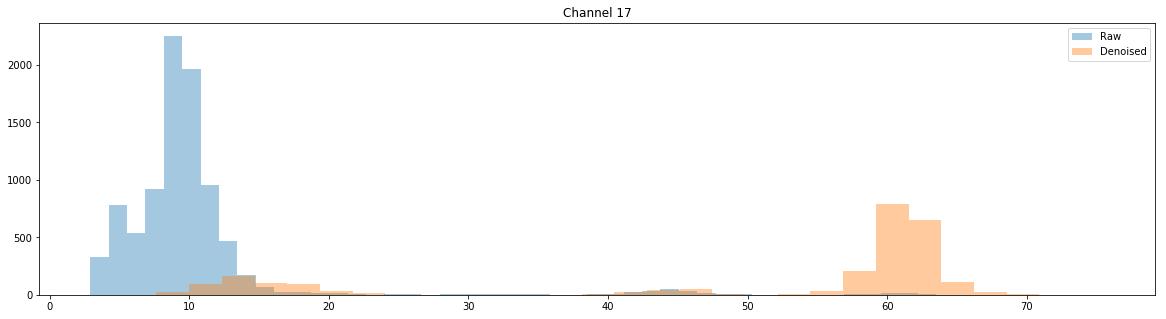

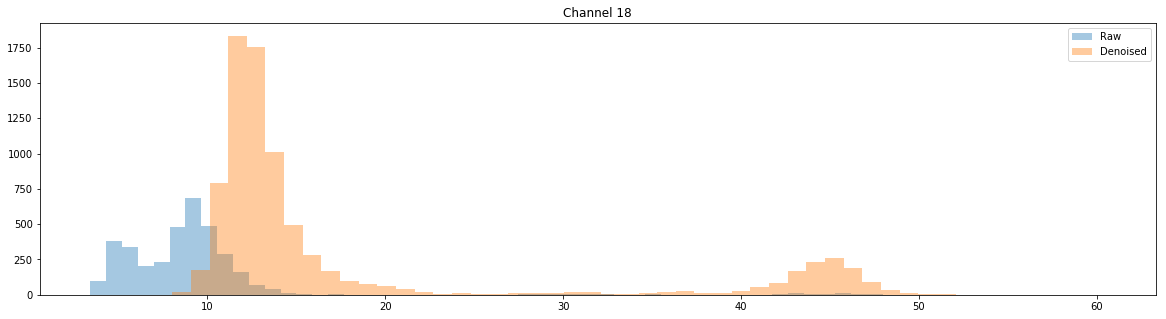

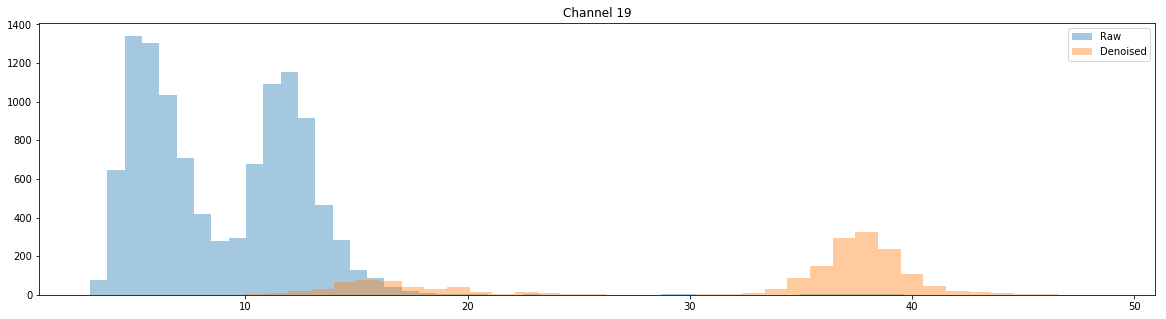

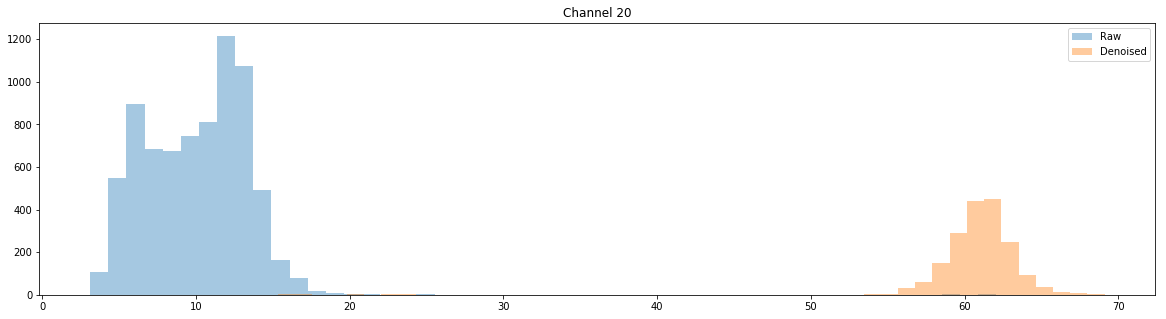

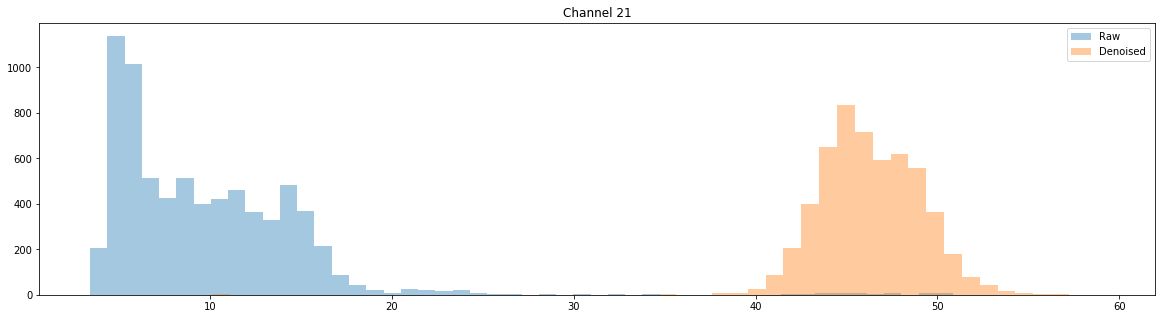

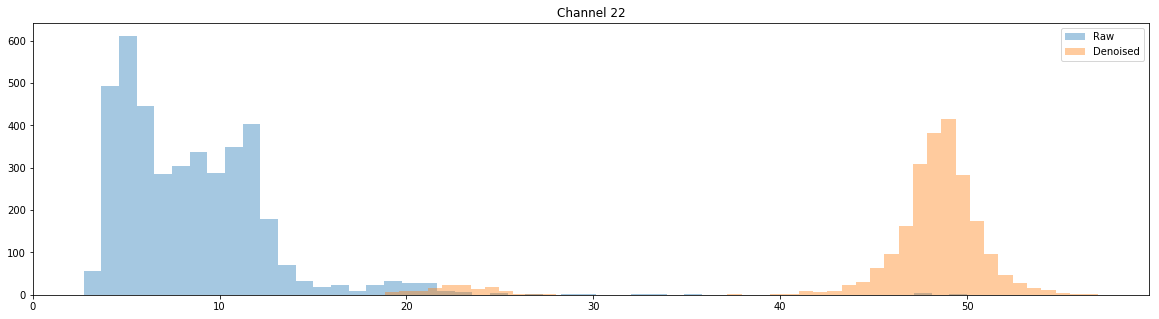

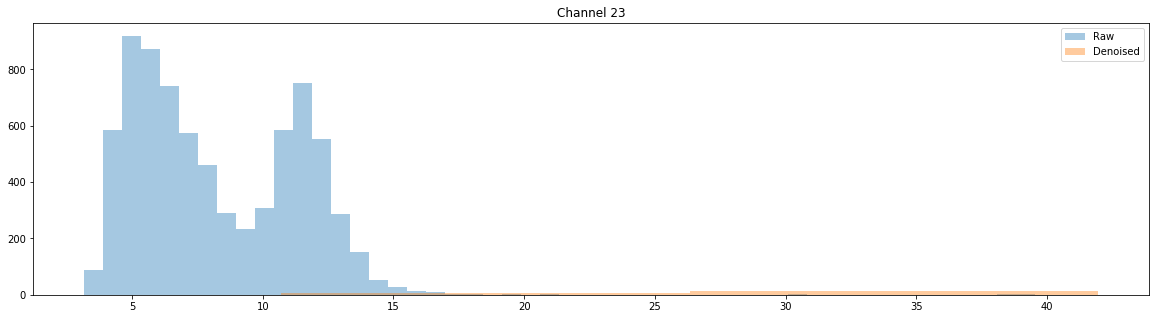

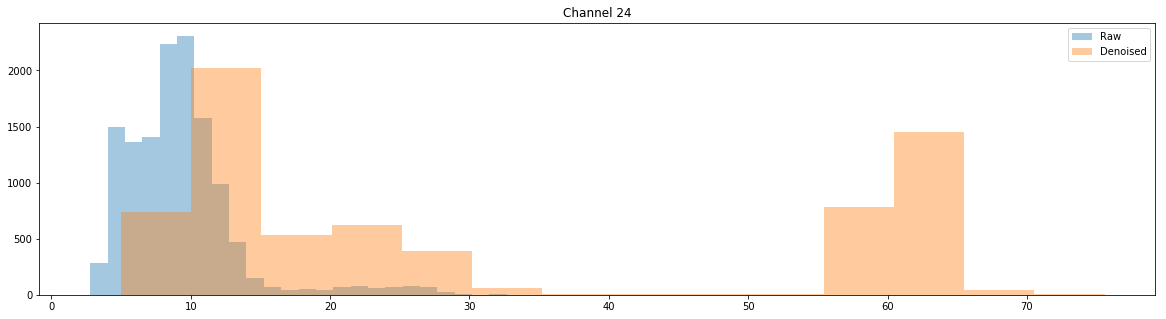

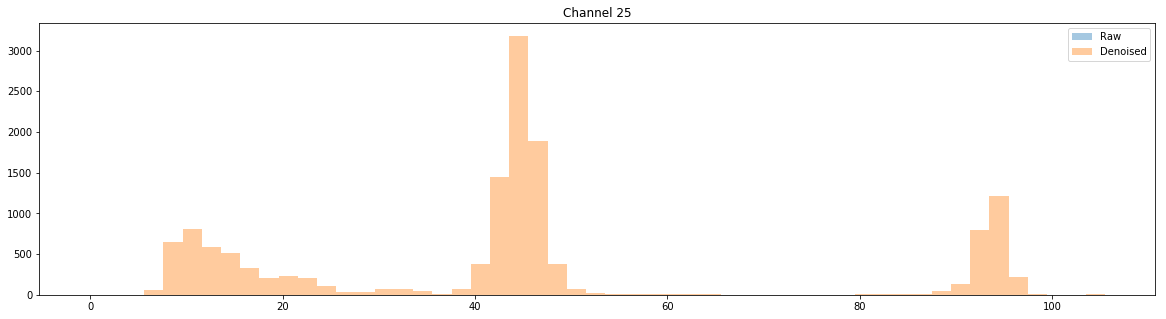

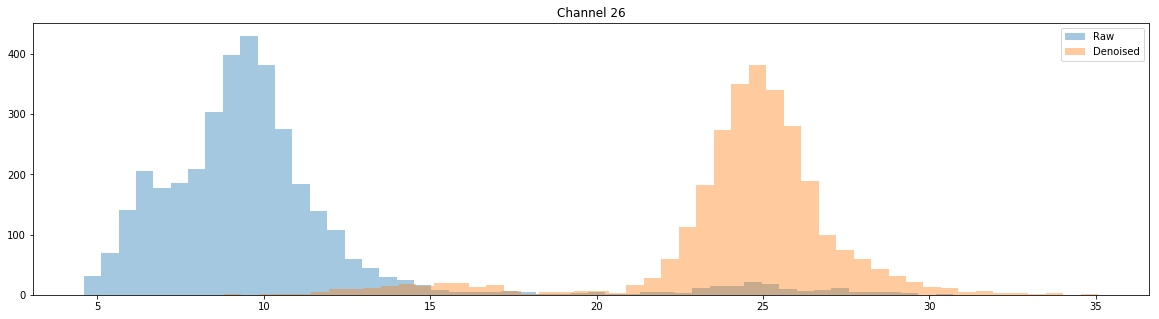

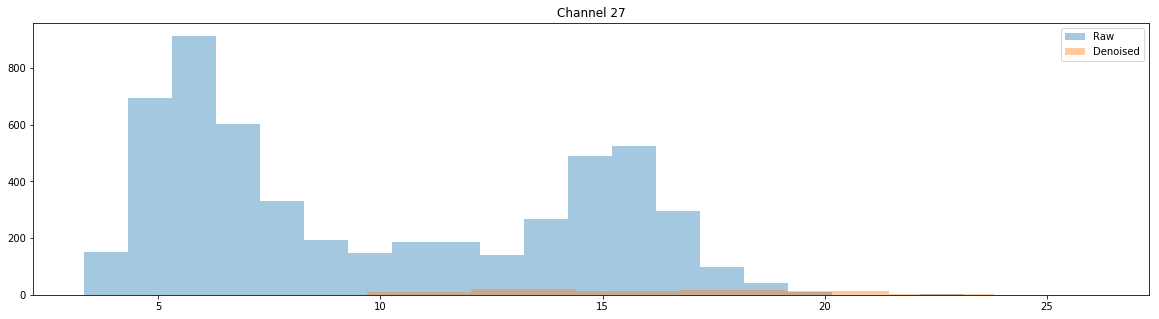

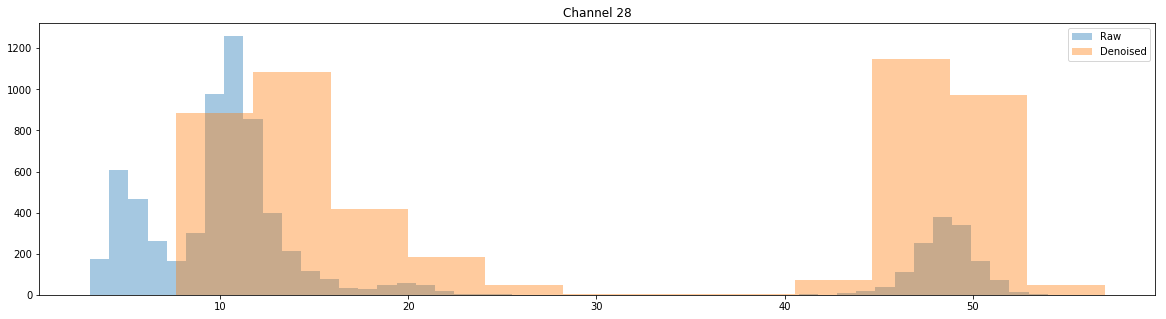

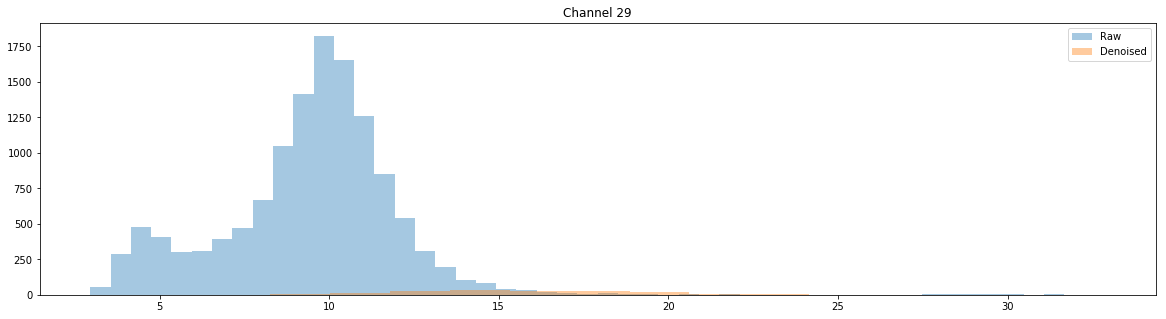

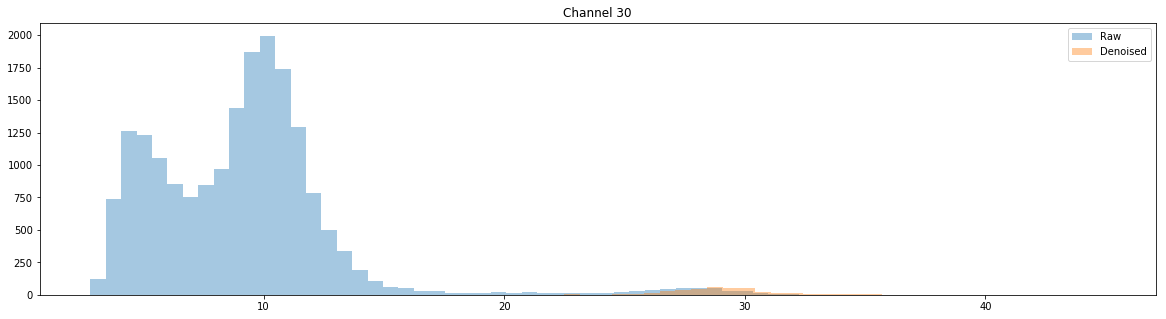

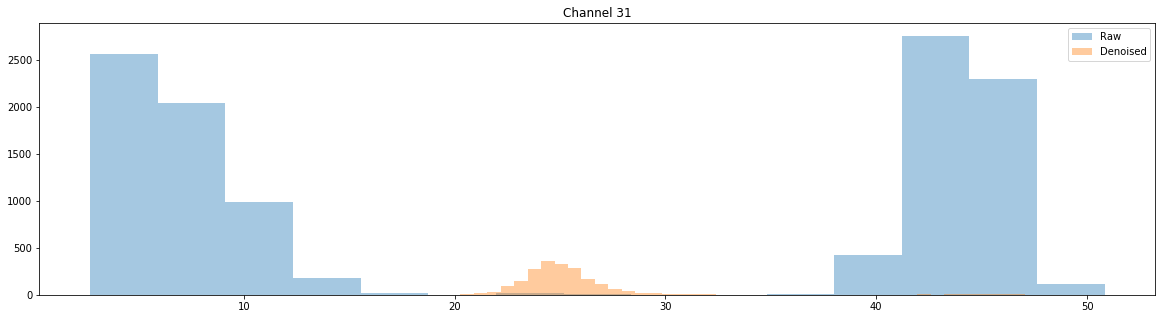

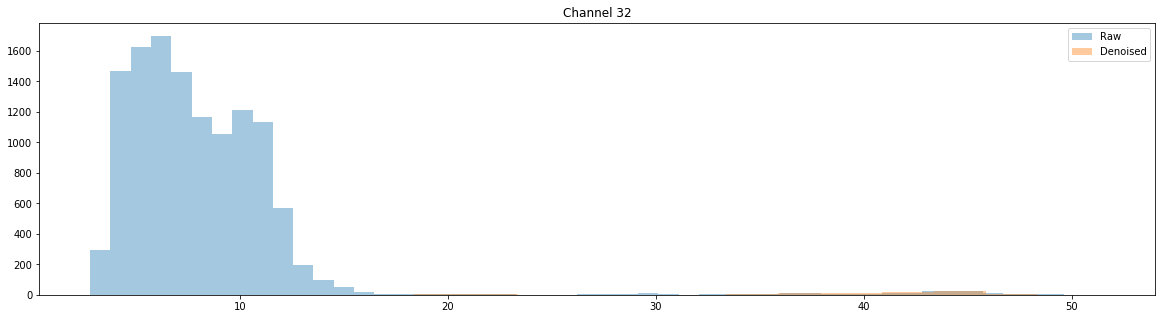

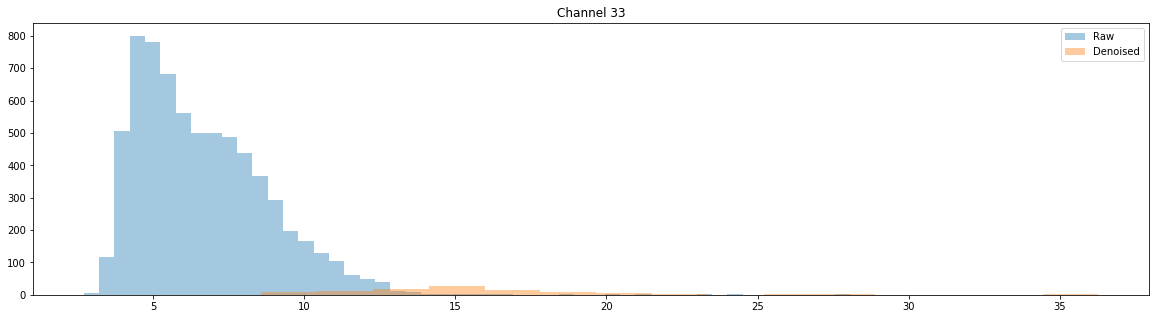

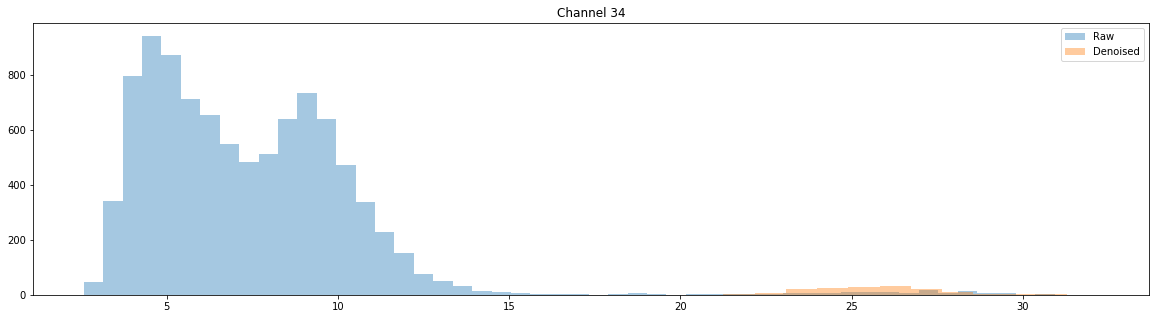

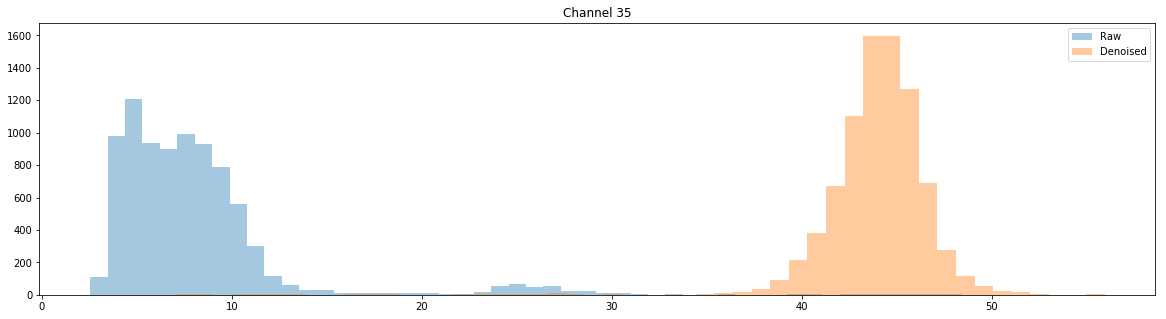

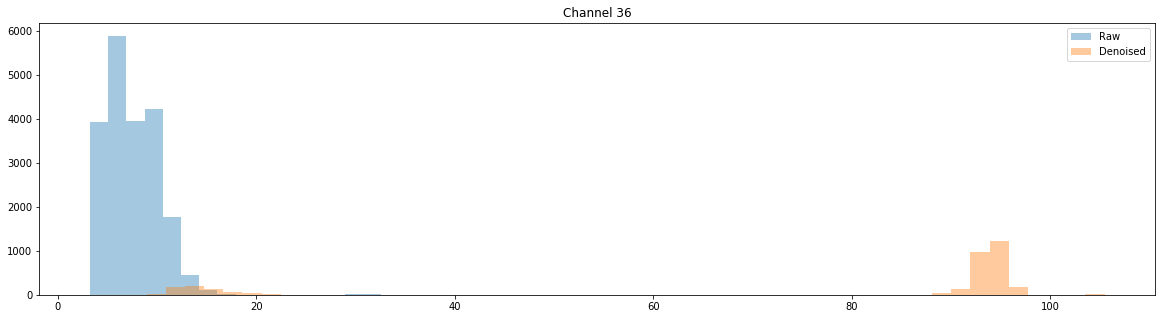

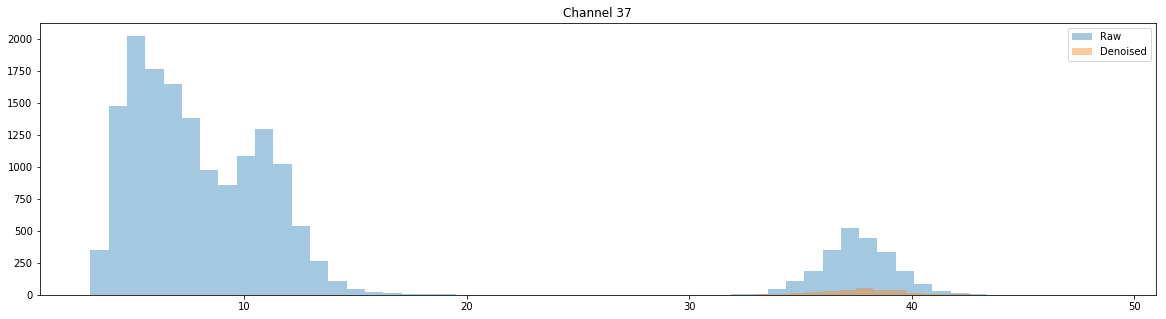

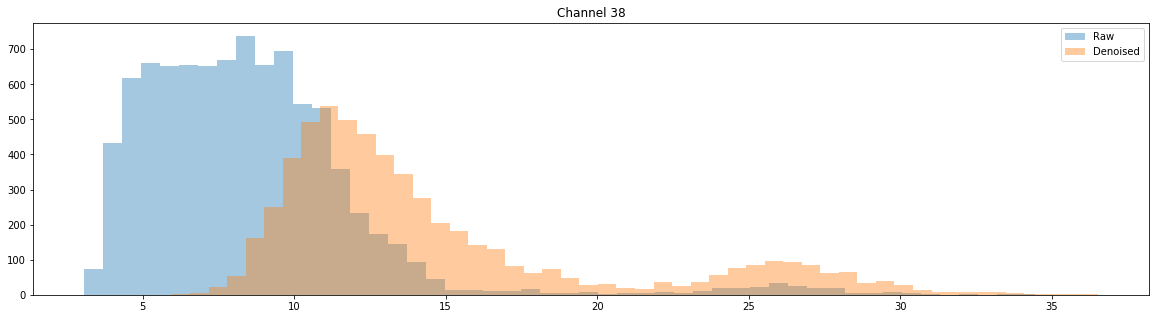

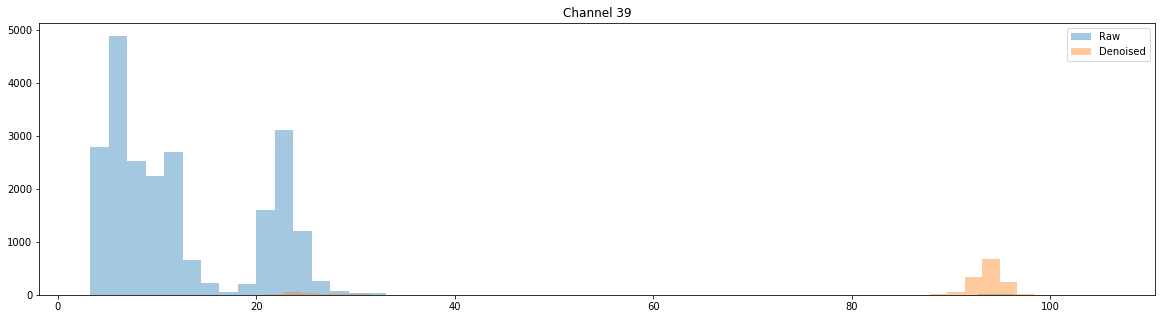

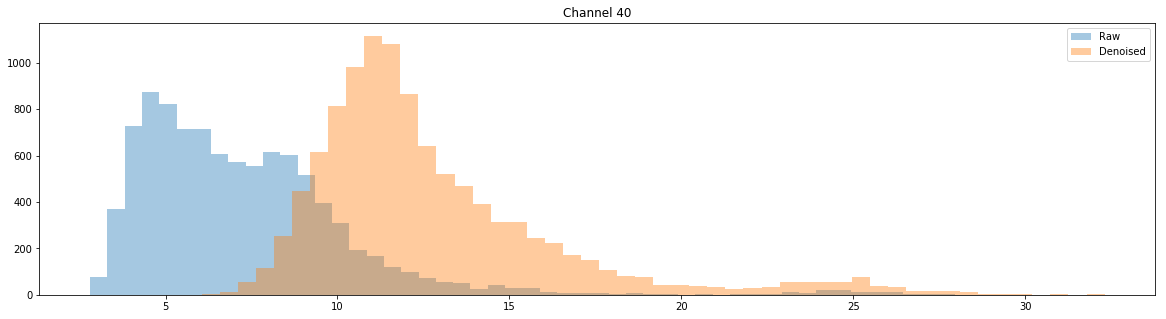

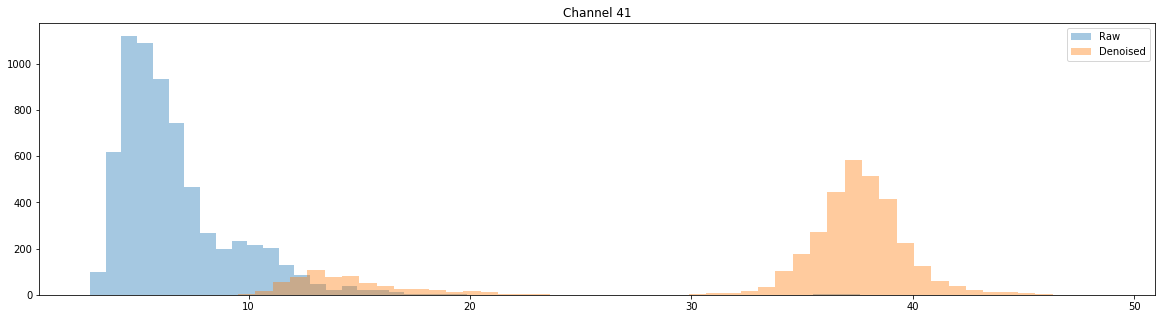

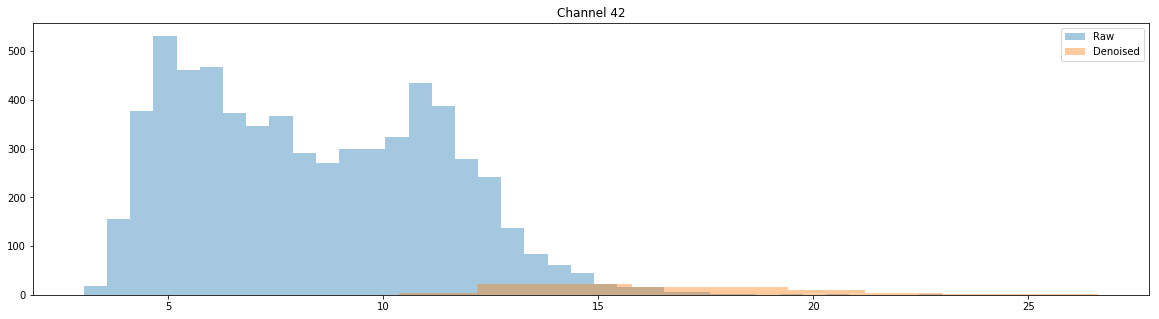

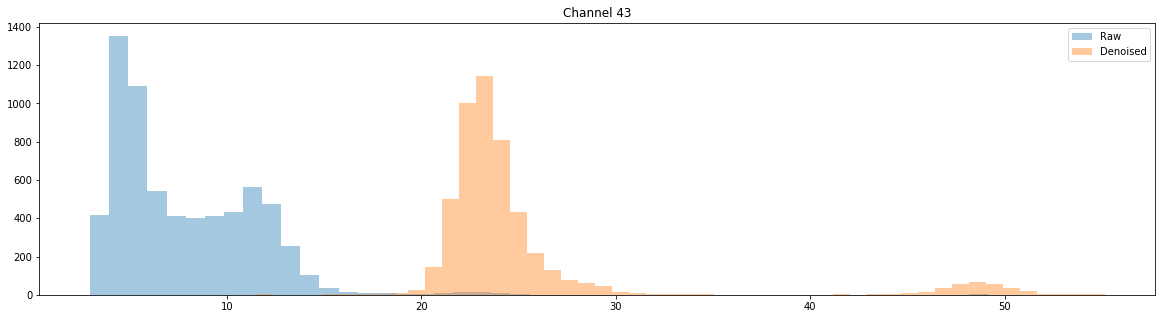

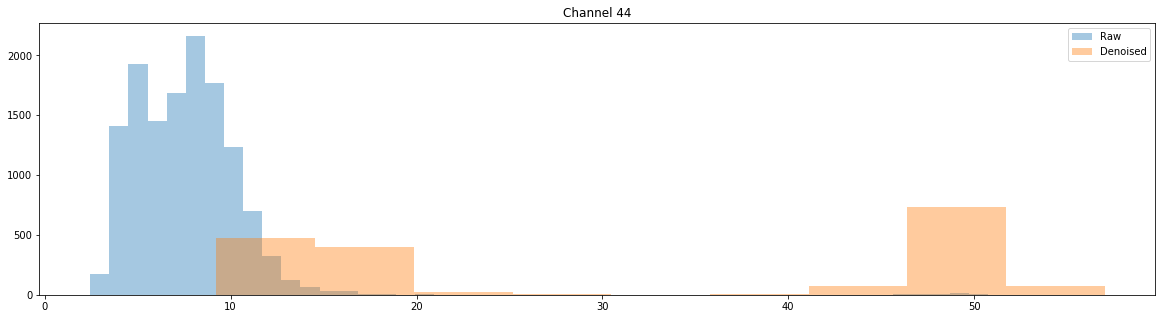

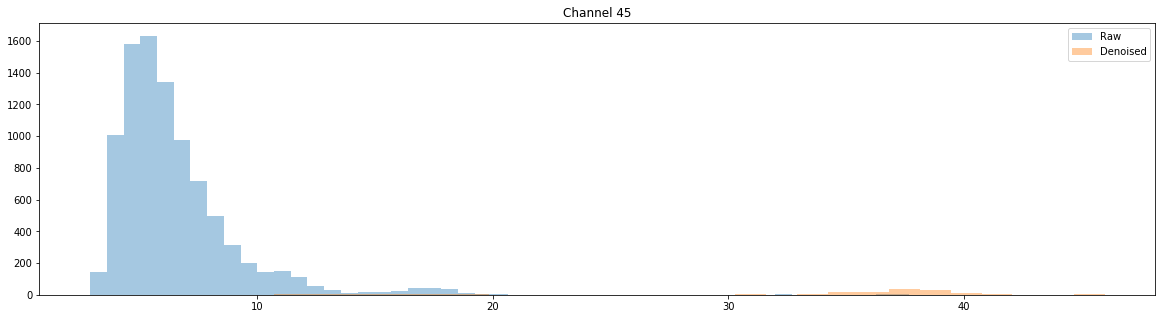

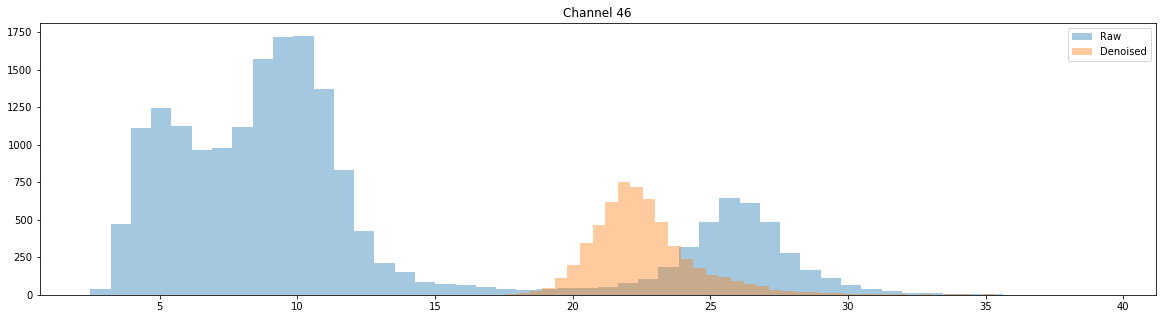

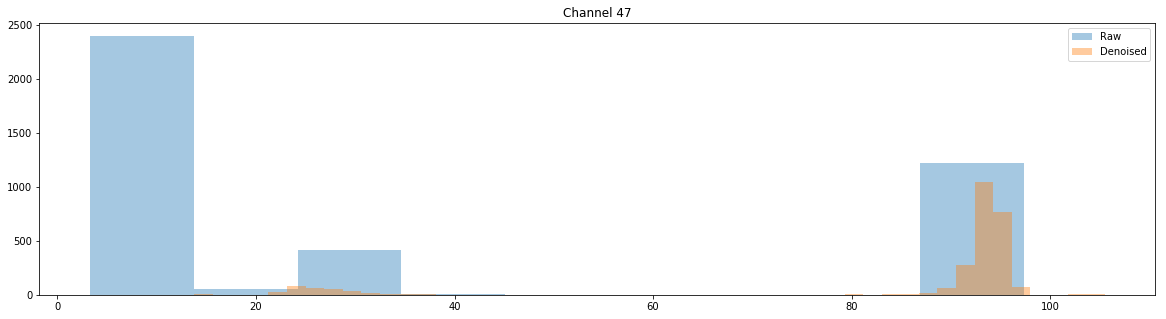

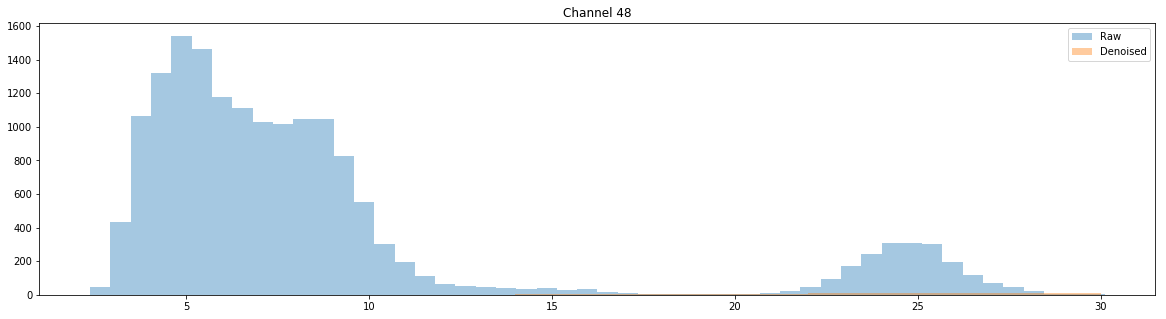

In [90]:
ptps_raw, ptps_denoised = [], []

for ch in CHANNELS:
    plt.figure()
    wfs = indexes_raw.all.read_waveforms_from_channel(rec_all, channel=ch, random_shift=False)
    ptps = templates_utl.ptps(wfs)
    ptps_raw.append(ptps)
    sns.distplot(ptps, ax=None, label='Raw', norm_hist=False, kde=False)

    
    # reac_all or rec_denoised?
    wfs = indexes_denoised.all.read_waveforms_from_channel(rec_all, channel=ch, random_shift=False)
    ptps = templates_utl.ptps(wfs)
    ptps_denoised.append(ptps)
    sns.distplot(ptps, ax=None, label='Denoised', norm_hist=False, kde=False)
    
    plt.title(f'Channel {ch}')
    plt.legend()

ptps_raw = np.concatenate(ptps_raw)
ptps_denoised = np.concatenate(ptps_denoised)

/home/Edu/miniconda3/envs/yass/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


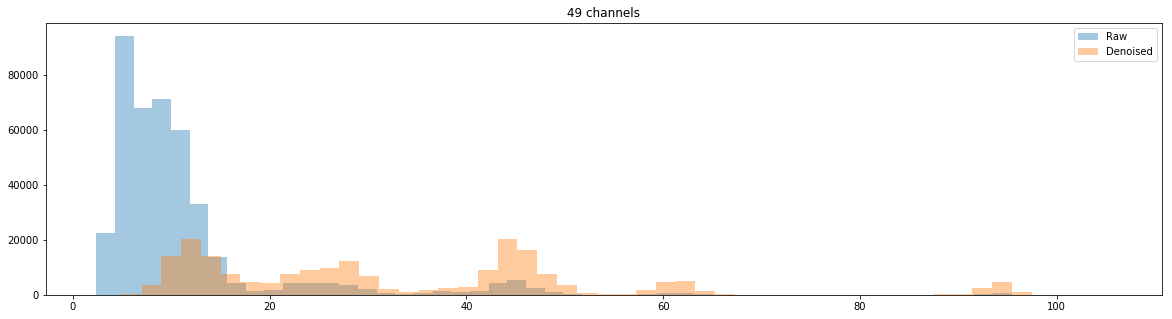

In [91]:
sns.distplot(ptps_raw, ax=None, label='Raw', norm_hist=False, kde=False)
sns.distplot(ptps_denoised, ax=None, label='Denoised', norm_hist=False, kde=False)
plt.title('49 channels')
plt.legend()

In [92]:
indexes_raw.all.arr[10:20]

array([[33619,     0],
       [40677,     0],
       [40964,     0],
       [46958,     0],
       [55728,     0],
       [57871,     0],
       [58123,     0],
       [61112,     0],
       [63443,     0],
       [70323,     0]])

In [93]:
indexes_denoised.all.arr[10:20]

array([[663,  38],
       [788,  16],
       [846,  40],
       [876,  14],
       [876,  44],
       [890,  21],
       [890,  22],
       [890,  28],
       [930,  38],
       [988,   3]], dtype=int32)

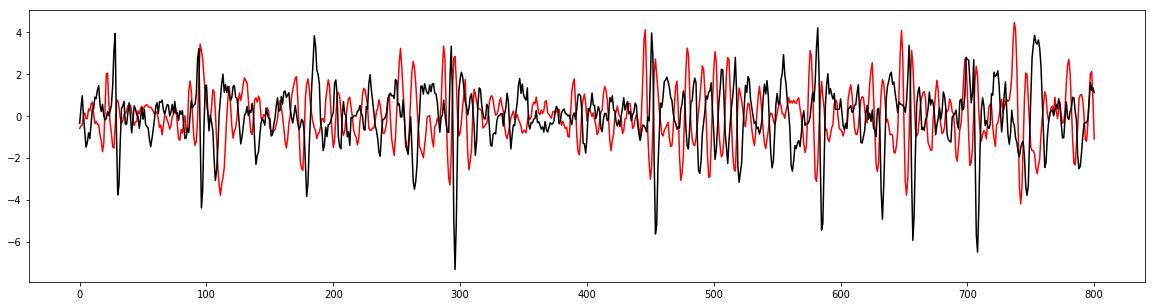

In [94]:
t = np.random.randint(6e6, size=1)[0]
dt = 400
ch = 40

# _ = plt.plot(rec_all[t-dt:t+dt+1, ch_idx[ch]])
# plt.figure()
# _ = plt.plot(rec_denoised[t-dt:t+dt+1, ch_idx[ch]])

plt.figure()
_ = plt.plot(rec_denoised[t-dt:t+dt+1, ch], color='red')
_ = plt.plot(rec_all[t-dt:t+dt+1, ch], color='black')

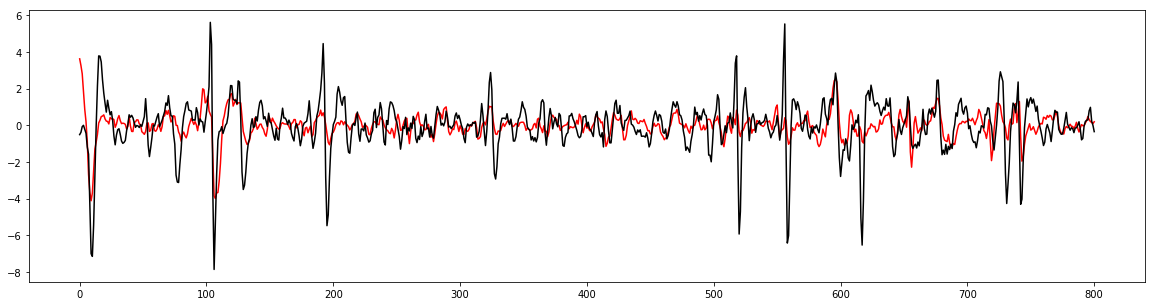

In [95]:
t = np.random.randint(6e6, size=1)[0]
dt = 400
ch = 0

# _ = plt.plot(rec_all[t-dt:t+dt+1, ch_idx[ch]])
# plt.figure()
# _ = plt.plot(rec_denoised[t-dt:t+dt+1, ch_idx[ch]])

plt.figure()
_ = plt.plot(rec_denoised[t-dt:t+dt+1, ch], color='red')
_ = plt.plot(rec_all[t-dt:t+dt+1, ch], color='black')